# Tutorial on Graph Neural Networks for seismic characterization

<img src="https://upload.wikimedia.org/wikipedia/commons/d/da/LOGO_CEA_ORIGINAL_2022.svg" style="height:80px" >     <img src="http://math.ens-paris-saclay.fr/images/photos/0004/img_1586336483577.jpg" style="height:80px" >     <img src="http://math.ens-paris-saclay.fr/images/photos/0004/img_1422545883599.jpeg"  style="height:80px">     <img src="https://www.defense.gouv.fr/sites/default/files/dga/Logotype_DGA_internet.png" style="height:80px" >     <img src="https://upload.wikimedia.org/wikipedia/fr/a/a3/EnsIIE_logo_Ecole-nationale-superieure_fx.svg"  style="height:80px"> 

   

**Authors :** Xavier Cassagnou<sup>1,2</sup>, Aurélien Casagrandi<sup>1,4</sup>, <ins>Elodie Noëlé</ins><sup>1,3</sup>, Christophe Millet<sup>1,2</sup>, Mathilde Mougeot<sup>2,4</sup>

**Affiliation :** 

<sup>1</sup>CEA DAM DIF

<sup>2</sup>Centre Borelli, ENS Paris-Saclay, Université Paris-Saclay 

<sup>3</sup>DGA

<sup>4</sup>ENSIIE

**Corresponding author:** [christophe.millet@cea.fr](mailto:christophe.millet@cea.fr)

**Link to the article:** X. Cassagnou et al., **Dynamic graph neural networks for seismic characterization** (To be published)

The data and models in this tutorial will be published upon acceptation of the article.

**Date :** 19th June 2025

**License :** MIT

---

# Tutorial on seismic characterization with Graph Neural Networks

## Environment setup

In [4]:
# Uncomment if required
#!pip install torch torchvision torchaudio torch-geometric matplotlib seaborn geopandas

import pandas as pd
import os, pickle, torch, timeit
import numpy as np
from torchinfo import summary
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import gc
from modules import utils as ut
from modules import model as md
torch.cuda.empty_cache()
gc.collect()

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'xx-large',       # Taille des légences
          'figure.figsize': (15, 5),           # Taille initiale des figures
         'axes.labelsize': 'xx-large',         # Taille des titres
         'axes.titlesize':'xx-large',          # Taille des titres de figures
         'xtick.labelsize':'xx-large',         # Taille des titres des abscisses
         'ytick.labelsize':'xx-large',         # Taille des titres des ordonnées
         'font.size' : 10.0,                   # Taille du texte
         'font.family': 'DejaVu Sans',         # Paramètre 1 de police du texte
         'font.serif': 'Times New Roman',      # Paramètre 2 de police du texte
         'font.style': 'normal',               # Paramètre 3 de police du texte
         'xtick.direction' : 'inout',          # Sens des abscisses
         'ytick.direction' : 'inout',          # Sens des ordonnées
         'xtick.major.size' : 5,               # Espacement entre les abscisses
         'ytick.major.size' : 5}               # Espacement entre les ordonnées

pylab.rcParams.update(params)                  # Mise à jour globale




## Introduction


<img src="./images/IMS_Map.png" alt="" />

**What's at stake?** : Seismic event monitoring plays a crucial role in the Comprehensive Nuclear-Test-Ban Treaty (CTBT) surveillance by providing a reliable means to detect and identify underground nuclear explosions. By continuously recording and analyzing seismic waves generated by earthquakes and other subsurface activities, monitoring stations can distinguish between natural seismic events and potential nuclear tests based on wave characteristics, depth, and location. This capability ensures timely and accurate verification of compliance with the treaty, helping to deter clandestine nuclear testing and promote global nuclear non-proliferation and security. The worldwide seismic monitoring network supporting the CTBT is a global, integrated system composed of hundreds of seismic stations distributed strategically across the globe to maximize detection sensitivity. This global network is interconnected with numerous country-level and regional seismic networks, facilitating data sharing, cross-validation, and enhanced resolution of event detection. Such cooperation among international, national, and regional networks strengthens the overall robustness and reliability of CTBT verification efforts by combining local expertise and infrastructure with global monitoring capabilities.



## Dataset 
In this project, we leverage two datasets to train and evaluate Graph Neural Networks (GNNs) for the task of seismic event source characterization.

- French Seismic Dataset ([Resif](https://ws.resif.fr/))


This dataset comprises regional earthquake recordings collected from dense seismic networks in France. It includes waveform data, event metadata (e.g., origin time, location, magnitude), and station metadata. The dataset provides a valuable testbed for GNNs due to its variable sensor coverage and diverse geological settings. 

- Southern California Earthquake Data Center ( [SCEDC](https://scedc.caltech.edu/data/stp/index.html))

This dataset includes high-resolution seismic event data from the Southern California Seismic Network (SCSN). It features a large number of well-located events, extensive waveform recordings, and rich station metadata. Its scale and completeness make it an excellent benchmark for evaluating the generalizability of GNN-based source characterization methods.

By using these two datasets, we aim to validate the performance and robustness of GNN models across different regional settings and network configurations.

#### French Network Data (Résif)

This dataset is provided by the French µseismological and geodetic network Résif. It comprises 13,479 seismic events recorded between January
2019 and December 2021 across a wide geographical region (latitudes 40°–53°, longitudes –6° to 11°). The network includes 42 stations equipped with short-period sensors, each recording only the vertical ground velocity at a sampling rate of 50 Hz. To ensure data quality and enable comparison with the second dataset, we restrict the events to those with estimated magnitudes between 1.5 and 6.0, resulting in 7030 usable events.

Here is an example of waveforms received by two different stations of this dataset (ADO and ALP) for their three components (North-South, East-West, Up-Down) for the same seismic event.

<div style="text-align: center;">
<img src="./images/LDG_visu_series.jpeg" alt="" />
</div>

#### Southern California Seismic Network (SCEDC)

This dataset is provided by the South Californian Earthquakes Data Center and includes 4581 events recorded between January 2000 and June 2019 over a more compact region (latitudes 32°–36°, longitudes –120° to –116°). All events have magnitudes between 2.5 and 6.0 and depths shallower than 30 km. The network comprises 211 stations equipped with broadband three-component sensors, operating at 20 or 40 Hz. For
computational efficiency, we select a representative subset of 72 stations uniformly distributed across the region. 


Here is an example of waveforms received by two different stations of this dataset (ADO and ALP) for their three components (North-South, East-West, Up-Down) for the same seismic event.

<div style="text-align: center;">
<img src="./images/SCDEC_visu_series.jpeg" alt="" />
</div>


For both datasets, those events are listed alongside an estimation of their location (latitude and longitude), their magnitude and their depth : these are the four informations that the model is supposed to predict.

<div style="text-align: center;">
    
  <img src="images/joint_distribution_datasets.png" alt="Joint distribution datasets" width="500">
  <p><em>Joint distribution of events from the two datasets — SCDEC (blue) and Résif(red)— with respect to event magnitude and average distance to available recording stations. Only the events and stations used for training are shown.</em></p>

</div>



**Context:** Assuming that a seismic network is modeled as a graph, with seismic stations constituting the nodes and the spatial relationships between stations representing the edges, the seismic waveform signals associated with each station can be defined as the network's edges. For each of these waveforms, the North-South, East-West, and Up-Down components are identifiable. The objective of this study is to develop a function capable of predicting earthquake source parameters, including latitude, longitude, depth, and magnitude, from multi-station waveforms.


<div style="text-align: center;">
    
  <img src="images/SCDEC_Seismic_map.png" alt="" width="500">  <img src="images/LDG_Seismic_map.png" alt="" width="500">
  <p><em>Positions of some stations for the Californian dataset (left) and the French dataset (right) </em></p>

</div>


**Goal:** Predict the location (latitude, longitude), magnitude, and depth of a seismic event using a Graph Neural Network (GNN).

**Why GNNs?**
Machine learning models are increasingly used in geophysical applications, particularly for problems involving large, complex, and noisy datasets. Traditional ML models like decision trees, SVMs, or fully connected neural networks treat data as independent samples. However, seismic data collected from a network of stations is inherently relational — the response at one station is correlated with others due to spatial proximity and shared wave propagation paths.

Graph Neural Networks (GNNs) are a class of deep learning models designed to work directly on graph-structured data. They extend the idea of convolutional neural networks (CNNs) to graphs, enabling learning from both node features and the connectivity of the data.


#### Spatial relationships between seismic stations using K-nearest neighbours for building the graphs

In this study, we use two real-world seismic datasets: one from France and one from California. The French dataset results in a sparser graph compared to the Californian dataset, primarily due to the greater average distance between seismic stations in the French network. To construct the graph structures from the station coordinates, we employ the K-Nearest Neighbors (KNN) method with **K=5** and include **self-loops** to ensure each node is connected to itself.

<div style="text-align: center;">
    
  <img src="images/SCDEC_visu_graphe.jpeg" alt="" width="500">  <img src="images/LDG_visu_graphe.jpeg" alt="" width="500">
  <p><em>Spatial graph for the Californian dataset (left) and the French dataset (right). The blue star corresponds to an event, the red triangle corresponds to a station (node) and the green line to the edges between nodes built using by a (K=5)-NN method. </em></p>

</div>

In machine learning and graph-based methods, a K-Nearest Neighbor (KNN) graph connects each node (station) to its K nearest neighbors based on a distance metric (typically Euclidean distance in feature space). In our case, this metric is the pairwise geographc distances between the stations. This approach is particularly useful in geophysical applications where sensor connectivity is not explicit but must be inferred from spatial proximity, allowing the resulting graph to capture the underlying geometry and spatial relationships of the seismic network.
* Each node represents a data point.
* An edge is drawn from a node to its K closest nodes.
* This forms a sparse graph, useful for capturing local relationships.

    
There is two types of KNN Graphs, symmetric and asymmetric graphs :
* Asymmetric KNN Graph, which are useful when modeling directed influences or local flows.
  - For each node, edges go only to its K nearest neighbors.
  - If node A is a neighbor of node B, B is not necessarily a neighbor of A.
  - The adjacency matrix is not symmetric.
* Symmetric KNN Graph, which are preferred when using algorithms that assume undirected graphs (e.g., spectral clustering, GCNs).
  - The graph is made undirected by symmetrizing the edges.
  - Two common symmetrization methods which are Mutual KNN, where A and B connect only if both are in each other’s K-nearest list, or Union KNN, where A and B connect  if either is in the other's K-nearest list.
  - The adjacency matrix becomes symmetric.



***Mathematical Formalism of GNNs (fig 2.)***
<img src="./images/graph_explanation.png" alt="Example Image" style="height:1000px;  float: left; margin-right: 1px;"/>
<div>
    
Let a graph (fig 1.) be defined as $ G = (V, E)$, with:
- $ V $: a set of nodes (e.g., seismic stations)
- $ E $: a set of edges (e.g., connectivity based on location or signal correlation)
- $ A \in \mathbb{R}^{N \times N} $: the adjacency matrix (fig 2.)
- $ X \in \mathbb{R}^{N \times d} $: the feature matrix with $ d $-dimensional node features


    
The general form of message-passing GNNs (fig 4.) is:

$$ h_i^{(k+1)} = \gamma^{(k)}\left( h_i^{(k)}, \oplus_{j \in \mathcal{N}(i)} \phi^{(k)}(h_i^{(k)}, h_j^{(k)}, e_{ij}) \right) $$

Where:
- $ h_i^{(k)} $: hidden representation of node $ i $ at layer $ k $
- $ \mathcal{N}(i) $: neighborhood of node $ i $
- $ \phi $: message function
- $ \gamma $: update function (e.g., MLP)
- $ \oplus $: aggregation function (e.g., sum, mean, max)

    
    
    
A common simplification is the Graph Convolutional Network (GCN) (fig 5.):

$$ H^{(l+1)} = \sigma\left( \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2} H^{(l)} W^{(l)} \right) $$

Where:
- $ \hat{A} = A + I $ adds self-loops
- $ \hat{D} $ is the degree matrix of $ \hat{A} $
- $ W^{(l)} $: learnable weights
- $ \sigma $: nonlinearity (e.g., ReLU)

<br><br>
    
**In this context:**
- **Nodes** represent seismic stations with their corresponding signal features (e.g., waveform descriptors).
- **Edges** represent the relationships or distances between stations (e.g., geographic, signal correlation).

GNNs aggregate and transform features through message passing between nodes, capturing both local and global patterns in the data.

</div>




**Benefits of GNNs for Seismic Analysis:**
- Incorporate spatial structure of seismic networks
- Handle variable network topologies
- Improve generalization by leveraging relational inductive bias

**Live Demo Steps:**
1. Data overview
2. Architectures' overview
3. Results
4. Error analysis through ANOVA
5. Conclusion


In [341]:
# Set a fixed seed for reproducibility of results
seed = 0

# Specify which GPU device to use
device = "cuda:1"

# Seed numpy's random number generator
np.random.seed(seed)

# Seed PyTorch's random number generator (CPU and GPU)
torch.manual_seed(seed)

# Make CUDA convolution deterministic for reproducible behavior (may slow down training)
torch.backends.cudnn.deterministic = True

# Choose the dataset/network name (here SCDEC - Southern California Earthquake Data Center)
network = "SCDEC"

# Define the folder path where the data files are located, relative to current working directory
folder = os.path.join(os.getcwd(), "./data", network)

# Prepare a list of paths for 10 data files named data-0.pkl to data-9.pkl in the folder
data = [os.path.join(folder, f"data-{i}.pkl") for i in range(10)]

# Folder for examples or outputs
folder = os.path.join(os.getcwd(), 'example')

# Use first 9 data files as training data, last one as validation data
train_file = data[:-1]
valid_file = data[-1]

# Path/filename to save or load the model weights
model_file = "model.pt"

# Model identifier/name (for logging or saving purposes)
model_name = "GNN1"

# Number of training epochs
n_epochs = 800

# Mini-batch s


## 1.Overview on the data preprocessing

To prepare the dataset for training, we start with raw waveform recordings from a network of seismic stations irregularly distributed in space. Each event is associated with its physical properties — latitude, longitude, depth, and magnitude — that we aim to predict.

The preprocessing pipeline involves the following steps:
* **Label Normalization**: Event attributes (latitude, longitude, depth, magnitude) are normalized to the range [−1,1][−1,1] to ensure consistent scaling across input features. This helps stabilize training and avoid biases caused by differing value ranges.

* **Station Metadata Processing**: The latitude and longitude of each station are also normalized to the same [−1,1][−1,1] range. A pairwise distance matrix between stations is computed using the spherical law of cosines, giving a geodesic measure of inter-station distance.

* **Waveform Extraction**: For each event and station, a 3-component waveform (N, E, Z) is extracted from pre-saved pickle files. Each component is processed independently.

* **Temporal Resampling (Optional)**: If enabled, a time-scaling factor is applied to stretch or compress the waveform in time. This simulates variability in seismic signal propagation and enhances generalization.

* **Bandpass Filtering**: A zero-phase Butterworth bandpass filter is applied in both forward and reverse directions. This removes irrelevant frequency content and reduces noise while preserving signal shape.

* **Hilbert Transform (Optional)**: The analytic signal can be computed using the Hilbert transform, and its envelope is extracted. This provides a smoother amplitude representation which may be beneficial for learning.

* **Window Selection and Random Sliding**: A fixed-size time window is selected starting at a reference point t<sub>min</sub>, with optional random shifts applied to introduce temporal variability. This acts as a form of data augmentation. Additionally, the use of misaligned windows helps simulate scenarios where seismic phase picks—particularly the P-wave (primary, fastest-arriving) and S-wave (secondary, shear wave)—are uncertain or unavailable. Such conditions are common in early warning systems or low signal-to-noise ratio (SNR) environments. This strategy encourages the model to learn robust features without relying on precise phase alignment, improving generalization in real-world deployments.

* **Amplitude Scaling**: The waveforms are scaled globally by a constant factor to ensure values fall in a suitable range for learning.

***Data Assembly**: The final dataset x_train is a 4D array of shape (num_events, num_stations, time_length, num_components), where each entry corresponds to a normalized and filtered waveform snippet. The target array y_train contains the corresponding normalized event parameters, and station positions and distances are stored for graph construction.

This pipeline ensures the input data is clean, consistent, and formatted in a way that is compatible with graph-based neural architectures, which can learn to predict earthquake parameters from the collective response of the seismic network.


<img src="./images/data_overview.png" alt="" />

## 2. Architecture overview

### General framework
We have a seismic network modeled as a graph $ G = (V, E) $, where:
- $V$ corresponds to the $N \in \mathbb{N_*}$ seismic stations $s$ (nodes $v_s \in V $) for which a seismic signal waveform of $P \in \mathbb{N_*}$ time steps and three components (North-South, East-West, Up-Down) $x_s \in \mathbb{R}^{P \times 3} $ and geographic coordinates (latitude and longitude) $p_s \in \mathbb{R}^2$ are associated
- $E$ corresponds to the spatial relationships between the stations (edges) to be defined and learn through the networks.

From the data of this seismic network, we want to compute the source parameters $y \in \mathbb{R}^4$, a seismic event's latiude, longitude, depth and magnitude.

To do such, our aim to learn a function $h_{\theta}$ such as : 

$\begin{array}{ccccc}
h_{\theta} & : & \mathbb{R}^{N \times P \times 3} \times \mathbb{R}^{N \times 2} \times \mathbb{E}(G) & \mapsto & \mathbb{R}^4 \\
 & & x, p, G & \mapsto & y \\
\end{array}$


Inspired by the works on GNN (missing references and explanation), we designed a three component-archicture
such as $ y = h^{(3)}_{\theta^{(3)}} \big( \max_{1 \leq s \leq N} h^{(2)}_{\theta^{(2)}} (p_s, h^{(1)}_{\theta^{(1)}}(x_s)) \big) $:
- $h^{(1)}_{\theta^{(1)}}$, a CNN-based encoder for extracting the temporal features of the seismic waveforms for each seismic station
- $h^{(2)}_{\theta^{(2)}}$, a fully-connected neural network to concatenate the latent temporal features with the station geographic coordinates.
- $h^{(3)}_{\theta^{(3)}}$, a MLP for predicting the source parameters from the spatially enhanced vectors.

In the following paragraphs, we will review each architecture component.

### CNN-based encoder $h^{(1)}_{\theta^{(1)}}$

The first component of the architecture $h^{(1)}_{\theta^{(1)}}$ is based on multiple temporal convolutions (Conv2d) applied on the temporal waveform $x_s$ associated with each station $s$ of the nodes $V$. It contains five sub-components denoted as TimeBlock with $L$ convolutional layers :

<img src="./images/TimeBlock.png" alt="" />

This 2D convolution of kernel size (1,5) is applied for each time step $n \in \{1, ..., P\} $ and for each feature channel $i$ of a waveform $x_s$ such as :


$$ x^{(l)}_{si}[n] = ReLU \Big( b_i^{(l)} + \sum_{j=1}^{d_{l-1}} \underbrace{W^{(l)}_{ji} * x_{sj}^{(l-1)}[n]}_{{\substack{\text{convolution operator} \\ \sum^4_{k=0} w^{(l)}_{jik}x^{(l-1)}_{sj} [n+k]}}} \Big) $$

For this sub-component, the total number of learnable weights is : $\sum^L_{l=1} d_l(4d_{l+1}+1)$
Then, to reduce the size of the output vector, a global max pooling-layer is applied on the output of the convolutional layers after a dropout operation for avoiding overfitting.

In [343]:

class TimeBlock(nn.Module):
    """
    Neural network block that applies 3 temporal convolutions to each node of a graph in isolation.
    """

    def __init__(self, n_layers, in_channels, out_channels, kernel_size=5, activ = F.relu, dropout = 0, pool_kernel_size = (1,1)):
        """
        :param in_channels: Number of input features at each node in each time step.
        :param out_channels: Desired number of output channels at each node in each time step.
        :param kernel_size: Size of the 1D temporal kernel.
        """
        super(TimeBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(in_channels, out_channels, (1, kernel_size)))
        for i in range(1, n_layers):
            self.layers.append(nn.Conv2d(out_channels, out_channels, (1, kernel_size)))
            
        self.activ = activ
        self.dropout = nn.Dropout2d(dropout)
        self.pooling = nn.MaxPool2d(pool_kernel_size)
        
        for l in self.layers:
            nn.init.orthogonal_(l.weight)

    def forward(self, X):
        """
        :param X: Input data of shape (batch_size, num_features=in_channels, num_nodes, num_timesteps)
        :return: Output data of shape (batch_size, num_features=out_channels, num_nodes, num_timesteps_out)
        """
        for i in range(len(self.layers)):
            X = self.layers[i](X)
            X = self.activ(X)
            X = self.dropout(X)
        X = self.pooling(X)
                        
        return X
    
    

To avoid an abrupt reduction in sequence length at the final stage, intermediate pooling layers are introduced between convolutional layers, allowing for a more gradual and controlled reduction, so that this component is composed of five TimeBlocks with a total $\sum^5_{t=1} \sum^{L^{(t)}}_{l=1} d^{(t)}_l(4d^{(t)}_{l+1}+1)$ learnable weights

<img src="./images/CNN.png" alt="" />

The aim of this architecture is to get a latent representation $\tilde{x_s}$ of the signal waveform of each station for capturing temporal characteristic patterns.


In [344]:

        
class CNN(nn.Module):

    def __init__(self, in_channels, dropout = 0):
        
        super(CNN, self).__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(TimeBlock(n_layers = 3, in_channels = in_channels, out_channels = 8, kernel_size = 5, activ = F.relu, dropout = dropout, pool_kernel_size = (1,4)))
        self.layers.append(TimeBlock(n_layers = 3, in_channels = 8, out_channels = 16, kernel_size = 5, activ = F.relu, dropout = dropout, pool_kernel_size = (1,4)))
        self.layers.append(TimeBlock(n_layers = 3, in_channels = 16, out_channels = 32, kernel_size = 5, activ = F.relu, dropout = dropout, pool_kernel_size = (1,4)))
        self.layers.append(TimeBlock(n_layers = 2, in_channels = 32, out_channels = 64, kernel_size = 5, activ = F.relu, dropout = dropout))
        self.layers.append(TimeBlock(n_layers = 1, in_channels = 64, out_channels = 64, kernel_size = 5, activ = F.tanh, dropout = 0, pool_kernel_size = (1,16)))
        
        # Taille du signal
        # 2048 -> 2044 -> 2040 -> 2036 -> 509
        # 509 -> 505 -> 501 -> 497 -> 124
        # 124 -> 120 -> 116 -> 112 -> 28
        # 28 -> 24 -> 20 -> 16 -> 1

    def forward(self, X):
        """
        :param X: Input data of shape (batch_size, num_features=in_channels, num_nodes, 2048)
        :return: Output data of shape (batch_size, num_features=64, num_nodes, 1)
        """
        
        for l in self.layers:
            X = l(X)
            
        return X

### MLP for aggregating latent temporal features with stations geographic coordinates $h^{(2)}_{\theta^{(2)}}$

From this reduced vector $\tilde{x_s}$, we want to include the information coming from the geographic coordinates of the stations. To do so, we aggregate the vectors to get an enhanced feature vector $\hat{x_s} = \tilde{x_s} || p_s $ on which a TimeBlock is applied for performance improvment and obtain a lower-dimension latent representation vector of the aggregated data.

<img src="./images/TimeBlock.png" alt="" />

### Source parameters prediction with the MLP $h^{(3)}_{\theta^{(3)}}$

For the third and last component, we use a component-wise max pooling layer followed by a 2-layers MLP for the prediction of the target source parameters from enhanced feature vectors $\hat{x_s}$. So that:
$$ y = \sigma_2 \big(W_2 \sigma_1(W_1 \underbrace{z}_{\max_{1 \leq s \leq N} \hat{x_s}} + b_1) + b_2 \big)$$

<img src="./images/MLP.png" alt="" />

In [345]:

        
       
        
class MLP(nn.Module):

    def __init__(self, num_nodes, in_channels, dropout = 0):

        super(MLP, self).__init__()

        self.pooling = nn.MaxPool2d((num_nodes,1))
        self.MLP1 = nn.Linear(in_channels, 128)
        self.MLP2 = nn.Linear(128, 4)
        nn.init.orthogonal_(self.MLP1.weight)
        nn.init.orthogonal_(self.MLP2.weight)
        self.dropout = nn.Dropout(dropout)
            

    def forward(self, X):
        """
        :param X: Input data of shape (batch_size, in_channels, num_nodes, 1)
        :return: Output data of shape (batch_size, 4)
        """
        X = torch.squeeze(self.pooling(X))
        X = F.relu(self.MLP1(X))
        X = self.dropout(X)
        X = F.tanh(self.MLP2(X))
        return X

### First architecture : Edgeless Graph Neural Network GNN1

This first architecture with the components set as described below is denoted Edgeless-GNN:

<img src="./images/GNN1.png" alt="" />

As the operation of $h^{(1)}_{\theta^{(1)}}$ and $h^{(2)}_{\theta^{(2)}}$ apply the same operations independently on each element, they are permutation-invariant and even permutation-equivariant (to be checked)

This terminology emphasizes the graph-like structure of the input while acknowledging
the absence of edge modeling and the architectural simplifications relative to classical
GNNs.

In [346]:

        
        
class GNN1(nn.Module):

    def __init__(self, in_channels, pos, dropout = 0):
        """
        :param in_channels: Number of input features at each node in each time step.
        :param pos: Positions of stations : shape (2, num_nodes)
        """
        
        super(GNN1, self).__init__()
        
        self.pos = pos
        
        self.CNNlayer = CNN(in_channels = in_channels, dropout = dropout)
        self.sblock = TimeBlock(n_layers = 2, in_channels = 66, out_channels = 128, kernel_size = 1, activ = F.relu, dropout = dropout)
        self.MLP = MLP(num_nodes = pos.shape[1], in_channels = 128, dropout = dropout)

    def forward(self, X):
        """
        :param X: Input data of shape (batch_size, num_features=in_channels, num_nodes, 2048)
        :param pos: Positions of stations : shape (2, num_nodes)
        :return: Output data of shape (batch_size, num_features=4)
        """
        
        X = self.CNNlayer(X)                                                    # Shape (batch_size, 64, num_nodes, 1)
        pos = self.pos.repeat(X.shape[0], 1, 1, 1).permute(0, 2, 3, 1)          # Shape (batch_size, 2, num_nodes, 1)
        X = torch.cat((X, pos), 1)                                              # Shape (batch_size, 66, num_nodes, 1)
        X = self.sblock(X)
        X = self.MLP(X)
        return X

In [347]:


x_train, y_train = arrData[0][0], arrData[0][1]
x_train = torch.permute(torch.Tensor(x_train).to(device),(0,3,1,2))
pos = torch.Tensor(arrData[0][2].T).to(device)
dist = torch.Tensor(arrData[0][3]).to(device)


#### Training

In [29]:
model = GNN1(x_train.shape[1], pos, dropout_rate).to(device)
print('Total params: ' + str(sum(p.numel() for p in model.parameters())))
summary(model, x_train[0].unsqueeze(0).shape)


Total params: 110436


Layer (type:depth-idx)                   Output Shape              Param #
GNN1                                     [4]                       --
├─CNN: 1-1                               [1, 64, 72, 1]            --
│    └─ModuleList: 2-1                   --                        --
│    │    └─TimeBlock: 3-1               [1, 8, 72, 509]           784
│    │    └─TimeBlock: 3-2               [1, 16, 72, 124]          3,248
│    │    └─TimeBlock: 3-3               [1, 32, 72, 28]           12,896
│    │    └─TimeBlock: 3-4               [1, 64, 72, 20]           30,848
│    │    └─TimeBlock: 3-5               [1, 64, 72, 1]            20,544
├─TimeBlock: 1-2                         [1, 128, 72, 1]           --
│    └─ModuleList: 2-4                   --                        (recursive)
│    │    └─Conv2d: 3-6                  [1, 128, 72, 1]           8,576
│    └─Dropout2d: 2-3                    [1, 128, 72, 1]           --
│    └─ModuleList: 2-4                   --              

In [295]:
torch.cuda.empty_cache()
gc.collect()

#               x_train             y_train
# Dimension 0 : évènements          évènements
# Dimension 1 : directions (3)      labels (4)
# Dimension 2 : stations (50)       -
# Dimension 3 : temps (2048)        -

x_train, y_train = arrData[0][0], arrData[0][1]
for data_file in train_file[1:]:
    x_train = np.concatenate((x_train, arrData[0][0]), axis = 0)
    y_train = np.concatenate((y_train, arrData[0][1]), axis = 0)

x_train = torch.permute(torch.Tensor(x_train).to(device),(0,3,1,2))
y_train = torch.Tensor(y_train[:,1:]).to(device)
pos = torch.Tensor(arrData[0][2].T).to(device)
dist = torch.Tensor(arrData[0][3]).to(device)

(x_valid, y_valid, _, _) = np.load(valid_file, allow_pickle=True)
x_valid = torch.permute(torch.Tensor(x_valid).to(device),(0,3,1,2))
y_valid = torch.Tensor(y_valid[:,1:]).to(device)


model = md.GNN1(x_train.shape[1], pos, dropout_rate).to(device)

model_file = "model_GNN1.pt"

optimizer = torch.optim.Adam(model.parameters(),lr=lr)
if L2:
    criterion = nn.MSELoss().to(device)
else:
    criterion = nn.L1Loss().to(device)
    
loss_dict = {"train" : [],
            "valid" : []}
loss_valid_min = 0


earlyStopper = EarlyStopper(50, 0.0002)
for epoch in tqdm(range(n_epochs)):
    
    t1 = timeit.default_timer()
    inds = np.arange(len(x_train))
    np.random.shuffle(inds)
    
    lossAvg = 0
    count = 0
    
    for k in range(0, len(x_train)-batch_size, batch_size):
        inds_k = inds[k:k+batch_size]
        results = model(x_train[inds_k])
        loss = criterion(results,y_train[inds_k])

#        print(loss.item(),k,epoch,time()-t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossAvg = loss.item()
        count +=1
        
    lossAvg = lossAvg / count
    loss_dict["train"].append(lossAvg)

    # Early stopping
    with torch.no_grad():
        results_valid = model(x_valid)
    loss_valid = criterion(results_valid, y_valid)
    #print(loss_valid.item(), epoch, time()-t)
    if loss_valid_min == 0 or loss_valid_min > loss_valid.item():
        loss_valid_min = loss_valid.item()
        model_valid = model.state_dict()
    loss_dict["valid"].append(loss_valid.item())
    
    if earlyStopper.early_stop(loss_valid.item()):
        print(f'Epoch {epoch+1}/{n_epochs}: {t2-t1:.2f}s - Training loss = {lossAvg:.6f} - Validation loss = {loss_valid.item():.6f}')
        break
    
    t2 = timeit.default_timer()
    print(f'Epoch {epoch+1}/{n_epochs}: {t2-t1:.2f}s - Training loss = {lossAvg:.6f} - Validation loss = {loss_valid.item():.6f}')


torch.save(model_valid, folder+"/"+model_file)
np.save(folder+"/loss_"+model_file, loss_dict)
print(loss_valid_min)

  0%|          | 1/800 [00:11<2:30:04, 11.27s/it]

Epoch 1/800: 11.27s - Training loss = 0.002280 - Validation loss = 0.328324


  0%|          | 2/800 [00:22<2:29:02, 11.21s/it]

Epoch 2/800: 11.16s - Training loss = 0.002687 - Validation loss = 0.322081


  0%|          | 3/800 [00:33<2:30:05, 11.30s/it]

Epoch 3/800: 11.41s - Training loss = 0.002409 - Validation loss = 0.321468


  0%|          | 4/800 [00:45<2:32:07, 11.47s/it]

Epoch 4/800: 11.72s - Training loss = 0.002241 - Validation loss = 0.320410


  1%|          | 5/800 [00:57<2:32:07, 11.48s/it]

Epoch 5/800: 11.51s - Training loss = 0.002362 - Validation loss = 0.319457


  1%|          | 6/800 [01:08<2:33:24, 11.59s/it]

Epoch 6/800: 11.81s - Training loss = 0.002648 - Validation loss = 0.318933


  1%|          | 7/800 [01:20<2:33:45, 11.63s/it]

Epoch 7/800: 11.72s - Training loss = 0.002149 - Validation loss = 0.317633


  1%|          | 8/800 [01:32<2:33:25, 11.62s/it]

Epoch 8/800: 11.60s - Training loss = 0.002296 - Validation loss = 0.318394


  1%|          | 9/800 [01:43<2:33:24, 11.64s/it]

Epoch 9/800: 11.66s - Training loss = 0.002199 - Validation loss = 0.316835


  1%|▏         | 10/800 [01:55<2:33:37, 11.67s/it]

Epoch 10/800: 11.74s - Training loss = 0.002492 - Validation loss = 0.313800


  1%|▏         | 11/800 [02:07<2:33:55, 11.71s/it]

Epoch 11/800: 11.79s - Training loss = 0.002344 - Validation loss = 0.307826


  2%|▏         | 12/800 [02:19<2:34:08, 11.74s/it]

Epoch 12/800: 11.81s - Training loss = 0.001931 - Validation loss = 0.285070


  2%|▏         | 13/800 [02:30<2:33:44, 11.72s/it]

Epoch 13/800: 11.68s - Training loss = 0.002042 - Validation loss = 0.242064


  2%|▏         | 14/800 [02:42<2:32:41, 11.66s/it]

Epoch 14/800: 11.51s - Training loss = 0.001468 - Validation loss = 0.198633


  2%|▏         | 15/800 [02:53<2:32:00, 11.62s/it]

Epoch 15/800: 11.53s - Training loss = 0.001285 - Validation loss = 0.184466


  2%|▏         | 16/800 [03:05<2:32:55, 11.70s/it]

Epoch 16/800: 11.90s - Training loss = 0.001242 - Validation loss = 0.172206


  2%|▏         | 17/800 [03:17<2:33:20, 11.75s/it]

Epoch 17/800: 11.86s - Training loss = 0.001247 - Validation loss = 0.167135


  2%|▏         | 18/800 [03:29<2:33:18, 11.76s/it]

Epoch 18/800: 11.79s - Training loss = 0.001151 - Validation loss = 0.162938


  2%|▏         | 19/800 [03:41<2:32:33, 11.72s/it]

Epoch 19/800: 11.62s - Training loss = 0.001004 - Validation loss = 0.161159


  2%|▎         | 20/800 [03:52<2:32:46, 11.75s/it]

Epoch 20/800: 11.83s - Training loss = 0.000899 - Validation loss = 0.155514


  3%|▎         | 21/800 [04:04<2:32:10, 11.72s/it]

Epoch 21/800: 11.65s - Training loss = 0.000989 - Validation loss = 0.154730


  3%|▎         | 22/800 [04:16<2:32:32, 11.76s/it]

Epoch 22/800: 11.86s - Training loss = 0.001004 - Validation loss = 0.149830


  3%|▎         | 23/800 [04:28<2:32:44, 11.79s/it]

Epoch 23/800: 11.87s - Training loss = 0.000841 - Validation loss = 0.145248


  3%|▎         | 24/800 [04:40<2:33:50, 11.90s/it]

Epoch 24/800: 12.13s - Training loss = 0.001093 - Validation loss = 0.144271


  3%|▎         | 25/800 [04:52<2:32:54, 11.84s/it]

Epoch 25/800: 11.70s - Training loss = 0.000833 - Validation loss = 0.141252


  3%|▎         | 26/800 [05:04<2:33:25, 11.89s/it]

Epoch 26/800: 12.02s - Training loss = 0.000937 - Validation loss = 0.139842


  3%|▎         | 27/800 [05:16<2:33:09, 11.89s/it]

Epoch 27/800: 11.87s - Training loss = 0.000911 - Validation loss = 0.141541


  4%|▎         | 28/800 [05:28<2:35:09, 12.06s/it]

Epoch 28/800: 12.46s - Training loss = 0.001057 - Validation loss = 0.139572


  4%|▎         | 29/800 [05:40<2:34:51, 12.05s/it]

Epoch 29/800: 12.03s - Training loss = 0.000861 - Validation loss = 0.140861


  4%|▍         | 30/800 [05:52<2:35:29, 12.12s/it]

Epoch 30/800: 12.27s - Training loss = 0.000949 - Validation loss = 0.136560


  4%|▍         | 31/800 [06:05<2:35:50, 12.16s/it]

Epoch 31/800: 12.26s - Training loss = 0.001123 - Validation loss = 0.134531


  4%|▍         | 32/800 [06:17<2:34:56, 12.10s/it]

Epoch 32/800: 11.98s - Training loss = 0.000852 - Validation loss = 0.138070


  4%|▍         | 33/800 [06:29<2:34:44, 12.10s/it]

Epoch 33/800: 12.10s - Training loss = 0.000825 - Validation loss = 0.131893


  4%|▍         | 34/800 [06:41<2:34:29, 12.10s/it]

Epoch 34/800: 12.09s - Training loss = 0.000942 - Validation loss = 0.133661


  4%|▍         | 35/800 [06:53<2:33:52, 12.07s/it]

Epoch 35/800: 11.99s - Training loss = 0.000850 - Validation loss = 0.132362


  4%|▍         | 36/800 [07:05<2:33:38, 12.07s/it]

Epoch 36/800: 12.06s - Training loss = 0.001041 - Validation loss = 0.131779


  5%|▍         | 37/800 [07:17<2:34:09, 12.12s/it]

Epoch 37/800: 12.25s - Training loss = 0.000861 - Validation loss = 0.129542


  5%|▍         | 38/800 [07:29<2:34:33, 12.17s/it]

Epoch 38/800: 12.28s - Training loss = 0.000991 - Validation loss = 0.128839


  5%|▍         | 39/800 [07:41<2:33:06, 12.07s/it]

Epoch 39/800: 11.84s - Training loss = 0.000853 - Validation loss = 0.128535


  5%|▌         | 40/800 [07:53<2:32:47, 12.06s/it]

Epoch 40/800: 12.04s - Training loss = 0.000965 - Validation loss = 0.127766


  5%|▌         | 41/800 [08:05<2:32:05, 12.02s/it]

Epoch 41/800: 11.93s - Training loss = 0.001137 - Validation loss = 0.128521


  5%|▌         | 42/800 [08:17<2:32:27, 12.07s/it]

Epoch 42/800: 12.17s - Training loss = 0.000839 - Validation loss = 0.131486


  5%|▌         | 43/800 [08:29<2:31:48, 12.03s/it]

Epoch 43/800: 11.95s - Training loss = 0.000879 - Validation loss = 0.129328


  6%|▌         | 44/800 [08:41<2:31:26, 12.02s/it]

Epoch 44/800: 11.99s - Training loss = 0.000805 - Validation loss = 0.129632


  6%|▌         | 45/800 [08:53<2:31:19, 12.03s/it]

Epoch 45/800: 12.04s - Training loss = 0.000938 - Validation loss = 0.126641


  6%|▌         | 46/800 [09:05<2:30:41, 11.99s/it]

Epoch 46/800: 11.91s - Training loss = 0.000752 - Validation loss = 0.127325


  6%|▌         | 47/800 [09:17<2:30:19, 11.98s/it]

Epoch 47/800: 11.95s - Training loss = 0.000930 - Validation loss = 0.122774


  6%|▌         | 48/800 [09:30<2:31:40, 12.10s/it]

Epoch 48/800: 12.39s - Training loss = 0.000977 - Validation loss = 0.125799


  6%|▌         | 49/800 [09:42<2:32:17, 12.17s/it]

Epoch 49/800: 12.32s - Training loss = 0.000598 - Validation loss = 0.121110


  6%|▋         | 50/800 [09:54<2:31:59, 12.16s/it]

Epoch 50/800: 12.14s - Training loss = 0.000934 - Validation loss = 0.124670


  6%|▋         | 51/800 [10:06<2:31:41, 12.15s/it]

Epoch 51/800: 12.13s - Training loss = 0.000736 - Validation loss = 0.124171


  6%|▋         | 52/800 [10:18<2:30:44, 12.09s/it]

Epoch 52/800: 11.95s - Training loss = 0.000800 - Validation loss = 0.123378


  7%|▋         | 53/800 [10:30<2:30:08, 12.06s/it]

Epoch 53/800: 11.98s - Training loss = 0.000786 - Validation loss = 0.121533


  7%|▋         | 54/800 [10:42<2:29:16, 12.01s/it]

Epoch 54/800: 11.88s - Training loss = 0.000748 - Validation loss = 0.124152


  7%|▋         | 55/800 [10:54<2:28:04, 11.93s/it]

Epoch 55/800: 11.74s - Training loss = 0.000768 - Validation loss = 0.124155


  7%|▋         | 56/800 [11:05<2:27:17, 11.88s/it]

Epoch 56/800: 11.77s - Training loss = 0.000767 - Validation loss = 0.120453


  7%|▋         | 57/800 [11:17<2:27:17, 11.89s/it]

Epoch 57/800: 11.93s - Training loss = 0.000743 - Validation loss = 0.121536


  7%|▋         | 58/800 [11:29<2:27:03, 11.89s/it]

Epoch 58/800: 11.89s - Training loss = 0.000807 - Validation loss = 0.120668


  7%|▋         | 59/800 [11:41<2:27:06, 11.91s/it]

Epoch 59/800: 11.96s - Training loss = 0.000789 - Validation loss = 0.119866


  8%|▊         | 60/800 [11:53<2:26:56, 11.91s/it]

Epoch 60/800: 11.92s - Training loss = 0.000880 - Validation loss = 0.121117


  8%|▊         | 61/800 [12:05<2:27:03, 11.94s/it]

Epoch 61/800: 12.00s - Training loss = 0.000660 - Validation loss = 0.117571


  8%|▊         | 62/800 [12:17<2:26:24, 11.90s/it]

Epoch 62/800: 11.82s - Training loss = 0.000675 - Validation loss = 0.120537


  8%|▊         | 63/800 [12:29<2:25:07, 11.82s/it]

Epoch 63/800: 11.61s - Training loss = 0.000807 - Validation loss = 0.121226


  8%|▊         | 64/800 [12:40<2:24:10, 11.75s/it]

Epoch 64/800: 11.61s - Training loss = 0.000784 - Validation loss = 0.118971


  8%|▊         | 65/800 [12:52<2:23:35, 11.72s/it]

Epoch 65/800: 11.65s - Training loss = 0.000759 - Validation loss = 0.121590


  8%|▊         | 66/800 [13:03<2:23:03, 11.69s/it]

Epoch 66/800: 11.63s - Training loss = 0.000701 - Validation loss = 0.116591


  8%|▊         | 67/800 [13:15<2:22:34, 11.67s/it]

Epoch 67/800: 11.62s - Training loss = 0.000895 - Validation loss = 0.118285


  8%|▊         | 68/800 [13:27<2:22:06, 11.65s/it]

Epoch 68/800: 11.59s - Training loss = 0.000797 - Validation loss = 0.118823


  9%|▊         | 69/800 [13:38<2:21:52, 11.64s/it]

Epoch 69/800: 11.64s - Training loss = 0.000697 - Validation loss = 0.120813


  9%|▉         | 70/800 [13:50<2:21:52, 11.66s/it]

Epoch 70/800: 11.70s - Training loss = 0.000640 - Validation loss = 0.117971


  9%|▉         | 71/800 [14:02<2:21:49, 11.67s/it]

Epoch 71/800: 11.70s - Training loss = 0.000612 - Validation loss = 0.115994


  9%|▉         | 72/800 [14:14<2:22:20, 11.73s/it]

Epoch 72/800: 11.87s - Training loss = 0.000747 - Validation loss = 0.118502


  9%|▉         | 73/800 [14:26<2:23:14, 11.82s/it]

Epoch 73/800: 12.03s - Training loss = 0.000785 - Validation loss = 0.116883


  9%|▉         | 74/800 [14:37<2:23:12, 11.84s/it]

Epoch 74/800: 11.87s - Training loss = 0.000722 - Validation loss = 0.115782


  9%|▉         | 75/800 [14:49<2:22:14, 11.77s/it]

Epoch 75/800: 11.62s - Training loss = 0.000690 - Validation loss = 0.116336


 10%|▉         | 76/800 [15:01<2:21:28, 11.72s/it]

Epoch 76/800: 11.61s - Training loss = 0.000802 - Validation loss = 0.118366


 10%|▉         | 77/800 [15:12<2:21:27, 11.74s/it]

Epoch 77/800: 11.77s - Training loss = 0.000587 - Validation loss = 0.115674


 10%|▉         | 78/800 [15:24<2:20:48, 11.70s/it]

Epoch 78/800: 11.61s - Training loss = 0.000732 - Validation loss = 0.117688


 10%|▉         | 79/800 [15:36<2:20:31, 11.69s/it]

Epoch 79/800: 11.68s - Training loss = 0.000672 - Validation loss = 0.114393


 10%|█         | 80/800 [15:47<2:20:05, 11.67s/it]

Epoch 80/800: 11.62s - Training loss = 0.000689 - Validation loss = 0.113073


 10%|█         | 81/800 [15:59<2:19:38, 11.65s/it]

Epoch 81/800: 11.60s - Training loss = 0.000724 - Validation loss = 0.116372


 10%|█         | 82/800 [16:11<2:19:18, 11.64s/it]

Epoch 82/800: 11.61s - Training loss = 0.000737 - Validation loss = 0.115943


 10%|█         | 83/800 [16:22<2:18:58, 11.63s/it]

Epoch 83/800: 11.60s - Training loss = 0.000599 - Validation loss = 0.116061


 10%|█         | 84/800 [16:34<2:18:47, 11.63s/it]

Epoch 84/800: 11.63s - Training loss = 0.000707 - Validation loss = 0.113573


 11%|█         | 85/800 [16:46<2:19:54, 11.74s/it]

Epoch 85/800: 12.00s - Training loss = 0.000566 - Validation loss = 0.112925


 11%|█         | 86/800 [16:58<2:20:04, 11.77s/it]

Epoch 86/800: 11.84s - Training loss = 0.000701 - Validation loss = 0.113259


 11%|█         | 87/800 [17:10<2:20:05, 11.79s/it]

Epoch 87/800: 11.83s - Training loss = 0.000737 - Validation loss = 0.115748


 11%|█         | 88/800 [17:21<2:20:02, 11.80s/it]

Epoch 88/800: 11.83s - Training loss = 0.000590 - Validation loss = 0.113908


 11%|█         | 89/800 [17:33<2:20:00, 11.81s/it]

Epoch 89/800: 11.84s - Training loss = 0.000599 - Validation loss = 0.115238


 11%|█▏        | 90/800 [17:45<2:19:39, 11.80s/it]

Epoch 90/800: 11.77s - Training loss = 0.000639 - Validation loss = 0.114085


 11%|█▏        | 91/800 [17:57<2:19:38, 11.82s/it]

Epoch 91/800: 11.85s - Training loss = 0.000647 - Validation loss = 0.112709


 12%|█▏        | 92/800 [18:08<2:18:27, 11.73s/it]

Epoch 92/800: 11.54s - Training loss = 0.000546 - Validation loss = 0.113886


 12%|█▏        | 93/800 [18:20<2:17:35, 11.68s/it]

Epoch 93/800: 11.54s - Training loss = 0.000554 - Validation loss = 0.116819


 12%|█▏        | 94/800 [18:32<2:18:34, 11.78s/it]

Epoch 94/800: 12.01s - Training loss = 0.000751 - Validation loss = 0.112003


 12%|█▏        | 95/800 [18:44<2:20:07, 11.93s/it]

Epoch 95/800: 12.27s - Training loss = 0.000591 - Validation loss = 0.115705


 12%|█▏        | 96/800 [18:56<2:21:15, 12.04s/it]

Epoch 96/800: 12.30s - Training loss = 0.000513 - Validation loss = 0.114089


 12%|█▏        | 97/800 [19:08<2:20:14, 11.97s/it]

Epoch 97/800: 11.81s - Training loss = 0.000656 - Validation loss = 0.113118


 12%|█▏        | 98/800 [19:20<2:19:37, 11.93s/it]

Epoch 98/800: 11.85s - Training loss = 0.000587 - Validation loss = 0.117685


 12%|█▏        | 99/800 [19:32<2:20:04, 11.99s/it]

Epoch 99/800: 12.12s - Training loss = 0.000684 - Validation loss = 0.114382


 12%|█▎        | 100/800 [19:44<2:19:37, 11.97s/it]

Epoch 100/800: 11.91s - Training loss = 0.000597 - Validation loss = 0.115415


 13%|█▎        | 101/800 [19:56<2:18:20, 11.87s/it]

Epoch 101/800: 11.66s - Training loss = 0.000560 - Validation loss = 0.115354


 13%|█▎        | 102/800 [20:08<2:18:05, 11.87s/it]

Epoch 102/800: 11.86s - Training loss = 0.000674 - Validation loss = 0.115611


 13%|█▎        | 103/800 [20:20<2:18:21, 11.91s/it]

Epoch 103/800: 12.00s - Training loss = 0.000561 - Validation loss = 0.114870


 13%|█▎        | 104/800 [20:32<2:18:37, 11.95s/it]

Epoch 104/800: 12.04s - Training loss = 0.000631 - Validation loss = 0.112311


 13%|█▎        | 105/800 [20:44<2:17:58, 11.91s/it]

Epoch 105/800: 11.82s - Training loss = 0.000554 - Validation loss = 0.112081


 13%|█▎        | 106/800 [20:56<2:18:11, 11.95s/it]

Epoch 106/800: 12.03s - Training loss = 0.000576 - Validation loss = 0.113388


 13%|█▎        | 107/800 [21:08<2:18:15, 11.97s/it]

Epoch 107/800: 12.02s - Training loss = 0.000566 - Validation loss = 0.114313


 14%|█▎        | 108/800 [21:19<2:17:42, 11.94s/it]

Epoch 108/800: 11.87s - Training loss = 0.000557 - Validation loss = 0.115030


 14%|█▎        | 109/800 [21:32<2:17:54, 11.97s/it]

Epoch 109/800: 12.05s - Training loss = 0.000571 - Validation loss = 0.110692


 14%|█▍        | 110/800 [21:44<2:18:23, 12.03s/it]

Epoch 110/800: 12.17s - Training loss = 0.000552 - Validation loss = 0.113768


 14%|█▍        | 111/800 [21:56<2:18:29, 12.06s/it]

Epoch 111/800: 12.12s - Training loss = 0.000671 - Validation loss = 0.110521


 14%|█▍        | 112/800 [22:08<2:18:35, 12.09s/it]

Epoch 112/800: 12.15s - Training loss = 0.000544 - Validation loss = 0.110105


 14%|█▍        | 113/800 [22:20<2:18:23, 12.09s/it]

Epoch 113/800: 12.09s - Training loss = 0.000574 - Validation loss = 0.113798


 14%|█▍        | 114/800 [22:33<2:19:34, 12.21s/it]

Epoch 114/800: 12.49s - Training loss = 0.000500 - Validation loss = 0.112723


 14%|█▍        | 115/800 [22:44<2:18:24, 12.12s/it]

Epoch 115/800: 11.92s - Training loss = 0.000616 - Validation loss = 0.113726


 14%|█▍        | 116/800 [22:57<2:18:12, 12.12s/it]

Epoch 116/800: 12.12s - Training loss = 0.000526 - Validation loss = 0.111967


 15%|█▍        | 117/800 [23:09<2:18:13, 12.14s/it]

Epoch 117/800: 12.19s - Training loss = 0.000526 - Validation loss = 0.112308


 15%|█▍        | 118/800 [23:21<2:17:04, 12.06s/it]

Epoch 118/800: 11.86s - Training loss = 0.000506 - Validation loss = 0.111190


 15%|█▍        | 119/800 [23:33<2:16:50, 12.06s/it]

Epoch 119/800: 12.05s - Training loss = 0.000535 - Validation loss = 0.110168


 15%|█▌        | 120/800 [23:45<2:16:33, 12.05s/it]

Epoch 120/800: 12.03s - Training loss = 0.000587 - Validation loss = 0.112537


 15%|█▌        | 121/800 [23:57<2:16:25, 12.05s/it]

Epoch 121/800: 12.07s - Training loss = 0.000614 - Validation loss = 0.111844


 15%|█▌        | 122/800 [24:09<2:16:35, 12.09s/it]

Epoch 122/800: 12.16s - Training loss = 0.000567 - Validation loss = 0.111945


 15%|█▌        | 123/800 [24:21<2:17:03, 12.15s/it]

Epoch 123/800: 12.29s - Training loss = 0.000619 - Validation loss = 0.114006


 16%|█▌        | 124/800 [24:34<2:18:35, 12.30s/it]

Epoch 124/800: 12.66s - Training loss = 0.000504 - Validation loss = 0.110370


 16%|█▌        | 125/800 [24:47<2:19:52, 12.43s/it]

Epoch 125/800: 12.74s - Training loss = 0.000591 - Validation loss = 0.115237


 16%|█▌        | 126/800 [24:59<2:20:01, 12.46s/it]

Epoch 126/800: 12.54s - Training loss = 0.000540 - Validation loss = 0.114384


 16%|█▌        | 127/800 [25:12<2:20:28, 12.52s/it]

Epoch 127/800: 12.66s - Training loss = 0.000530 - Validation loss = 0.114932


 16%|█▌        | 128/800 [25:24<2:20:29, 12.54s/it]

Epoch 128/800: 12.59s - Training loss = 0.000573 - Validation loss = 0.110669


 16%|█▌        | 129/800 [25:37<2:20:16, 12.54s/it]

Epoch 129/800: 12.54s - Training loss = 0.000543 - Validation loss = 0.115078


 16%|█▋        | 130/800 [25:49<2:19:39, 12.51s/it]

Epoch 130/800: 12.42s - Training loss = 0.000529 - Validation loss = 0.110872


 16%|█▋        | 131/800 [26:02<2:19:36, 12.52s/it]

Epoch 131/800: 12.55s - Training loss = 0.000522 - Validation loss = 0.108275


 16%|█▋        | 132/800 [26:15<2:19:29, 12.53s/it]

Epoch 132/800: 12.55s - Training loss = 0.000544 - Validation loss = 0.110638


 17%|█▋        | 133/800 [26:27<2:19:24, 12.54s/it]

Epoch 133/800: 12.56s - Training loss = 0.000574 - Validation loss = 0.112221


 17%|█▋        | 134/800 [26:40<2:18:58, 12.52s/it]

Epoch 134/800: 12.47s - Training loss = 0.000627 - Validation loss = 0.112309


 17%|█▋        | 135/800 [26:52<2:18:57, 12.54s/it]

Epoch 135/800: 12.58s - Training loss = 0.000489 - Validation loss = 0.111100


 17%|█▋        | 136/800 [27:05<2:18:58, 12.56s/it]

Epoch 136/800: 12.61s - Training loss = 0.000442 - Validation loss = 0.113225


 17%|█▋        | 137/800 [27:17<2:19:07, 12.59s/it]

Epoch 137/800: 12.66s - Training loss = 0.000532 - Validation loss = 0.111589


 17%|█▋        | 138/800 [27:30<2:18:52, 12.59s/it]

Epoch 138/800: 12.58s - Training loss = 0.000558 - Validation loss = 0.105417


 17%|█▋        | 139/800 [27:43<2:18:31, 12.57s/it]

Epoch 139/800: 12.55s - Training loss = 0.000538 - Validation loss = 0.111252


 18%|█▊        | 140/800 [27:55<2:18:40, 12.61s/it]

Epoch 140/800: 12.68s - Training loss = 0.000526 - Validation loss = 0.111485


 18%|█▊        | 141/800 [28:08<2:18:43, 12.63s/it]

Epoch 141/800: 12.69s - Training loss = 0.000565 - Validation loss = 0.112558


 18%|█▊        | 142/800 [28:20<2:17:44, 12.56s/it]

Epoch 142/800: 12.39s - Training loss = 0.000527 - Validation loss = 0.113430


 18%|█▊        | 143/800 [28:33<2:17:12, 12.53s/it]

Epoch 143/800: 12.46s - Training loss = 0.000479 - Validation loss = 0.109417


 18%|█▊        | 144/800 [28:45<2:16:31, 12.49s/it]

Epoch 144/800: 12.38s - Training loss = 0.000529 - Validation loss = 0.112523


 18%|█▊        | 145/800 [28:58<2:16:11, 12.48s/it]

Epoch 145/800: 12.45s - Training loss = 0.000490 - Validation loss = 0.115130


 18%|█▊        | 146/800 [29:10<2:15:52, 12.47s/it]

Epoch 146/800: 12.44s - Training loss = 0.000485 - Validation loss = 0.110850


 18%|█▊        | 147/800 [29:23<2:15:53, 12.49s/it]

Epoch 147/800: 12.53s - Training loss = 0.000594 - Validation loss = 0.111309


 18%|█▊        | 148/800 [29:35<2:16:02, 12.52s/it]

Epoch 148/800: 12.60s - Training loss = 0.000571 - Validation loss = 0.112607


 19%|█▊        | 149/800 [29:48<2:16:21, 12.57s/it]

Epoch 149/800: 12.68s - Training loss = 0.000437 - Validation loss = 0.111256


 19%|█▉        | 150/800 [30:01<2:16:33, 12.61s/it]

Epoch 150/800: 12.69s - Training loss = 0.000487 - Validation loss = 0.106370


 19%|█▉        | 151/800 [30:13<2:16:33, 12.63s/it]

Epoch 151/800: 12.67s - Training loss = 0.000453 - Validation loss = 0.109512


 19%|█▉        | 152/800 [30:26<2:16:29, 12.64s/it]

Epoch 152/800: 12.67s - Training loss = 0.000512 - Validation loss = 0.112087


 19%|█▉        | 153/800 [30:38<2:15:55, 12.61s/it]

Epoch 153/800: 12.53s - Training loss = 0.000412 - Validation loss = 0.112635


 19%|█▉        | 154/800 [30:51<2:15:40, 12.60s/it]

Epoch 154/800: 12.59s - Training loss = 0.000508 - Validation loss = 0.110471


 19%|█▉        | 155/800 [31:04<2:15:27, 12.60s/it]

Epoch 155/800: 12.60s - Training loss = 0.000552 - Validation loss = 0.111291


 20%|█▉        | 156/800 [31:16<2:15:47, 12.65s/it]

Epoch 156/800: 12.77s - Training loss = 0.000478 - Validation loss = 0.108766


 20%|█▉        | 157/800 [31:29<2:14:59, 12.60s/it]

Epoch 157/800: 12.47s - Training loss = 0.000490 - Validation loss = 0.111202


 20%|█▉        | 158/800 [31:41<2:14:16, 12.55s/it]

Epoch 158/800: 12.44s - Training loss = 0.000460 - Validation loss = 0.111739


 20%|█▉        | 159/800 [31:54<2:13:31, 12.50s/it]

Epoch 159/800: 12.38s - Training loss = 0.000466 - Validation loss = 0.109664


 20%|██        | 160/800 [32:06<2:13:39, 12.53s/it]

Epoch 160/800: 12.61s - Training loss = 0.000495 - Validation loss = 0.111479


 20%|██        | 161/800 [32:19<2:13:27, 12.53s/it]

Epoch 161/800: 12.53s - Training loss = 0.000442 - Validation loss = 0.111368


 20%|██        | 162/800 [32:31<2:13:23, 12.54s/it]

Epoch 162/800: 12.58s - Training loss = 0.000567 - Validation loss = 0.111231


 20%|██        | 163/800 [32:44<2:13:36, 12.58s/it]

Epoch 163/800: 12.68s - Training loss = 0.000547 - Validation loss = 0.108447


 20%|██        | 164/800 [32:57<2:13:01, 12.55s/it]

Epoch 164/800: 12.47s - Training loss = 0.000480 - Validation loss = 0.110108


 21%|██        | 165/800 [33:09<2:12:20, 12.51s/it]

Epoch 165/800: 12.40s - Training loss = 0.000531 - Validation loss = 0.111767


 21%|██        | 166/800 [33:21<2:11:52, 12.48s/it]

Epoch 166/800: 12.42s - Training loss = 0.000493 - Validation loss = 0.110042


 21%|██        | 167/800 [33:34<2:11:29, 12.46s/it]

Epoch 167/800: 12.43s - Training loss = 0.000467 - Validation loss = 0.110486


 21%|██        | 168/800 [33:46<2:11:04, 12.44s/it]

Epoch 168/800: 12.39s - Training loss = 0.000507 - Validation loss = 0.111010


 21%|██        | 169/800 [33:59<2:10:58, 12.45s/it]

Epoch 169/800: 12.48s - Training loss = 0.000388 - Validation loss = 0.110178


 21%|██▏       | 170/800 [34:11<2:10:40, 12.44s/it]

Epoch 170/800: 12.42s - Training loss = 0.000477 - Validation loss = 0.109571


 21%|██▏       | 171/800 [34:24<2:10:28, 12.45s/it]

Epoch 171/800: 12.45s - Training loss = 0.000485 - Validation loss = 0.109312


 22%|██▏       | 172/800 [34:35<2:08:43, 12.30s/it]

Epoch 172/800: 11.95s - Training loss = 0.000490 - Validation loss = 0.112858


 22%|██▏       | 173/800 [34:47<2:07:28, 12.20s/it]

Epoch 173/800: 11.96s - Training loss = 0.000532 - Validation loss = 0.109639


 22%|██▏       | 174/800 [34:59<2:06:26, 12.12s/it]

Epoch 174/800: 11.94s - Training loss = 0.000518 - Validation loss = 0.110961


 22%|██▏       | 175/800 [35:12<2:06:28, 12.14s/it]

Epoch 175/800: 12.19s - Training loss = 0.000467 - Validation loss = 0.107346


 22%|██▏       | 176/800 [35:24<2:06:30, 12.16s/it]

Epoch 176/800: 12.22s - Training loss = 0.000491 - Validation loss = 0.109133


 22%|██▏       | 177/800 [35:36<2:07:17, 12.26s/it]

Epoch 177/800: 12.48s - Training loss = 0.000459 - Validation loss = 0.109249


 22%|██▏       | 178/800 [35:49<2:08:12, 12.37s/it]

Epoch 178/800: 12.62s - Training loss = 0.000542 - Validation loss = 0.107935


 22%|██▏       | 179/800 [36:02<2:09:19, 12.50s/it]

Epoch 179/800: 12.79s - Training loss = 0.000518 - Validation loss = 0.107750


 22%|██▎       | 180/800 [36:15<2:10:40, 12.65s/it]

Epoch 180/800: 12.99s - Training loss = 0.000425 - Validation loss = 0.108169


 23%|██▎       | 181/800 [36:27<2:10:12, 12.62s/it]

Epoch 181/800: 12.56s - Training loss = 0.000414 - Validation loss = 0.112154


 23%|██▎       | 182/800 [36:40<2:09:54, 12.61s/it]

Epoch 182/800: 12.59s - Training loss = 0.000445 - Validation loss = 0.108842


 23%|██▎       | 183/800 [36:52<2:09:23, 12.58s/it]

Epoch 183/800: 12.51s - Training loss = 0.000410 - Validation loss = 0.109876


 23%|██▎       | 184/800 [37:05<2:09:00, 12.57s/it]

Epoch 184/800: 12.53s - Training loss = 0.000469 - Validation loss = 0.108293


 23%|██▎       | 185/800 [37:17<2:08:38, 12.55s/it]

Epoch 185/800: 12.51s - Training loss = 0.000462 - Validation loss = 0.108075


 23%|██▎       | 186/800 [37:30<2:08:42, 12.58s/it]

Epoch 186/800: 12.64s - Training loss = 0.000449 - Validation loss = 0.110736


 23%|██▎       | 187/800 [37:43<2:08:23, 12.57s/it]

Epoch 187/800: 12.54s - Training loss = 0.000409 - Validation loss = 0.110627


 23%|██▎       | 187/800 [37:55<2:04:19, 12.17s/it]

Epoch 188/800: -0.00s - Training loss = 0.000488 - Validation loss = 0.108663
0.10541682690382004


#### Plotting the results

Text(0.5, 1.0, 'Loss function for GNN1')

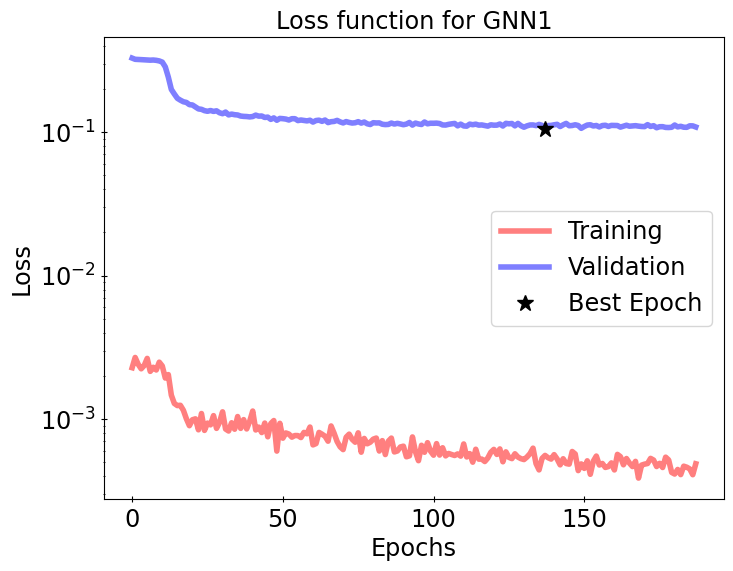

In [33]:

model_file = "model_GNN1.pt"

dict_loss = np.load(folder+"/loss_"+model_file + ".npy", allow_pickle=True).item()

fig = plt.figure(figsize=(8,6))
plt.semilogy(dict_loss["train"], linewidth=4, color="red", alpha=0.5, label="Training")
plt.semilogy(dict_loss["valid"], linewidth=4, color="blue", alpha=0.5, label="Validation")
plt.plot(np.argmin(dict_loss["valid"]), np.min(dict_loss["valid"]), 'k*', markersize=12, label="Best Epoch")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss function for GNN1")

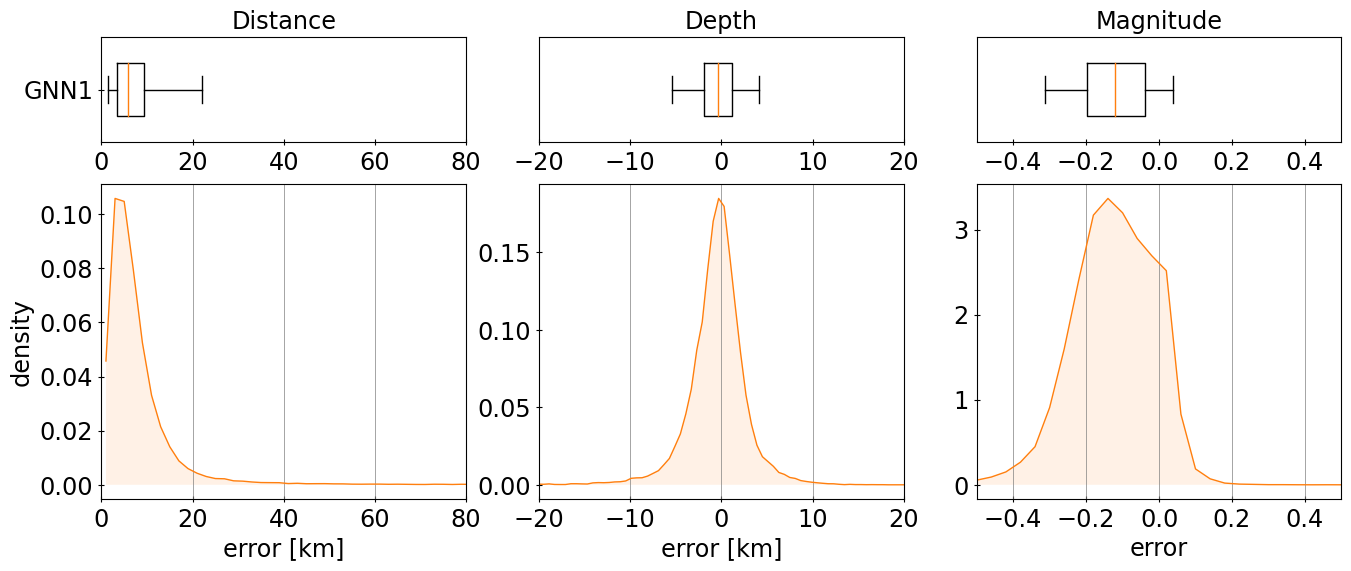

In [301]:

name = "../SCEDC/agreg-results/GNN1-DATA-select-0-0"
name_ref = "."

(results, labels, _) = pickle.load(open(name + "-all-test-results-mul.pkl", "rb"))
if name_ref != ".":
    (results_ref, labels_ref, _) = pickle.load(open(name_ref + "-all-test-results.pkl", "rb"))

fig, axs = plt.subplots(2, 3, figsize=(16, 6), gridspec_kw={'height_ratios':[1,3]})
titles = ("Distance", "Depth", "Magnitude")
err_ranges = ((0, 200), (-30, 30), (-2.0, 2.0))

def plot_density(i, results, labels, l, pos):

    ax = axs[1,i]

    if i == 0:
        lat = results[:, 0] * np.pi/180
        lat_lab = labels[:, 0] * np.pi/180
        lon = results[:, 1] * np.pi/180
        lon_lab = labels[:, 1] * np.pi/180
        test_diff = 6371 * np.arccos(np.sin(lat)*np.sin(lat_lab)+np.cos(lat)*np.cos(lat_lab)*np.cos(lon-lon_lab))
    else:
        test_diff = results[:, i+1] - labels[:, i+1]
    
    test_hist, test_bins = np.histogram(test_diff, bins=100, range=err_ranges[i], density=True)
    test_bins = 0.5 * (test_bins[1:] + test_bins[:-1])

    ax.plot(test_bins, test_hist, c="C"+str(pos), lw=1., alpha=1, label=l)
    ax.fill_between(test_bins, 0, test_hist, fc="C"+str(pos), alpha=0.1)

    ax = axs[0,i]

    ax.boxplot(test_diff, sym="", vert=False, whis=[5,95], positions=[pos], widths = 0.5, labels=[l])
    if i != 0:
        ax.set_yticks([])

axs[1,0].set_xlabel("error [km]")
axs[1,1].set_xlabel("error [km]")
axs[1,2].set_xlabel("error")
axs[1,0].set_ylabel("density")

for j in range(2):
    axs[j,0].set_xlim(0.0, 80.0)
    axs[j,1].set_xlim(-20.0, 20.0)
    axs[j,2].set_xlim(-0.5, 0.5)

absvlines = [[0, 20, 40, 60, 80], [-20, -10, 0, 10, 20], [-0.4, -0.2, 0.0, 0.2, 0.4]]


for i in range(3):
    
    for a in absvlines[i]:
        axs[1,i].axvline(a, c="grey", lw = 0.5)

    if name_ref != ".":
        plot_density(i, results_ref, labels_ref, name_ref, 0)
    plot_density(i, results, labels, "GNN1", 1)
#    axs[1,i].legend()

    axs[0,i].invert_yaxis()
    axs[0,i].set_title(titles[i])


plt.savefig(name + "-density.jpeg")





### Limitations 
While **DeepSets** offer a simple and permutation-invariant framework for learning from unordered sets, they fail to exploit any structural relationships between elements. In tasks where relational context is critical—such as molecules, meshes, or spatial point sets—this can severely limit performance.

**Fixed-graph GCNs** address this by introducing a predefined graph structure, allowing the model to aggregate local neighborhood information through message passing. This provides a relational inductive bias that enables learning contextualized features, making GCNs far more effective in structured data settings.

### Second architecture : Spectral Graph Neural Network GNN2


<img src="./images/GraphConvLayer.png" alt="" />

In this second architecture, we keep the first and last components of GNN1, but this time, we do take advantage of the graph structure of the data by replacing the second component $h^{(2)}_{\theta^{(2)}}$ with a message passing neural networks with a modified update rule such as:

$$ \hat{x_s} = \sigma \Big( x_s W + \sum_{v_j \in {\mathbb{N}_{geo}(v_s)}} \frac{1}{\sqrt{d_s d_j}}x_j W \Big) $$

Using a fixed spatial graph G computed with the stations as nodes and the euclidean distance based on the geographical coordinates of the station as the edges. For each station $v_s$, we compute a neighborhood $\mathbb{N}_{geo}(v_s)$ which are composed of the $(k=)5$-nearest neighbors in the graph.


<span style="color:red">Work in progress : Image of the graph </span>


<span style="color:red">**Work in progress : 
Image of the graph and the k nearest neighbours of a station **</span>




# 🧠 `GraphConvLayer`: Graph Convolution Layer for Spatio-Temporal Data

This class implements a **basic graph convolutional layer** tailored to spatio-temporal data with batch support. The layer propagates features across a graph structure, defined by a normalized adjacency matrix.

---

## 🔧 Constructor


| Argument        | Description |
|-----------------|-------------|
| `in_channels`   | Number of input features per node |
| `out_channels`  | Number of output features per node |
| `adj`           | Raw adjacency matrix (will be symmetrized and normalized) |
| `activ`         | Activation function (default: ReLU) |
| `dropout`       | Dropout rate applied to the output |

---

## ⚙️ Initialization Logic

1. **Symmetrize the adjacency matrix**:
  $A_{sym} = \frac{A + A^T}{2}$

2. **Compute the degree matrix**:
   $ D_i = \sum_j A_{sym}[i,j]$

3. **Normalize the adjacency matrix** using symmetric normalization:
   $\hat{A} = D^{-1/2} A_{sym} D^{-1/2}$

4. **Parameter Initialization**:
   - $\Theta \in \mathbb{R}^{\text{in\_channels} \times \text{out\_channels}} $ is a learnable parameter.
   - Initialized with **orthogonal weights**.

---

## 🔁 Forward Pass


| Input Shape | Output Shape |
|-------------|--------------|
| $ (B, C_{in}, N, T)$ | $ (B, C_{out}, N, T) $ |

- $B $: Batch size  
- $ C_{in} $, $ C_{out} $: Input/output feature dimensions  
- $ N $: Number of nodes  
- $ T$: Number of time steps  

### 🔍 Computation Steps:

1. **Graph Filtering**:
   Use Einstein summation to apply the graph convolution:

   ```python
   lfs = torch.einsum("ij,kmjl->kmil", [self.adj, X])
   ```

   This computes:

   $lfs[b, c, i, t] = \sum_j \hat{A}[i,j] \cdot X[b, c, j, t]$

2. **Feature Transformation**:
   ```python
   X = torch.einsum("kmil,mn->knil", [lfs, self.Theta])
   ```

   Equivalent to multiplying features by learnable weights $\Theta$:

   $X[b, c_{out}, i, t] = \sum_{c_{in}} lfs[b, c_{in}, i, t] \cdot \Theta[c_{in}, c_{out}]$

3. **Nonlinearity and Dropout**:
   - Apply the activation function (default: ReLU)
   - Apply 2D dropout across channels and spatial dims

---

## ✅ Summary Table

| Step              | Operation                                  | Shape |
|-------------------|--------------------------------------------|-------|
| Graph filtering   | $\hat{A} X $                         | (B, C, N, T) |
| Linear transform  | $ X \Theta $                        | (B, C', N, T) |
| Activation        | $ \text{ReLU}(\cdot)$               | (B, C', N, T) |
| Dropout           | $\text{Dropout}(\cdot) $           | (B, C', N, T) |

---

## 📌 Notes

- The use of `torch.einsum` allows for efficient and readable batch-wise tensor algebra.
- The normalized adjacency matrix ensures **stable message propagation**.
- This layer does not include temporal convolution—only spatial graph convolution is performed.

---

## 🧪 Use Case Example

```python
layer = GraphConvLayer(in_channels=16, out_channels=32, adj=adj_matrix)
output = layer(input_tensor)  # input_tensor shape: (batch, 16, nodes, time)
```

In [35]:
 
        
class GraphConvLayer(nn.Module):

    def __init__(self, in_channels, out_channels, adj, activ = F.relu, dropout = 0):
        """
        :param in_channels: Number of input features at each node in each time step.
        :param out_channels: Desired number of output features at each node in each time step.
        :param adj: Normalized adjacency matrix.
        """
        super(GraphConvLayer, self).__init__()

        adj_sym = (adj+torch.t(adj))/2
        D = torch.sum(adj_sym, dim=1).reshape((-1,))
        diag = torch.diag(torch.rsqrt(D))
        norm_adj = torch.matmul(diag, torch.matmul(adj_sym, diag))

        self.adj = norm_adj 
        self.Theta = nn.Parameter(torch.FloatTensor(in_channels, out_channels))
        self.activ = activ
        self.dropout = nn.Dropout2d(dropout)

        nn.init.orthogonal_(self.Theta)
            

    def forward(self, X):
        """
        :param X: Input data of shape (batch_size, num_features=in_channels, num_nodes, num_timesteps)
        :return: Output data of shape (batch_size, num_features=out_channels, num_nodes, num_timesteps)
        """

        # Einstein summation for applying the graph convolution
        lfs = torch.einsum("ij,kmjl->kmil", [self.adj, X])
        # Feature trasnformation
        X = torch.einsum("kmil,mn->knil", [lfs, self.Theta])
        # Non-linearity
        X = self.activ(X)
        # Dropout
        X = self.dropout(X)
        return X
   

In this case, we rely on a fixed graph computed using the euclidean distance between the spatial coordinates of the stations. For each of those stations, a spatio-temporal enhanced feature vector is computed using the temporal features vector of the CNN component and concatenating it directly with the geographic coordinates of the stations.

<img src="./images/GNN2.png" alt="" />

In [36]:

class GNN2(nn.Module):

    def __init__(self, in_channels, adj, pos, dropout = 0):
        """
        :param in_channels: Number of input features at each node in each time step.
        :param adj: Normalized adjacency matrix.
        :param pos: Positions of stations : shape (2, num_nodes)
        """
        
        super(GNN2, self).__init__()
        
        self.pos = pos
        
        self.CNNlayer = CNN(in_channels = in_channels, dropout = dropout)
        self.layers = nn.ModuleList()
        self.layers.append(GraphConvLayer(in_channels = 66, out_channels = 128, adj = adj, activ = F.relu, dropout = dropout))
        self.layers.append(GraphConvLayer(in_channels = 128, out_channels = 128, adj = adj, activ = F.relu, dropout = dropout))
        self.layers.append(MLP(num_nodes = pos.shape[1], in_channels = 128, dropout = dropout))
        

    def forward(self, X):
        """
        :param X: Input data of shape (batch_size, num_features=in_channels, num_nodes, 2048)
        :return: Output data of shape (batch_size, num_features=4)
        """
        
        X = self.CNNlayer(X)                                                    # Shape (batch_size, 64, num_nodes, 1)
        pos = self.pos.repeat(X.shape[0], 1, 1, 1).permute(0, 2, 3, 1)          # Shape (batch_size, 2, num_nodes, 1)
        X = torch.cat((X, pos), 1)                                              # Shape (batch_size, 66, num_nodes, 1)
        
        for l in self.layers:
            X = l(X)
            
        return X


In [38]:
knn = torch.topk(dist, K, largest=False)[1].cpu().detach().numpy()
adj = np.zeros((len(dist), len(dist)))
for i, row in enumerate(knn):
    for j in row:
        adj[i, j] = 1
adj = torch.Tensor(adj).to(device)

In [39]:
model = GNN2(x_train.shape[1], adj, pos, dropout_rate).to(device)
print('Total params: ' + str(sum(p.numel() for p in model.parameters())))
summary(model, x_train[0].unsqueeze(0).shape)


Total params: 110180


Layer (type:depth-idx)                   Output Shape              Param #
GNN2                                     [4]                       --
├─CNN: 1-1                               [1, 64, 72, 1]            --
│    └─ModuleList: 2-1                   --                        --
│    │    └─TimeBlock: 3-1               [1, 8, 72, 509]           784
│    │    └─TimeBlock: 3-2               [1, 16, 72, 124]          3,248
│    │    └─TimeBlock: 3-3               [1, 32, 72, 28]           12,896
│    │    └─TimeBlock: 3-4               [1, 64, 72, 20]           30,848
│    │    └─TimeBlock: 3-5               [1, 64, 72, 1]            20,544
├─ModuleList: 1-2                        --                        --
│    └─GraphConvLayer: 2-2               [1, 128, 72, 1]           8,448
│    │    └─Dropout2d: 3-6               [1, 128, 72, 1]           --
│    └─GraphConvLayer: 2-3               [1, 128, 72, 1]           16,384
│    │    └─Dropout2d: 3-7               [1, 128, 72, 1]      

In [296]:
torch.cuda.empty_cache()
gc.collect()

#               x_train             y_train
# Dimension 0 : évènements          évènements
# Dimension 1 : directions (3)      labels (4)
# Dimension 2 : stations (50)       -
# Dimension 3 : temps (2048)    

x_train, y_train = arrData[0][0], arrData[0][1]
for data_file in train_file[1:]:
    x_train = np.concatenate((x_train, arrData[0][0]), axis = 0)
    y_train = np.concatenate((y_train, arrData[0][1]), axis = 0)

x_train = torch.permute(torch.Tensor(x_train).to(device),(0,3,1,2))
y_train = torch.Tensor(y_train[:,1:]).to(device)
pos = torch.Tensor(arrData[0][2].T).to(device)
dist = torch.Tensor(arrData[0][3]).to(device)

(x_valid, y_valid, _, _) = np.load(valid_file, allow_pickle=True)
x_valid = torch.permute(torch.Tensor(x_valid).to(device),(0,3,1,2))
y_valid = torch.Tensor(y_valid[:,1:]).to(device)


knn = torch.topk(dist, K, largest=False)[1].cpu().detach().numpy()
adj = np.zeros((len(dist), len(dist)))
for i, row in enumerate(knn):
    for j in row:
        adj[i, j] = 1
adj = torch.Tensor(adj).to(device)

model =  md.GNN2(x_train.shape[1], adj, pos, dropout_rate).to(device)

model_file = "model_GNN2.pt"
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
if L2:
    criterion = nn.MSELoss().to(device)
else:
    criterion = nn.L1Loss().to(device)
    
loss_dict = {"train" : [],
            "valid" : []}
loss_valid_min = 0


earlyStopper = EarlyStopper(50, 0.0002)
for epoch in tqdm(range(n_epochs)):
    
    t1 = timeit.default_timer()
    inds = np.arange(len(x_train))
    np.random.shuffle(inds)
    
    lossAvg = 0
    count = 0
    
    for k in range(0, len(x_train)-batch_size, batch_size):
        inds_k = inds[k:k+batch_size]
        results = model(x_train[inds_k])
        loss = criterion(results,y_train[inds_k])

#        print(loss.item(),k,epoch,time()-t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossAvg = loss.item()
        count +=1
        
    lossAvg = lossAvg / count
    loss_dict["train"].append(lossAvg)

    # Early stopping
    with torch.no_grad():
        results_valid = model(x_valid)
    loss_valid = criterion(results_valid, y_valid)
    #print(loss_valid.item(), epoch, time()-t)
    if loss_valid_min == 0 or loss_valid_min > loss_valid.item():
        loss_valid_min = loss_valid.item()
        model_valid = model.state_dict()
    loss_dict["valid"].append(loss_valid.item())
    
    if earlyStopper.early_stop(loss_valid.item()):
        print(f'Epoch {epoch+1}/{n_epochs}: {t2-t1:.2f}s - Training loss = {lossAvg:.6f} - Validation loss = {loss_valid.item():.6f}')
        break
    
    t2 = timeit.default_timer()
    print(f'Epoch {epoch+1}/{n_epochs}: {t2-t1:.2f}s - Training loss = {lossAvg:.6f} - Validation loss = {loss_valid.item():.6f}')


torch.save(model_valid, folder+"/"+model_file)
np.save(folder+"/loss_"+model_file, loss_dict)
print(loss_valid_min)

  0%|          | 1/800 [00:11<2:38:27, 11.90s/it]

Epoch 1/800: 11.90s - Training loss = 0.002491 - Validation loss = 0.326330


  0%|          | 2/800 [00:23<2:39:01, 11.96s/it]

Epoch 2/800: 12.00s - Training loss = 0.002483 - Validation loss = 0.321067


  0%|          | 3/800 [00:36<2:39:44, 12.03s/it]

Epoch 3/800: 12.11s - Training loss = 0.002403 - Validation loss = 0.321012


  0%|          | 4/800 [00:48<2:40:28, 12.10s/it]

Epoch 4/800: 12.20s - Training loss = 0.001943 - Validation loss = 0.315816


  1%|          | 5/800 [01:00<2:41:31, 12.19s/it]

Epoch 5/800: 12.35s - Training loss = 0.001902 - Validation loss = 0.283218


  1%|          | 6/800 [01:12<2:40:30, 12.13s/it]

Epoch 6/800: 12.01s - Training loss = 0.001635 - Validation loss = 0.230445


  1%|          | 7/800 [01:24<2:40:11, 12.12s/it]

Epoch 7/800: 12.10s - Training loss = 0.001395 - Validation loss = 0.196018


  1%|          | 8/800 [01:36<2:38:29, 12.01s/it]

Epoch 8/800: 11.76s - Training loss = 0.001523 - Validation loss = 0.182420


  1%|          | 9/800 [01:47<2:36:18, 11.86s/it]

Epoch 9/800: 11.52s - Training loss = 0.001430 - Validation loss = 0.171273


  1%|▏         | 10/800 [01:59<2:34:55, 11.77s/it]

Epoch 10/800: 11.57s - Training loss = 0.001283 - Validation loss = 0.163952


  1%|▏         | 11/800 [02:11<2:34:00, 11.71s/it]

Epoch 11/800: 11.59s - Training loss = 0.001205 - Validation loss = 0.160631


  2%|▏         | 12/800 [02:22<2:33:21, 11.68s/it]

Epoch 12/800: 11.60s - Training loss = 0.001313 - Validation loss = 0.159203


  2%|▏         | 13/800 [02:34<2:32:33, 11.63s/it]

Epoch 13/800: 11.52s - Training loss = 0.001173 - Validation loss = 0.154130


  2%|▏         | 14/800 [02:45<2:31:57, 11.60s/it]

Epoch 14/800: 11.53s - Training loss = 0.001052 - Validation loss = 0.153641


  2%|▏         | 15/800 [02:57<2:31:33, 11.58s/it]

Epoch 15/800: 11.55s - Training loss = 0.001069 - Validation loss = 0.146737


  2%|▏         | 16/800 [03:08<2:31:12, 11.57s/it]

Epoch 16/800: 11.54s - Training loss = 0.001035 - Validation loss = 0.143377


  2%|▏         | 17/800 [03:20<2:30:53, 11.56s/it]

Epoch 17/800: 11.54s - Training loss = 0.000970 - Validation loss = 0.142267


  2%|▏         | 18/800 [03:31<2:30:36, 11.56s/it]

Epoch 18/800: 11.54s - Training loss = 0.000980 - Validation loss = 0.141349


  2%|▏         | 19/800 [03:43<2:30:19, 11.55s/it]

Epoch 19/800: 11.53s - Training loss = 0.000950 - Validation loss = 0.137464


  2%|▎         | 20/800 [03:54<2:30:01, 11.54s/it]

Epoch 20/800: 11.52s - Training loss = 0.000940 - Validation loss = 0.136124


  3%|▎         | 21/800 [04:06<2:29:47, 11.54s/it]

Epoch 21/800: 11.53s - Training loss = 0.000956 - Validation loss = 0.136472


  3%|▎         | 22/800 [04:18<2:29:34, 11.53s/it]

Epoch 22/800: 11.53s - Training loss = 0.000814 - Validation loss = 0.136363


  3%|▎         | 23/800 [04:29<2:29:19, 11.53s/it]

Epoch 23/800: 11.52s - Training loss = 0.000924 - Validation loss = 0.134033


  3%|▎         | 24/800 [04:41<2:29:06, 11.53s/it]

Epoch 24/800: 11.52s - Training loss = 0.000924 - Validation loss = 0.132974


  3%|▎         | 25/800 [04:52<2:28:57, 11.53s/it]

Epoch 25/800: 11.54s - Training loss = 0.001112 - Validation loss = 0.132349


  3%|▎         | 26/800 [05:04<2:29:29, 11.59s/it]

Epoch 26/800: 11.72s - Training loss = 0.000850 - Validation loss = 0.132263


  3%|▎         | 27/800 [05:15<2:29:19, 11.59s/it]

Epoch 27/800: 11.60s - Training loss = 0.000878 - Validation loss = 0.127743


  4%|▎         | 28/800 [05:27<2:29:15, 11.60s/it]

Epoch 28/800: 11.62s - Training loss = 0.000905 - Validation loss = 0.132239


  4%|▎         | 29/800 [05:39<2:29:35, 11.64s/it]

Epoch 29/800: 11.74s - Training loss = 0.000806 - Validation loss = 0.130226


  4%|▍         | 30/800 [05:51<2:29:48, 11.67s/it]

Epoch 30/800: 11.75s - Training loss = 0.000943 - Validation loss = 0.127278


  4%|▍         | 31/800 [06:02<2:30:17, 11.73s/it]

Epoch 31/800: 11.85s - Training loss = 0.000846 - Validation loss = 0.126107


  4%|▍         | 32/800 [06:15<2:31:30, 11.84s/it]

Epoch 32/800: 12.09s - Training loss = 0.000739 - Validation loss = 0.127523


  4%|▍         | 33/800 [06:26<2:31:03, 11.82s/it]

Epoch 33/800: 11.77s - Training loss = 0.000764 - Validation loss = 0.126901


  4%|▍         | 34/800 [06:38<2:31:06, 11.84s/it]

Epoch 34/800: 11.88s - Training loss = 0.000904 - Validation loss = 0.125926


  4%|▍         | 35/800 [06:50<2:31:13, 11.86s/it]

Epoch 35/800: 11.92s - Training loss = 0.000924 - Validation loss = 0.130825


  4%|▍         | 36/800 [07:02<2:32:46, 12.00s/it]

Epoch 36/800: 12.32s - Training loss = 0.000754 - Validation loss = 0.125102


  5%|▍         | 37/800 [07:15<2:33:59, 12.11s/it]

Epoch 37/800: 12.37s - Training loss = 0.000698 - Validation loss = 0.125184


  5%|▍         | 38/800 [07:27<2:33:42, 12.10s/it]

Epoch 38/800: 12.09s - Training loss = 0.000824 - Validation loss = 0.127375


  5%|▍         | 39/800 [07:38<2:31:32, 11.95s/it]

Epoch 39/800: 11.58s - Training loss = 0.000710 - Validation loss = 0.124420


  5%|▌         | 40/800 [07:50<2:29:40, 11.82s/it]

Epoch 40/800: 11.51s - Training loss = 0.000805 - Validation loss = 0.123184


  5%|▌         | 41/800 [08:01<2:28:21, 11.73s/it]

Epoch 41/800: 11.52s - Training loss = 0.000746 - Validation loss = 0.122323


  5%|▌         | 42/800 [08:13<2:27:58, 11.71s/it]

Epoch 42/800: 11.68s - Training loss = 0.000787 - Validation loss = 0.123308


  5%|▌         | 43/800 [08:25<2:27:04, 11.66s/it]

Epoch 43/800: 11.53s - Training loss = 0.000793 - Validation loss = 0.120818


  6%|▌         | 44/800 [08:36<2:26:22, 11.62s/it]

Epoch 44/800: 11.52s - Training loss = 0.000763 - Validation loss = 0.124086


  6%|▌         | 45/800 [08:48<2:25:50, 11.59s/it]

Epoch 45/800: 11.53s - Training loss = 0.000688 - Validation loss = 0.119644


  6%|▌         | 46/800 [08:59<2:25:24, 11.57s/it]

Epoch 46/800: 11.52s - Training loss = 0.000714 - Validation loss = 0.121295


  6%|▌         | 47/800 [09:11<2:25:01, 11.56s/it]

Epoch 47/800: 11.52s - Training loss = 0.000747 - Validation loss = 0.121994


  6%|▌         | 48/800 [09:22<2:24:39, 11.54s/it]

Epoch 48/800: 11.51s - Training loss = 0.000632 - Validation loss = 0.123740


  6%|▌         | 49/800 [09:34<2:24:22, 11.53s/it]

Epoch 49/800: 11.52s - Training loss = 0.000971 - Validation loss = 0.121698


  6%|▋         | 50/800 [09:45<2:24:06, 11.53s/it]

Epoch 50/800: 11.51s - Training loss = 0.000628 - Validation loss = 0.121876


  6%|▋         | 51/800 [09:57<2:23:55, 11.53s/it]

Epoch 51/800: 11.53s - Training loss = 0.000683 - Validation loss = 0.120882


  6%|▋         | 52/800 [10:08<2:23:43, 11.53s/it]

Epoch 52/800: 11.53s - Training loss = 0.000726 - Validation loss = 0.119670


  7%|▋         | 53/800 [10:20<2:23:28, 11.52s/it]

Epoch 53/800: 11.51s - Training loss = 0.000798 - Validation loss = 0.116607


  7%|▋         | 54/800 [10:31<2:23:20, 11.53s/it]

Epoch 54/800: 11.54s - Training loss = 0.000680 - Validation loss = 0.119432


  7%|▋         | 55/800 [10:43<2:24:12, 11.61s/it]

Epoch 55/800: 11.81s - Training loss = 0.000687 - Validation loss = 0.117253


  7%|▋         | 56/800 [10:55<2:24:23, 11.64s/it]

Epoch 56/800: 11.72s - Training loss = 0.000789 - Validation loss = 0.115818


  7%|▋         | 57/800 [11:07<2:24:29, 11.67s/it]

Epoch 57/800: 11.72s - Training loss = 0.000837 - Validation loss = 0.118509


  7%|▋         | 58/800 [11:18<2:24:26, 11.68s/it]

Epoch 58/800: 11.70s - Training loss = 0.000689 - Validation loss = 0.116409


  7%|▋         | 59/800 [11:30<2:24:31, 11.70s/it]

Epoch 59/800: 11.75s - Training loss = 0.000633 - Validation loss = 0.117828


  8%|▊         | 60/800 [11:42<2:24:31, 11.72s/it]

Epoch 60/800: 11.76s - Training loss = 0.000624 - Validation loss = 0.118608


  8%|▊         | 61/800 [11:54<2:24:55, 11.77s/it]

Epoch 61/800: 11.88s - Training loss = 0.000592 - Validation loss = 0.119816


  8%|▊         | 62/800 [12:06<2:25:54, 11.86s/it]

Epoch 62/800: 12.08s - Training loss = 0.000614 - Validation loss = 0.117679


  8%|▊         | 63/800 [12:18<2:26:31, 11.93s/it]

Epoch 63/800: 12.08s - Training loss = 0.000815 - Validation loss = 0.114469


  8%|▊         | 64/800 [12:30<2:26:48, 11.97s/it]

Epoch 64/800: 12.06s - Training loss = 0.000620 - Validation loss = 0.116174


  8%|▊         | 65/800 [12:42<2:27:05, 12.01s/it]

Epoch 65/800: 12.10s - Training loss = 0.000656 - Validation loss = 0.117796


  8%|▊         | 66/800 [12:54<2:27:32, 12.06s/it]

Epoch 66/800: 12.18s - Training loss = 0.000789 - Validation loss = 0.114138


  8%|▊         | 67/800 [13:06<2:27:15, 12.05s/it]

Epoch 67/800: 12.04s - Training loss = 0.000605 - Validation loss = 0.115824


  8%|▊         | 68/800 [13:18<2:27:02, 12.05s/it]

Epoch 68/800: 12.05s - Training loss = 0.000670 - Validation loss = 0.115254


  9%|▊         | 69/800 [13:30<2:27:04, 12.07s/it]

Epoch 69/800: 12.12s - Training loss = 0.000589 - Validation loss = 0.116769


  9%|▉         | 70/800 [13:43<2:27:19, 12.11s/it]

Epoch 70/800: 12.20s - Training loss = 0.000666 - Validation loss = 0.117447


  9%|▉         | 71/800 [13:55<2:27:25, 12.13s/it]

Epoch 71/800: 12.19s - Training loss = 0.000733 - Validation loss = 0.114831


  9%|▉         | 72/800 [14:07<2:27:25, 12.15s/it]

Epoch 72/800: 12.19s - Training loss = 0.000662 - Validation loss = 0.112691


  9%|▉         | 73/800 [14:19<2:27:10, 12.15s/it]

Epoch 73/800: 12.13s - Training loss = 0.000687 - Validation loss = 0.117354


  9%|▉         | 74/800 [14:31<2:27:08, 12.16s/it]

Epoch 74/800: 12.19s - Training loss = 0.000631 - Validation loss = 0.116486


  9%|▉         | 75/800 [14:44<2:28:13, 12.27s/it]

Epoch 75/800: 12.52s - Training loss = 0.000627 - Validation loss = 0.113761


 10%|▉         | 76/800 [14:57<2:29:57, 12.43s/it]

Epoch 76/800: 12.80s - Training loss = 0.000623 - Validation loss = 0.113636


 10%|▉         | 77/800 [15:09<2:29:49, 12.43s/it]

Epoch 77/800: 12.44s - Training loss = 0.000664 - Validation loss = 0.114919


 10%|▉         | 78/800 [15:22<2:30:08, 12.48s/it]

Epoch 78/800: 12.58s - Training loss = 0.000624 - Validation loss = 0.114757


 10%|▉         | 79/800 [15:34<2:29:47, 12.47s/it]

Epoch 79/800: 12.44s - Training loss = 0.000701 - Validation loss = 0.115629


 10%|█         | 80/800 [15:47<2:29:36, 12.47s/it]

Epoch 80/800: 12.47s - Training loss = 0.000588 - Validation loss = 0.113908


 10%|█         | 81/800 [15:59<2:30:22, 12.55s/it]

Epoch 81/800: 12.74s - Training loss = 0.000658 - Validation loss = 0.114271


 10%|█         | 82/800 [16:12<2:30:14, 12.56s/it]

Epoch 82/800: 12.57s - Training loss = 0.000641 - Validation loss = 0.116148


 10%|█         | 83/800 [16:24<2:29:42, 12.53s/it]

Epoch 83/800: 12.46s - Training loss = 0.000646 - Validation loss = 0.113250


 10%|█         | 84/800 [16:37<2:29:33, 12.53s/it]

Epoch 84/800: 12.54s - Training loss = 0.000546 - Validation loss = 0.112646


 11%|█         | 85/800 [16:49<2:28:48, 12.49s/it]

Epoch 85/800: 12.38s - Training loss = 0.000651 - Validation loss = 0.112896


 11%|█         | 86/800 [17:02<2:28:37, 12.49s/it]

Epoch 86/800: 12.49s - Training loss = 0.000486 - Validation loss = 0.117309


 11%|█         | 87/800 [17:14<2:27:58, 12.45s/it]

Epoch 87/800: 12.36s - Training loss = 0.000580 - Validation loss = 0.112809


 11%|█         | 88/800 [17:27<2:27:47, 12.45s/it]

Epoch 88/800: 12.46s - Training loss = 0.000657 - Validation loss = 0.117302


 11%|█         | 89/800 [17:39<2:28:06, 12.50s/it]

Epoch 89/800: 12.60s - Training loss = 0.000578 - Validation loss = 0.114474


 11%|█▏        | 90/800 [17:52<2:28:21, 12.54s/it]

Epoch 90/800: 12.62s - Training loss = 0.000681 - Validation loss = 0.113605


 11%|█▏        | 91/800 [18:04<2:27:39, 12.50s/it]

Epoch 91/800: 12.40s - Training loss = 0.000607 - Validation loss = 0.113444


 12%|█▏        | 92/800 [18:17<2:27:18, 12.48s/it]

Epoch 92/800: 12.46s - Training loss = 0.000585 - Validation loss = 0.112188


 12%|█▏        | 93/800 [18:29<2:27:11, 12.49s/it]

Epoch 93/800: 12.51s - Training loss = 0.000651 - Validation loss = 0.114891


 12%|█▏        | 94/800 [18:42<2:26:42, 12.47s/it]

Epoch 94/800: 12.41s - Training loss = 0.000578 - Validation loss = 0.111869


 12%|█▏        | 95/800 [18:54<2:26:32, 12.47s/it]

Epoch 95/800: 12.48s - Training loss = 0.000627 - Validation loss = 0.112332


 12%|█▏        | 96/800 [19:07<2:26:22, 12.48s/it]

Epoch 96/800: 12.48s - Training loss = 0.000511 - Validation loss = 0.115686


 12%|█▏        | 97/800 [19:19<2:26:03, 12.47s/it]

Epoch 97/800: 12.44s - Training loss = 0.000554 - Validation loss = 0.111571


 12%|█▏        | 98/800 [19:32<2:26:17, 12.50s/it]

Epoch 98/800: 12.59s - Training loss = 0.000586 - Validation loss = 0.113306


 12%|█▏        | 99/800 [19:44<2:25:36, 12.46s/it]

Epoch 99/800: 12.37s - Training loss = 0.000628 - Validation loss = 0.110325


 12%|█▎        | 100/800 [19:56<2:25:06, 12.44s/it]

Epoch 100/800: 12.38s - Training loss = 0.000499 - Validation loss = 0.113159


 13%|█▎        | 101/800 [20:09<2:24:47, 12.43s/it]

Epoch 101/800: 12.41s - Training loss = 0.000574 - Validation loss = 0.111618


 13%|█▎        | 102/800 [20:21<2:24:45, 12.44s/it]

Epoch 102/800: 12.48s - Training loss = 0.000581 - Validation loss = 0.111172


 13%|█▎        | 103/800 [20:34<2:25:14, 12.50s/it]

Epoch 103/800: 12.64s - Training loss = 0.000489 - Validation loss = 0.115463


 13%|█▎        | 104/800 [20:46<2:24:59, 12.50s/it]

Epoch 104/800: 12.49s - Training loss = 0.000562 - Validation loss = 0.112329


 13%|█▎        | 105/800 [20:59<2:24:40, 12.49s/it]

Epoch 105/800: 12.47s - Training loss = 0.000561 - Validation loss = 0.117220


 13%|█▎        | 106/800 [21:11<2:24:32, 12.50s/it]

Epoch 106/800: 12.51s - Training loss = 0.000560 - Validation loss = 0.112510


 13%|█▎        | 107/800 [21:24<2:24:21, 12.50s/it]

Epoch 107/800: 12.50s - Training loss = 0.000700 - Validation loss = 0.114823


 14%|█▎        | 108/800 [21:36<2:21:45, 12.29s/it]

Epoch 108/800: 11.81s - Training loss = 0.000561 - Validation loss = 0.115172


 14%|█▎        | 109/800 [21:48<2:20:08, 12.17s/it]

Epoch 109/800: 11.88s - Training loss = 0.000495 - Validation loss = 0.112131


 14%|█▍        | 110/800 [22:00<2:19:53, 12.16s/it]

Epoch 110/800: 12.16s - Training loss = 0.000594 - Validation loss = 0.111474


 14%|█▍        | 111/800 [22:12<2:19:44, 12.17s/it]

Epoch 111/800: 12.18s - Training loss = 0.000492 - Validation loss = 0.112437


 14%|█▍        | 112/800 [22:24<2:19:39, 12.18s/it]

Epoch 112/800: 12.20s - Training loss = 0.000590 - Validation loss = 0.112696


 14%|█▍        | 113/800 [22:36<2:19:31, 12.19s/it]

Epoch 113/800: 12.20s - Training loss = 0.000565 - Validation loss = 0.110608


 14%|█▍        | 114/800 [22:49<2:19:40, 12.22s/it]

Epoch 114/800: 12.29s - Training loss = 0.000512 - Validation loss = 0.111538


 14%|█▍        | 115/800 [23:01<2:19:53, 12.25s/it]

Epoch 115/800: 12.34s - Training loss = 0.000547 - Validation loss = 0.110172


 14%|█▍        | 116/800 [23:14<2:21:55, 12.45s/it]

Epoch 116/800: 12.90s - Training loss = 0.000566 - Validation loss = 0.109560


 15%|█▍        | 117/800 [23:27<2:22:34, 12.53s/it]

Epoch 117/800: 12.70s - Training loss = 0.000527 - Validation loss = 0.110670


 15%|█▍        | 118/800 [23:39<2:21:25, 12.44s/it]

Epoch 118/800: 12.25s - Training loss = 0.000581 - Validation loss = 0.112604


 15%|█▍        | 119/800 [23:51<2:20:39, 12.39s/it]

Epoch 119/800: 12.28s - Training loss = 0.000501 - Validation loss = 0.112579


 15%|█▌        | 120/800 [24:03<2:19:44, 12.33s/it]

Epoch 120/800: 12.18s - Training loss = 0.000534 - Validation loss = 0.109011


 15%|█▌        | 121/800 [24:16<2:19:07, 12.29s/it]

Epoch 121/800: 12.21s - Training loss = 0.000549 - Validation loss = 0.112876


 15%|█▌        | 122/800 [24:28<2:19:11, 12.32s/it]

Epoch 122/800: 12.37s - Training loss = 0.000485 - Validation loss = 0.109560


 15%|█▌        | 123/800 [24:40<2:18:34, 12.28s/it]

Epoch 123/800: 12.19s - Training loss = 0.000617 - Validation loss = 0.111794


 16%|█▌        | 124/800 [24:52<2:18:13, 12.27s/it]

Epoch 124/800: 12.24s - Training loss = 0.000602 - Validation loss = 0.112172


 16%|█▌        | 125/800 [25:05<2:17:45, 12.25s/it]

Epoch 125/800: 12.19s - Training loss = 0.000614 - Validation loss = 0.112804


 16%|█▌        | 126/800 [25:17<2:17:46, 12.27s/it]

Epoch 126/800: 12.31s - Training loss = 0.000615 - Validation loss = 0.113711


 16%|█▌        | 127/800 [25:29<2:17:26, 12.25s/it]

Epoch 127/800: 12.22s - Training loss = 0.000575 - Validation loss = 0.111714


 16%|█▌        | 128/800 [25:41<2:17:24, 12.27s/it]

Epoch 128/800: 12.31s - Training loss = 0.000433 - Validation loss = 0.108249


 16%|█▌        | 129/800 [25:54<2:17:41, 12.31s/it]

Epoch 129/800: 12.41s - Training loss = 0.000565 - Validation loss = 0.111278


 16%|█▋        | 130/800 [26:06<2:17:26, 12.31s/it]

Epoch 130/800: 12.30s - Training loss = 0.000560 - Validation loss = 0.113887


 16%|█▋        | 131/800 [26:18<2:16:58, 12.28s/it]

Epoch 131/800: 12.23s - Training loss = 0.000533 - Validation loss = 0.112320


 16%|█▋        | 132/800 [26:31<2:16:37, 12.27s/it]

Epoch 132/800: 12.24s - Training loss = 0.000512 - Validation loss = 0.110873


 17%|█▋        | 133/800 [26:43<2:16:20, 12.26s/it]

Epoch 133/800: 12.25s - Training loss = 0.000567 - Validation loss = 0.112222


 17%|█▋        | 134/800 [26:55<2:16:06, 12.26s/it]

Epoch 134/800: 12.25s - Training loss = 0.000467 - Validation loss = 0.111893


 17%|█▋        | 135/800 [27:07<2:15:54, 12.26s/it]

Epoch 135/800: 12.26s - Training loss = 0.000494 - Validation loss = 0.109198


 17%|█▋        | 136/800 [27:19<2:15:25, 12.24s/it]

Epoch 136/800: 12.18s - Training loss = 0.000555 - Validation loss = 0.112744


 17%|█▋        | 137/800 [27:32<2:15:10, 12.23s/it]

Epoch 137/800: 12.22s - Training loss = 0.000536 - Validation loss = 0.109608


 17%|█▋        | 138/800 [27:44<2:14:02, 12.15s/it]

Epoch 138/800: 11.95s - Training loss = 0.000500 - Validation loss = 0.110377


 17%|█▋        | 139/800 [27:56<2:13:49, 12.15s/it]

Epoch 139/800: 12.14s - Training loss = 0.000457 - Validation loss = 0.110527


 18%|█▊        | 140/800 [28:08<2:12:54, 12.08s/it]

Epoch 140/800: 11.93s - Training loss = 0.000466 - Validation loss = 0.112981


 18%|█▊        | 141/800 [28:20<2:12:13, 12.04s/it]

Epoch 141/800: 11.94s - Training loss = 0.000534 - Validation loss = 0.113190


 18%|█▊        | 142/800 [28:31<2:11:13, 11.97s/it]

Epoch 142/800: 11.79s - Training loss = 0.000475 - Validation loss = 0.107508


 18%|█▊        | 143/800 [28:43<2:11:00, 11.96s/it]

Epoch 143/800: 11.96s - Training loss = 0.000487 - Validation loss = 0.109696


 18%|█▊        | 144/800 [28:56<2:11:25, 12.02s/it]

Epoch 144/800: 12.15s - Training loss = 0.000503 - Validation loss = 0.109389


 18%|█▊        | 145/800 [29:08<2:11:41, 12.06s/it]

Epoch 145/800: 12.16s - Training loss = 0.000546 - Validation loss = 0.112090


 18%|█▊        | 146/800 [29:20<2:12:00, 12.11s/it]

Epoch 146/800: 12.22s - Training loss = 0.000530 - Validation loss = 0.107573


 18%|█▊        | 147/800 [29:32<2:12:01, 12.13s/it]

Epoch 147/800: 12.17s - Training loss = 0.000421 - Validation loss = 0.111178


 18%|█▊        | 148/800 [29:44<2:12:07, 12.16s/it]

Epoch 148/800: 12.22s - Training loss = 0.000473 - Validation loss = 0.109018


 19%|█▊        | 149/800 [29:57<2:12:18, 12.19s/it]

Epoch 149/800: 12.28s - Training loss = 0.000596 - Validation loss = 0.108168


 19%|█▉        | 150/800 [30:09<2:12:02, 12.19s/it]

Epoch 150/800: 12.17s - Training loss = 0.000472 - Validation loss = 0.109971


 19%|█▉        | 151/800 [30:21<2:11:45, 12.18s/it]

Epoch 151/800: 12.16s - Training loss = 0.000444 - Validation loss = 0.109041


 19%|█▉        | 152/800 [30:33<2:11:37, 12.19s/it]

Epoch 152/800: 12.20s - Training loss = 0.000506 - Validation loss = 0.111776


 19%|█▉        | 153/800 [30:45<2:11:21, 12.18s/it]

Epoch 153/800: 12.16s - Training loss = 0.000537 - Validation loss = 0.109716


 19%|█▉        | 154/800 [30:58<2:11:14, 12.19s/it]

Epoch 154/800: 12.21s - Training loss = 0.000642 - Validation loss = 0.109503


 19%|█▉        | 155/800 [31:10<2:11:03, 12.19s/it]

Epoch 155/800: 12.19s - Training loss = 0.000452 - Validation loss = 0.111603


 20%|█▉        | 156/800 [31:22<2:10:53, 12.19s/it]

Epoch 156/800: 12.20s - Training loss = 0.000490 - Validation loss = 0.109998


 20%|█▉        | 157/800 [31:34<2:10:47, 12.20s/it]

Epoch 157/800: 12.23s - Training loss = 0.000490 - Validation loss = 0.111195


 20%|█▉        | 158/800 [31:46<2:10:32, 12.20s/it]

Epoch 158/800: 12.19s - Training loss = 0.000434 - Validation loss = 0.108046


 20%|█▉        | 159/800 [31:59<2:10:17, 12.20s/it]

Epoch 159/800: 12.18s - Training loss = 0.000396 - Validation loss = 0.110268


 20%|██        | 160/800 [32:11<2:09:58, 12.19s/it]

Epoch 160/800: 12.16s - Training loss = 0.000404 - Validation loss = 0.113469


 20%|██        | 161/800 [32:23<2:09:34, 12.17s/it]

Epoch 161/800: 12.12s - Training loss = 0.000471 - Validation loss = 0.108136


 20%|██        | 162/800 [32:35<2:09:18, 12.16s/it]

Epoch 162/800: 12.15s - Training loss = 0.000465 - Validation loss = 0.110947


 20%|██        | 163/800 [32:47<2:09:30, 12.20s/it]

Epoch 163/800: 12.29s - Training loss = 0.000518 - Validation loss = 0.113648


 20%|██        | 164/800 [33:00<2:09:25, 12.21s/it]

Epoch 164/800: 12.24s - Training loss = 0.000413 - Validation loss = 0.109835


 21%|██        | 165/800 [33:12<2:09:17, 12.22s/it]

Epoch 165/800: 12.23s - Training loss = 0.000461 - Validation loss = 0.109713


 21%|██        | 166/800 [33:24<2:09:09, 12.22s/it]

Epoch 166/800: 12.24s - Training loss = 0.000557 - Validation loss = 0.112213


 21%|██        | 167/800 [33:36<2:09:11, 12.24s/it]

Epoch 167/800: 12.29s - Training loss = 0.000449 - Validation loss = 0.110936


 21%|██        | 168/800 [33:49<2:09:18, 12.28s/it]

Epoch 168/800: 12.35s - Training loss = 0.000466 - Validation loss = 0.110698


 21%|██        | 169/800 [34:01<2:09:08, 12.28s/it]

Epoch 169/800: 12.28s - Training loss = 0.000481 - Validation loss = 0.111618


 21%|██▏       | 170/800 [34:13<2:09:11, 12.30s/it]

Epoch 170/800: 12.36s - Training loss = 0.000500 - Validation loss = 0.107979


 21%|██▏       | 171/800 [34:26<2:08:49, 12.29s/it]

Epoch 171/800: 12.25s - Training loss = 0.000477 - Validation loss = 0.108951


 22%|██▏       | 172/800 [34:38<2:08:51, 12.31s/it]

Epoch 172/800: 12.36s - Training loss = 0.000443 - Validation loss = 0.108777


 22%|██▏       | 173/800 [34:50<2:08:15, 12.27s/it]

Epoch 173/800: 12.18s - Training loss = 0.000573 - Validation loss = 0.108726


 22%|██▏       | 174/800 [35:02<2:07:36, 12.23s/it]

Epoch 174/800: 12.13s - Training loss = 0.000467 - Validation loss = 0.108885


 22%|██▏       | 175/800 [35:14<2:07:15, 12.22s/it]

Epoch 175/800: 12.18s - Training loss = 0.000500 - Validation loss = 0.109629


 22%|██▏       | 176/800 [35:27<2:06:56, 12.21s/it]

Epoch 176/800: 12.18s - Training loss = 0.000433 - Validation loss = 0.109235


 22%|██▏       | 177/800 [35:39<2:06:35, 12.19s/it]

Epoch 177/800: 12.16s - Training loss = 0.000569 - Validation loss = 0.112974


 22%|██▏       | 178/800 [35:51<2:06:11, 12.17s/it]

Epoch 178/800: 12.12s - Training loss = 0.000486 - Validation loss = 0.109925


 22%|██▏       | 179/800 [36:03<2:05:56, 12.17s/it]

Epoch 179/800: 12.16s - Training loss = 0.000465 - Validation loss = 0.110412


 22%|██▎       | 180/800 [36:15<2:05:33, 12.15s/it]

Epoch 180/800: 12.11s - Training loss = 0.000470 - Validation loss = 0.111986


 23%|██▎       | 181/800 [36:27<2:05:20, 12.15s/it]

Epoch 181/800: 12.15s - Training loss = 0.000421 - Validation loss = 0.109908


 23%|██▎       | 182/800 [36:39<2:05:13, 12.16s/it]

Epoch 182/800: 12.18s - Training loss = 0.000461 - Validation loss = 0.109513


 23%|██▎       | 183/800 [36:52<2:05:11, 12.17s/it]

Epoch 183/800: 12.21s - Training loss = 0.000428 - Validation loss = 0.107922


 23%|██▎       | 184/800 [37:04<2:05:01, 12.18s/it]

Epoch 184/800: 12.19s - Training loss = 0.000441 - Validation loss = 0.110676


 23%|██▎       | 185/800 [37:16<2:04:54, 12.19s/it]

Epoch 185/800: 12.20s - Training loss = 0.000573 - Validation loss = 0.109637


 23%|██▎       | 186/800 [37:28<2:04:46, 12.19s/it]

Epoch 186/800: 12.21s - Training loss = 0.000488 - Validation loss = 0.110333


 23%|██▎       | 187/800 [37:41<2:04:42, 12.21s/it]

Epoch 187/800: 12.24s - Training loss = 0.000483 - Validation loss = 0.113289


 24%|██▎       | 188/800 [37:53<2:04:23, 12.20s/it]

Epoch 188/800: 12.17s - Training loss = 0.000494 - Validation loss = 0.108066


 24%|██▎       | 189/800 [38:05<2:03:52, 12.17s/it]

Epoch 189/800: 12.09s - Training loss = 0.000490 - Validation loss = 0.110120


 24%|██▍       | 190/800 [38:17<2:03:43, 12.17s/it]

Epoch 190/800: 12.18s - Training loss = 0.000421 - Validation loss = 0.108185


 24%|██▍       | 191/800 [38:29<2:03:32, 12.17s/it]

Epoch 191/800: 12.18s - Training loss = 0.000532 - Validation loss = 0.113115


 24%|██▍       | 192/800 [38:41<2:03:24, 12.18s/it]

Epoch 192/800: 12.19s - Training loss = 0.000437 - Validation loss = 0.109637


 24%|██▍       | 192/800 [38:54<2:03:11, 12.16s/it]

Epoch 193/800: -0.00s - Training loss = 0.000481 - Validation loss = 0.107995


TypeError: expected str, bytes or os.PathLike object, not dict

### Plotting the results

Text(0.5, 1.0, 'Loss function for GNN2')

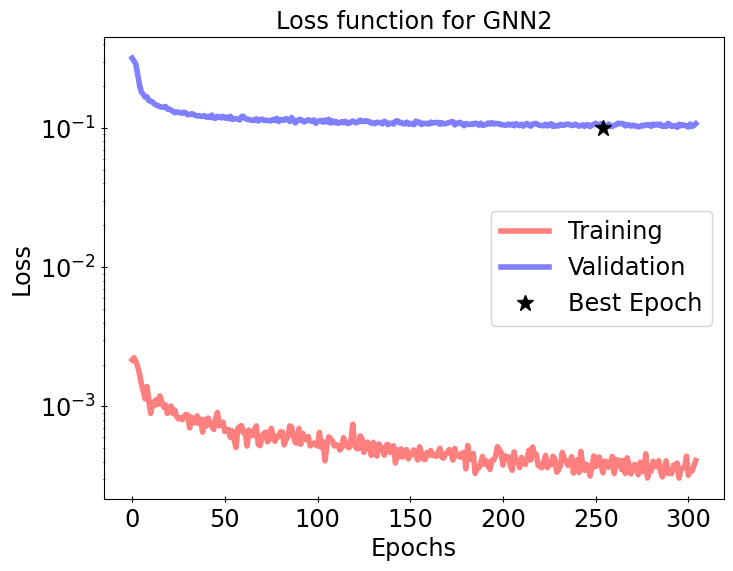

In [40]:

model_file = "model_GNN2.pt"

dict_loss = np.load(folder+"/loss_"+model_file + ".npy", allow_pickle=True).item()

fig = plt.figure(figsize=(8,6))
plt.semilogy(dict_loss["train"], linewidth=4, color="red", alpha=0.5, label="Training")
plt.semilogy(dict_loss["valid"], linewidth=4, color="blue", alpha=0.5, label="Validation")
plt.plot(np.argmin(dict_loss["valid"]), np.min(dict_loss["valid"]), 'k*', markersize=12, label="Best Epoch")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss function for GNN2")


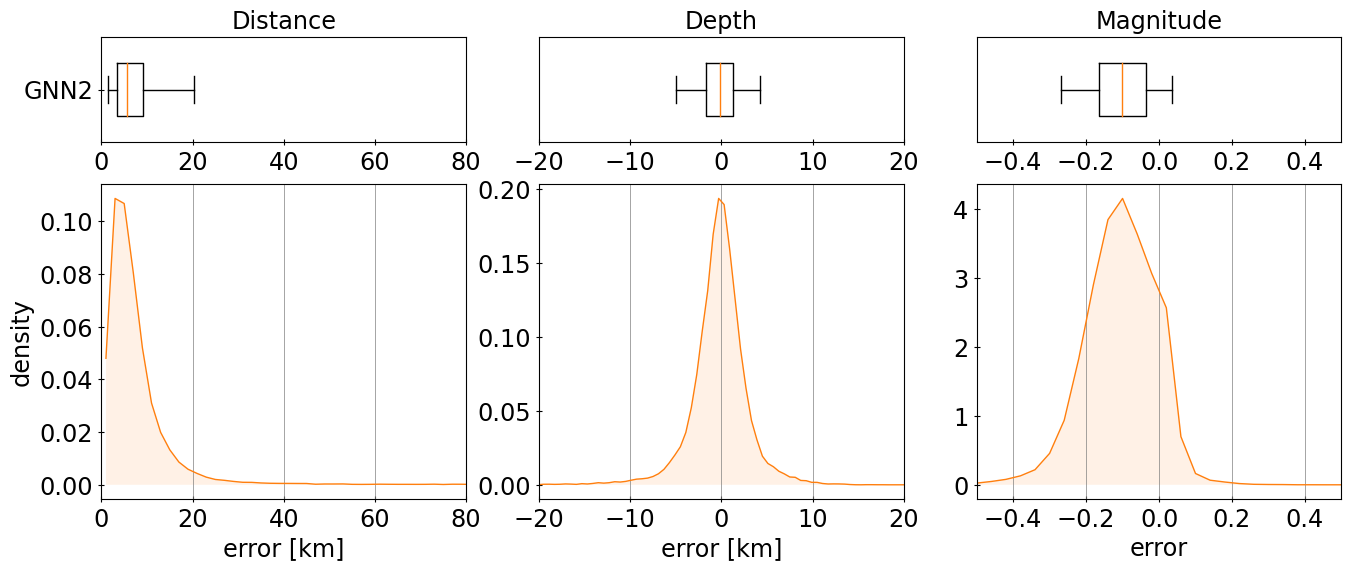

In [41]:

name = "../SCEDC/agreg-results/GNN2-DATA-select-0-0"
name_ref = "."

(results, labels, _) = pickle.load(open(name + "-all-test-results-mul.pkl", "rb"))
if name_ref != ".":
    (results_ref, labels_ref, _) = pickle.load(open(name_ref + "-all-test-results.pkl", "rb"))

fig, axs = plt.subplots(2, 3, figsize=(16, 6), gridspec_kw={'height_ratios':[1,3]})
titles = ("Distance", "Depth", "Magnitude")
err_ranges = ((0, 200), (-30, 30), (-2.0, 2.0))

def plot_density(i, results, labels, l, pos):

    ax = axs[1,i]

    if i == 0:
        lat = results[:, 0] * np.pi/180
        lat_lab = labels[:, 0] * np.pi/180
        lon = results[:, 1] * np.pi/180
        lon_lab = labels[:, 1] * np.pi/180
        test_diff = 6371 * np.arccos(np.sin(lat)*np.sin(lat_lab)+np.cos(lat)*np.cos(lat_lab)*np.cos(lon-lon_lab))
    else:
        test_diff = results[:, i+1] - labels[:, i+1]
    
    test_hist, test_bins = np.histogram(test_diff, bins=100, range=err_ranges[i], density=True)
    test_bins = 0.5 * (test_bins[1:] + test_bins[:-1])

    ax.plot(test_bins, test_hist, c="C"+str(pos), lw=1., alpha=1, label=l)
    ax.fill_between(test_bins, 0, test_hist, fc="C"+str(pos), alpha=0.1)

    ax = axs[0,i]

    ax.boxplot(test_diff, sym="", vert=False, whis=[5,95], positions=[pos], widths = 0.5, labels=[l])
    if i != 0:
        ax.set_yticks([])

axs[1,0].set_xlabel("error [km]")
axs[1,1].set_xlabel("error [km]")
axs[1,2].set_xlabel("error")
axs[1,0].set_ylabel("density")

for j in range(2):
    axs[j,0].set_xlim(0.0, 80.0)
    axs[j,1].set_xlim(-20.0, 20.0)
    axs[j,2].set_xlim(-0.5, 0.5)

absvlines = [[0, 20, 40, 60, 80], [-20, -10, 0, 10, 20], [-0.4, -0.2, 0.0, 0.2, 0.4]]


for i in range(3):
    
    for a in absvlines[i]:
        axs[1,i].axvline(a, c="grey", lw = 0.5)

    if name_ref != ".":
        plot_density(i, results_ref, labels_ref, name_ref, 0)
    plot_density(i, results, labels, "GNN2", 1)
#    axs[1,i].legend()

    axs[0,i].invert_yaxis()
    axs[0,i].set_title(titles[i])


plt.savefig(name + "-density.jpeg")





### Limitations

However, **Fixed GCNs** rely on a static, possibly hand-crafted or noisy graph structure, which may not reflect the true or most useful relationships in the data. Additionally, their lack of flexibility can lead to suboptimal learning, especially when the data’s underlying structure is latent or evolves during learning.

**Dynamic MPNNs** overcome this limitation by learning the graph topology on the fly, adapting connections based on evolving node features at each layer. This allows the network to model more complex, task-specific interactions and potentially discover hidden relational patterns. The trade-off, however, is higher computational cost and greater risk of oversmoothing, particularly if dynamic graphs collapse into trivial topologies without regularization.

### Third architecture : Dynamic Graph Neural Network GNN3

Like the second one, the third architecture replaces the second component of our general framework with a Message-Passing Neural Networks for which the graph is dynamically recomputed between each layer of the component. This time, the neighborhoods computed rely on two criteria which are the geographic proximity, the euclidean distance between the geographic coordinates $||p_i - p_j||_2$ of the stations, and the signal similarity  $||x_i - x_j||_2$, the euclidean distance between two signals waveforms of differents stations.

<img src="./images/DynamicGraphConvLayer.png" alt="" />

For this MPNN with a neighborhood k for a node $v_s$ at layer $l \in \mathbb{N^{(l)}_k}(v_s)$, the update equation is written as :

$$ x^{(l+1)}_i = \sum_k \max_{j | k \in \mathbb{N^{(l)}_k}(v_i)} f_k^{(l)} \big(u^{(l)}_i, u^{(l)}_j - u^{(l)}_i\big) $$

In this case, we have two neighborhoods $\mathbb{N}^{(l)}_{geo}(v_s)$ and $\mathbb{N}^{(l)}_{sig}(v_s)$ computed from $f^{(l)}_{geo}(p_i^{(l)}, p_j^{(l)} - p_i^{(l)}, x_i^{(l)}, x_j^{(l)} - x_i^{(l)})$ and $f^{(l)}_{sig}(x_i^{(l)}, x_j^{(l)} - x_i^{(l)})$.


The `DynamicGraphConvLayer` implements a spatio-temporal convolutional operator on graphs. It leverages both **feature-based dynamic neighborhoods** and **geometry-based static neighborhoods** to extract expressive representations over time and space.

---

## 🧩 Class Purpose

This layer builds **two separate K-Nearest-Neighbor (KNN)** graphs:

1. **Dynamic KNN (feature-based):**  
   - Computed at each forward pass.
   - Depends on node feature similarity (e.g., waveform values).

2. **Static KNN (geometry-based):**  
   - Computed once using pairwise spatial distances.
   - Remains fixed across batches.

Each neighborhood is processed by an independent MLP, and both results are fused for final prediction.

---

## 🔧 Constructor


| Argument       | Shape / Type          | Description                                            |
|----------------|-----------------------|--------------------------------------------------------|
| `in_channels`  | `int`                 | Number of input features per node                     |
| `out_channels` | `int`                 | Number of output features after convolution           |
| `K`            | `int`                 | Number of nearest neighbors to consider               |
| `dist`         | `(N, N)`              | Pairwise distances between nodes (stations)           |
| `pos`          | `(2, N)`              | 2D coordinates (latitude, longitude) of each station  |

### 📦 Internal Tensors

| Tensor         | Shape                 | Description                                             |
|----------------|-----------------------|---------------------------------------------------------|
| `self.diff`    | `(2, N, N)`           | Position differences between nodes                     |
| `ind_st_D`     | `(N, K)`              | Static KNN indices (based on geometry)                 |
| `D1, D2`       | MLPs                  | Process static features                                |
| `F1, F2`       | MLPs                  | Process dynamic features                               |

---

## 🔄 Forward Pass: Spatio-Temporal Graph Computation

### 1. **Input Shape**

$X \in \mathbb{R}^{B \times C \times N \times T}$

Where:  
- \( B \): Batch size  
- \( C \): Number of input channels  
- \( N \): Number of nodes  
- \( T \): Time steps

---

### 2. **Dynamic Neighborhood (Feature-based KNN)**

- Compute dynamic neighbors using feature similarity across time and batch.

\begin{align*}
X_{F_1} &\in \mathbb{R}^{B \times N \times K \times T \times C} \\
X_{F_2} &\in \mathbb{R}^{B \times N \times K \times T \times C} \\
X_F &= \text{concat}(X_{F_1}, X_{F_2}) \in \mathbb{R}^{B \times N \times K \times T \times 2C}
\end{align*}


---

### 3. **Static Neighborhood (Position-based KNN)**

\begin{align*}
X_Y &= \text{concat}(X, \text{pos}) \in \mathbb{R}^{B \times (C+2) \times N \times T} \\
X_{D_1} &= \text{repeated features} \in \mathbb{R}^{B \times N \times K \times T \times (C+2)} \\
X_{D_2} &= \text{geometry differences} \in \mathbb{R}^{B \times N \times K \times T \times (C+2)} \\
X_D &= \text{concat}(X_{D_1}, X_{D_2}) \in \mathbb{R}^{B \times N \times K \times T \times (2C + 4)}
\end{align*}

---

### 4. **MLP Processing**

\begin{align*}
X_F &= F_2(\text{ReLU}(F_1(X_F))) \in \mathbb{R}^{B \times N \times K \times T \times \text{out\_channels}} \\
X_D &= D_2(\text{ReLU}(D_1(X_D))) \in \mathbb{R}^{B \times N \times K \times T \times \text{out\_channels}}
\end{align*}


---

### 5. **Max Pooling and Fusion**

$X = \max_K(X_F) + \max_K(X_D)$

Then:

$X \in \mathbb{R}^{B \times N \times T \times \text{out\_channels}} \rightarrow \mathbb{R}^{B \times \text{out\_channels} \times N \times T}$


---

### 6. **Dropout and Output**

$X = \text{Dropout}(X) \in \mathbb{R}^{B \times \text{out\_channels} \times N \times T}$


---

## 🔍 Neighborhood Comparison

| Type    | Computation Basis | Shape         | Description                                    |
|---------|-------------------|---------------|------------------------------------------------|
| Static  | Geometry (fixed)  | \( (N, K) \)  | Captures spatial relationships between stations |
| Dynamic | Features (online) | \( (B, N, K) \) | Adapts to waveform similarity per batch       |

---

## ✅ Output Shape


$\text{Output: } \mathbb{R}^{B \times \text{out\_channels} \times N \times T}$


In [42]:
 
class DynamicGraphConvLayer(nn.Module):


    def __init__(self, in_channels, out_channels, K, dist, pos, activ = F.relu, dropout = 0, version = 3):
        """
        :param in_channels: Number of input features at each node in each time step.
        :param out_channels: Desired number of output features at each node in each time step.
        :param K: Nearest neighbors hyperparameter
        :param_pos: position of stations (2, num_nodes)
        """
        super(DynamicGraphConvLayer, self).__init__()

        self.version = version

        # Minimal number of neighbours for one station
        self.K = K

        # Array of tuple with stations' coordinates
        self.pos = pos
        
        # Pairwise-distances between stations
        self.diff = pos.unsqueeze(1)-pos.unsqueeze(2)                               # Shape (2, num_nodes, num_nodes)

        # Matrix with the K-neighbours for each station
        self.ind_st_D = torch.topk(dist, self.K, largest=False)[1]                  # Shape (num_nodes, K)

        # Processing part for the static neighborhood
        self.D1 = nn.Linear(in_channels*2 + 4, out_channels//2)
        self.D2 = nn.Linear(out_channels//2, out_channels)
        nn.init.orthogonal_(self.D1.weight)
        nn.init.orthogonal_(self.D2.weight)
        
        # Processing part for the dynamic neighborhood
        self.F1 = nn.Linear(in_channels*2, out_channels//2)
        self.F2 = nn.Linear(out_channels//2, out_channels)
        nn.init.orthogonal_(self.F1.weight)
        nn.init.orthogonal_(self.F2.weight)


        self.activ = activ
        self.dropout = nn.Dropout2d(dropout)
        self.pooling = nn.MaxPool3d((K, 1, 1))

    def knn(self, X):
        """
        :param X: Features of shape (batch_size, num_features=in_channels, num_nodes, num_timesteps)
        return tensor of shape (batch_size, num_features=in_channels, num_nodes, num_nodes, num_timesteps)
        """
        
        diff = X.unsqueeze(2)-X.unsqueeze(3)                                            # Shape (batch_size, in_channels, num_nodes, num_nodes, num_timesteps)
        dist = torch.sum(diff**2, (1,4))                                                # Shape (batch_size, num_nodes, num_nodes)
        indices = torch.topk(dist, self.K, largest=False)[1]                          # Shape (batch_size, num_nodes, K)
        return indices, diff

    def forward(self, X):
        """
        :param X: Input data of shape (batch_size, num_features=in_channels, num_nodes, num_timesteps)
        """

        # Position-based KNN
        X_F_1 = X.repeat(self.K, 1, 1, 1, 1)                                        # Shape (K, batch_size, in_channels, num_nodes, num_timesteps)
        X_F_1 = X_F_1.permute(1, 3, 0, 4, 2)                                        # Shape (batch_size, num_nodes, K, num_timesteps, in_channels)
        ind_st_F, diffX = self.knn(X)
        ind_st_F = ind_st_F.repeat(X.shape[1], X.shape[3], 1, 1, 1)                 # Shape (in_channels, num_timesteps, batch_size, num_nodes, K)
        ind_st_F = ind_st_F.permute(2, 0, 3, 4, 1)                                  # Shape (batch_size, in_channels, num_nodes, K, num_timesteps)
        X_F_2 = torch.gather(diffX, 3, ind_st_F)                                    # Shape (batch_size, in_channels, num_nodes, K, num_timesteps)
        X_F_2 = X_F_2.permute(0, 2, 3, 4, 1)                                        # Shape (batch_size, num_nodes, K, num_timesteps, in_channels)

        X_F = torch.cat((X_F_1, X_F_2), 4)                                          # Shape (batch_size, num_nodes, K, num_timesteps, 2*in_channels)
        
        Y_F = X_F_1 + X_F_2                                                        

        # Feature-based KNN
        Y = self.pos.repeat(X.shape[0], X.shape[3], 1, 1).permute(0, 2, 3, 1)       # Shape (batch_size, 2, num_nodes, num_timesteps)
        X_Y = torch.cat((X, Y), 1)                                                  # Shape (batch_size, in_channels + 2, num_nodes, num_timesteps)
        X_D_1 = X_Y.repeat(self.K, 1, 1, 1, 1)                                      # Shape (K, batch_size, in_channels + 2, num_nodes, num_timesteps)
        X_D_1 = X_D_1.permute(1, 3, 0, 4, 2)                                        # Shape (batch_size, num_nodes, K, num_timesteps, in_channels + 2)
        ind_st_D = self.ind_st_D.repeat(X.shape[0], X_Y.shape[1], X.shape[3], 1, 1) # Shape (batch_size, in_channels + 2, num_timesteps, num_nodes, K)
        ind_st_D = ind_st_D.permute(0, 1, 3, 4, 2)                                  # Shape (batch_size, in_channels + 2, num_nodes, K, num_timesteps)
        diffY = self.diff.repeat(X.shape[0], X.shape[3], 1, 1, 1)                   # Shape (batch_size, num_timesteps, 2, num_nodes, num_nodes)
        diffY = diffY.permute(0, 2, 3, 4, 1)                                        # Shape (batch_size, 2, num_nodes, num_nodes, num_timesteps)
        diff = torch.cat((diffX, diffY), 1)                                         # Shape (batch_size, in_channels + 2, num_nodes, num_nodes, num_timesteps)
        X_D_2 = torch.gather(diff, 3, ind_st_D)                                     # Shape (batch_size, in_channels + 2, num_nodes, K, num_timesteps)
        X_D_2 = X_D_2.permute(0, 2, 3, 4, 1)                                        # Shape (batch_size, num_nodes, K, num_timesteps, in_channels + 2)
        
        X_D = torch.cat((X_D_1, X_D_2), 4)                                          # Shape (batch_size, num_nodes, K, num_timesteps, 2*in_channels + 4)
     
        Y_D = X_D_1 + X_D_2                                                        

        # MLP Processing for each branch
        X_D = self.activ(self.D1(X_D))
        X_D = self.activ(self.D2(X_D))

        X_F = self.activ(self.F1(X_F))
        X_F = self.activ(self.F2(X_F))

        # Max-pooling and fusion
        X = self.pooling(X_D) + self.pooling(X_F)

        # Dropout and output
        X = torch.squeeze(X, dim = 2).permute(0, 3, 1, 2)
        X = self.dropout(X)

        return X

Thanks to the dynamic redefinition of neighborhoods N  at each layer, the model can adapt to evolving relational structures within the data. The combination of multi-criteria neighborhood definitions, dynamic message passing, and multi-scale feature representations motivates our use of the term Dynamic-GNN for this architecture.
<img src="./images/GNN3.png" alt="" />

Before being passed as an input of the third component, a multi-scaled embedding is produced from all of the graphs layers such as:

$\tilde{x} = x^{(0)} || ... || x^{(L)}$


This dynamic graph is only caculated from the features of the signal, through a set of layers that produce outputs of size 64 per node (station). This output of size 64 per node is the encoded signal corresponding to its node (station) produced by the layer. Hence, each layer encodes the information of the signal that it gets as entry and creates a new graph. This means that the geographical location of the stations are not modified in these layers, only the feature distance between each is. As a result, we have a set of layers that works on the features of the signal and allows us to create a new graph which edges are the euclidian distances of the output of each node (station).

In [43]:

        
class GNN3(nn.Module):

    def __init__(self, in_channels, K, dist, pos, dropout = 0, nlayers = 4):
        """
        :param in_channels: Number of input features at each node in each time step.
        :param pos: Positions of stations : shape (2, num_nodes)
        """

        super(GNN3, self).__init__()
        
        self.CNNlayer = CNN(in_channels = in_channels, dropout = dropout)
        
        self.slayers = nn.ModuleList()
        for L in range(nlayers):
            self.slayers.append(DynamicGraphConvLayer(in_channels = 64, out_channels = 64, K = K, dist = dist, pos = pos, activ = F.relu, dropout = dropout, version = version))
        
        self.MLP = MLP(num_nodes = pos.shape[1], in_channels = 64 * (nlayers + 1), dropout = dropout)

    def forward(self, X):
        """
        :param X: Input data of shape (batch_size, num_features=in_channels, num_nodes=N, num_timesteps)
        """
        
        X = self.CNNlayer(X)
        
        X_layers = [X]
        for L in self.slayers:
            X_layers.append(L(X_layers[-1]))

        X = torch.cat(X_layers, 1)
        X = self.MLP(X)
        
        return X


In [47]:
model = GNN3(x_train.shape[1], K, dist, pos, dropout_rate, nlayers).to(device)
print('Total params: ' + str(sum(p.numel() for p in model.parameters())))
summary(model, x_train[0].unsqueeze(0).shape)


Total params: 326756


Layer (type:depth-idx)                   Output Shape              Param #
GNN3                                     [4]                       --
├─CNN: 1-1                               [1, 64, 72, 1]            --
│    └─ModuleList: 2-1                   --                        --
│    │    └─TimeBlock: 3-1               [1, 8, 72, 509]           784
│    │    └─TimeBlock: 3-2               [1, 16, 72, 124]          3,248
│    │    └─TimeBlock: 3-3               [1, 32, 72, 28]           12,896
│    │    └─TimeBlock: 3-4               [1, 64, 72, 20]           30,848
│    │    └─TimeBlock: 3-5               [1, 64, 72, 1]            20,544
├─ModuleList: 1-2                        --                        --
│    └─DynamicGraphConvLayer: 2-2        [1, 64, 72, 1]            --
│    │    └─Linear: 3-6                  [1, 72, 5, 1, 32]         4,256
│    │    └─Linear: 3-7                  [1, 72, 5, 1, 64]         2,112
│    │    └─Linear: 3-8                  [1, 72, 5, 1, 32]     

In [ ]:
torch.cuda.empty_cache()
gc.collect()

device='cuda'
#               x_train             y_train
# Dimension 0 : évènements          évènements
# Dimension 1 : directions (3)      labels (4)
# Dimension 2 : stations (50)       -
# Dimension 3 : temps (2048)    

x_train, y_train = arrData[0][0], arrData[0][1]
for data_file in train_file[1:]:
    x_train = np.concatenate((x_train, arrData[0][0]), axis = 0)
    y_train = np.concatenate((y_train, arrData[0][1]), axis = 0)

x_train = torch.permute(torch.Tensor(x_train).to(device),(0,3,1,2))
y_train = torch.Tensor(y_train[:,1:]).to(device)
pos = torch.Tensor(arrData[0][2].T).to(device)
dist = torch.Tensor(arrData[0][3]).to(device)

(x_valid, y_valid, _, _) = np.load(valid_file, allow_pickle=True)
x_valid = torch.permute(torch.Tensor(x_valid).to(device),(0,3,1,2))
y_valid = torch.Tensor(y_valid[:,1:]).to(device)


model_file = "model_GNN3.pt"

model = md.GNN3(x_train.shape[1], K, dist, pos, dropout_rate, version, nlayers).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=lr)
if L2:
    criterion = nn.MSELoss().to(device)
else:
    criterion = nn.L1Loss().to(device)
    
loss_dict = {"train" : [],
            "valid" : []}
loss_valid_min = 0

for epoch in tqdm(range(n_epochs)):
    
    t1 = timeit.default_timer()
    inds = np.arange(len(x_train))
    np.random.shuffle(inds)
    
    lossAvg = 0
    count = 0
    
    for k in range(0, len(x_train)-batch_size, batch_size):
        inds_k = inds[k:k+batch_size]
        results = model(x_train[inds_k])
        loss = criterion(results,y_train[inds_k])

#        print(loss.item(),k,epoch,time()-t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossAvg = loss.item()
        count +=1
        
    lossAvg = lossAvg / count
    loss_dict["train"].append(lossAvg)
    
    with torch.no_grad():
        results_valid = model(x_valid)
    loss_valid = criterion(results_valid, y_valid)
    #print(loss_valid.item(), epoch, time()-t)
    if loss_valid_min == 0 or loss_valid_min > loss_valid.item():
        loss_valid_min = loss_valid.item()
        model_valid = model.state_dict()
    loss_dict["valid"].append(loss_valid.item())
    
    t2 = timeit.default_timer()
    print(f'Epoch {epoch+1}/{n_epochs}: {t2-t1:.2f}s - Training loss = {lossAvg:.6f} - Validation loss = {loss_valid.item():.6f}')


torch.save(model_valid, folder+"/"+model_file)
np.save(folder+"/loss_"+model_file, loss_dict)
print(loss_valid_min)

  0%|          | 1/800 [00:35<7:48:59, 35.22s/it]

Epoch 1/800: 35.22s - Training loss = 0.002162 - Validation loss = 0.317477


  0%|          | 2/800 [01:10<7:49:08, 35.27s/it]

Epoch 2/800: 35.31s - Training loss = 0.002240 - Validation loss = 0.302718


  0%|          | 3/800 [01:45<7:48:56, 35.30s/it]

Epoch 3/800: 35.34s - Training loss = 0.002107 - Validation loss = 0.287342


  0%|          | 4/800 [02:21<7:48:53, 35.34s/it]

Epoch 4/800: 35.40s - Training loss = 0.001936 - Validation loss = 0.242241


  1%|          | 5/800 [02:56<7:48:20, 35.35s/it]

Epoch 5/800: 35.35s - Training loss = 0.001705 - Validation loss = 0.203109


  1%|          | 6/800 [03:32<7:48:07, 35.37s/it]

Epoch 6/800: 35.43s - Training loss = 0.001447 - Validation loss = 0.181160


  1%|          | 7/800 [04:07<7:47:53, 35.40s/it]

Epoch 7/800: 35.46s - Training loss = 0.001290 - Validation loss = 0.174122


  1%|          | 8/800 [04:42<7:47:33, 35.42s/it]

Epoch 8/800: 35.46s - Training loss = 0.001136 - Validation loss = 0.166646


  1%|          | 9/800 [05:18<7:46:28, 35.38s/it]

Epoch 9/800: 35.30s - Training loss = 0.001391 - Validation loss = 0.167203


  1%|▏         | 10/800 [05:53<7:45:09, 35.33s/it]

Epoch 10/800: 35.21s - Training loss = 0.001102 - Validation loss = 0.157555


  1%|▏         | 11/800 [06:28<7:43:55, 35.28s/it]

Epoch 11/800: 35.17s - Training loss = 0.000893 - Validation loss = 0.155482


  2%|▏         | 12/800 [07:03<7:42:45, 35.24s/it]

Epoch 12/800: 35.13s - Training loss = 0.001073 - Validation loss = 0.153817


  2%|▏         | 13/800 [07:38<7:41:27, 35.18s/it]

Epoch 13/800: 35.05s - Training loss = 0.001015 - Validation loss = 0.148859


  2%|▏         | 14/800 [08:14<7:40:53, 35.18s/it]

Epoch 14/800: 35.18s - Training loss = 0.001123 - Validation loss = 0.145716


  2%|▏         | 15/800 [08:49<7:39:50, 35.15s/it]

Epoch 15/800: 35.06s - Training loss = 0.001038 - Validation loss = 0.144802


  2%|▏         | 16/800 [09:24<7:38:54, 35.12s/it]

Epoch 16/800: 35.06s - Training loss = 0.001192 - Validation loss = 0.142097


  2%|▏         | 17/800 [09:59<7:38:08, 35.11s/it]

Epoch 17/800: 35.07s - Training loss = 0.001077 - Validation loss = 0.140894


  2%|▏         | 18/800 [10:34<7:37:25, 35.10s/it]

Epoch 18/800: 35.07s - Training loss = 0.000990 - Validation loss = 0.141220


  2%|▏         | 19/800 [11:09<7:36:47, 35.09s/it]

Epoch 19/800: 35.08s - Training loss = 0.001028 - Validation loss = 0.142655


  2%|▎         | 20/800 [11:44<7:36:31, 35.12s/it]

Epoch 20/800: 35.18s - Training loss = 0.000892 - Validation loss = 0.136519


  3%|▎         | 21/800 [12:19<7:35:46, 35.10s/it]

Epoch 21/800: 35.07s - Training loss = 0.000954 - Validation loss = 0.136944


  3%|▎         | 22/800 [12:54<7:35:00, 35.09s/it]

Epoch 22/800: 35.06s - Training loss = 0.001009 - Validation loss = 0.133984


  3%|▎         | 23/800 [13:29<7:34:18, 35.08s/it]

Epoch 23/800: 35.06s - Training loss = 0.000891 - Validation loss = 0.131690


  3%|▎         | 24/800 [14:04<7:33:40, 35.08s/it]

Epoch 24/800: 35.07s - Training loss = 0.000943 - Validation loss = 0.128669


  3%|▎         | 25/800 [14:39<7:33:00, 35.07s/it]

Epoch 25/800: 35.05s - Training loss = 0.000846 - Validation loss = 0.130086


  3%|▎         | 26/800 [15:15<7:32:51, 35.10s/it]

Epoch 26/800: 35.18s - Training loss = 0.000814 - Validation loss = 0.129879


  3%|▎         | 27/800 [15:50<7:32:24, 35.12s/it]

Epoch 27/800: 35.14s - Training loss = 0.000832 - Validation loss = 0.128490


  4%|▎         | 28/800 [16:25<7:31:55, 35.12s/it]

Epoch 28/800: 35.14s - Training loss = 0.000805 - Validation loss = 0.127644


  4%|▎         | 29/800 [17:00<7:31:20, 35.12s/it]

Epoch 29/800: 35.12s - Training loss = 0.000847 - Validation loss = 0.129932


  4%|▍         | 30/800 [17:35<7:30:36, 35.11s/it]

Epoch 30/800: 35.08s - Training loss = 0.000876 - Validation loss = 0.127944


  4%|▍         | 31/800 [18:10<7:29:52, 35.10s/it]

Epoch 31/800: 35.07s - Training loss = 0.000870 - Validation loss = 0.124215


  4%|▍         | 32/800 [18:45<7:29:34, 35.12s/it]

Epoch 32/800: 35.17s - Training loss = 0.000701 - Validation loss = 0.125196


  4%|▍         | 33/800 [19:20<7:28:48, 35.11s/it]

Epoch 33/800: 35.08s - Training loss = 0.000838 - Validation loss = 0.126507


  4%|▍         | 34/800 [19:55<7:28:17, 35.11s/it]

Epoch 34/800: 35.12s - Training loss = 0.000771 - Validation loss = 0.125526


  4%|▍         | 35/800 [20:31<7:27:35, 35.10s/it]

Epoch 35/800: 35.08s - Training loss = 0.000762 - Validation loss = 0.123358


  4%|▍         | 36/800 [21:06<7:27:05, 35.11s/it]

Epoch 36/800: 35.13s - Training loss = 0.000856 - Validation loss = 0.122093


  5%|▍         | 37/800 [21:41<7:26:25, 35.11s/it]

Epoch 37/800: 35.09s - Training loss = 0.000754 - Validation loss = 0.122628


  5%|▍         | 38/800 [22:16<7:26:01, 35.12s/it]

Epoch 38/800: 35.15s - Training loss = 0.000811 - Validation loss = 0.121262


  5%|▍         | 39/800 [22:51<7:25:24, 35.12s/it]

Epoch 39/800: 35.11s - Training loss = 0.000655 - Validation loss = 0.120969


  5%|▌         | 40/800 [23:26<7:24:34, 35.10s/it]

Epoch 40/800: 35.05s - Training loss = 0.000808 - Validation loss = 0.122647


  5%|▌         | 41/800 [24:01<7:23:50, 35.09s/it]

Epoch 41/800: 35.06s - Training loss = 0.000724 - Validation loss = 0.119565


  5%|▌         | 42/800 [24:36<7:23:11, 35.08s/it]

Epoch 42/800: 35.07s - Training loss = 0.000825 - Validation loss = 0.121060


  5%|▌         | 43/800 [25:11<7:22:47, 35.10s/it]

Epoch 43/800: 35.13s - Training loss = 0.000761 - Validation loss = 0.119038


  6%|▌         | 44/800 [25:47<7:22:26, 35.11s/it]

Epoch 44/800: 35.15s - Training loss = 0.000723 - Validation loss = 0.123853


  6%|▌         | 45/800 [26:21<7:21:14, 35.07s/it]

Epoch 45/800: 34.95s - Training loss = 0.000683 - Validation loss = 0.117837


  6%|▌         | 46/800 [26:56<7:20:24, 35.05s/it]

Epoch 46/800: 35.00s - Training loss = 0.000820 - Validation loss = 0.117334


  6%|▌         | 47/800 [27:31<7:19:36, 35.03s/it]

Epoch 47/800: 34.99s - Training loss = 0.000905 - Validation loss = 0.121256


  6%|▌         | 48/800 [28:06<7:18:50, 35.01s/it]

Epoch 48/800: 34.98s - Training loss = 0.000725 - Validation loss = 0.119897


  6%|▌         | 49/800 [28:41<7:18:10, 35.01s/it]

Epoch 49/800: 34.99s - Training loss = 0.000758 - Validation loss = 0.118286


  6%|▋         | 50/800 [29:17<7:17:54, 35.03s/it]

Epoch 50/800: 35.09s - Training loss = 0.000772 - Validation loss = 0.121181


  6%|▋         | 51/800 [29:52<7:17:16, 35.03s/it]

Epoch 51/800: 35.02s - Training loss = 0.000661 - Validation loss = 0.117701


  6%|▋         | 52/800 [30:27<7:16:38, 35.02s/it]

Epoch 52/800: 35.01s - Training loss = 0.000674 - Validation loss = 0.119556


  7%|▋         | 53/800 [31:02<7:15:59, 35.02s/it]

Epoch 53/800: 35.01s - Training loss = 0.000684 - Validation loss = 0.116729


  7%|▋         | 54/800 [31:37<7:15:29, 35.03s/it]

Epoch 54/800: 35.04s - Training loss = 0.000599 - Validation loss = 0.121196


  7%|▋         | 55/800 [32:12<7:14:51, 35.02s/it]

Epoch 55/800: 35.01s - Training loss = 0.000668 - Validation loss = 0.115115


  7%|▋         | 56/800 [32:47<7:14:27, 35.04s/it]

Epoch 56/800: 35.07s - Training loss = 0.000578 - Validation loss = 0.116858


  7%|▋         | 57/800 [33:22<7:13:45, 35.03s/it]

Epoch 57/800: 35.01s - Training loss = 0.000507 - Validation loss = 0.116401


  7%|▋         | 58/800 [33:57<7:13:08, 35.03s/it]

Epoch 58/800: 35.02s - Training loss = 0.000696 - Validation loss = 0.115738


  7%|▋         | 59/800 [34:32<7:12:23, 35.01s/it]

Epoch 59/800: 34.98s - Training loss = 0.000717 - Validation loss = 0.114126


  8%|▊         | 60/800 [35:07<7:11:42, 35.00s/it]

Epoch 60/800: 34.98s - Training loss = 0.000728 - Validation loss = 0.120888


  8%|▊         | 61/800 [35:42<7:11:09, 35.01s/it]

Epoch 61/800: 35.01s - Training loss = 0.000646 - Validation loss = 0.121179


  8%|▊         | 62/800 [36:17<7:11:02, 35.04s/it]

Epoch 62/800: 35.13s - Training loss = 0.000663 - Validation loss = 0.117219


  8%|▊         | 63/800 [36:52<7:10:12, 35.02s/it]

Epoch 63/800: 34.98s - Training loss = 0.000521 - Validation loss = 0.115310


  8%|▊         | 64/800 [37:27<7:09:31, 35.02s/it]

Epoch 64/800: 35.00s - Training loss = 0.000677 - Validation loss = 0.115091


  8%|▊         | 65/800 [38:02<7:08:46, 35.00s/it]

Epoch 65/800: 34.97s - Training loss = 0.000628 - Validation loss = 0.113753


  8%|▊         | 66/800 [38:37<7:08:19, 35.01s/it]

Epoch 66/800: 35.04s - Training loss = 0.000617 - Validation loss = 0.113750


  8%|▊         | 67/800 [39:12<7:07:38, 35.00s/it]

Epoch 67/800: 34.98s - Training loss = 0.000680 - Validation loss = 0.113350


  8%|▊         | 68/800 [39:47<7:07:23, 35.03s/it]

Epoch 68/800: 35.10s - Training loss = 0.000725 - Validation loss = 0.116447


  9%|▊         | 69/800 [40:22<7:06:47, 35.03s/it]

Epoch 69/800: 35.03s - Training loss = 0.000534 - Validation loss = 0.112124


  9%|▉         | 70/800 [40:57<7:06:21, 35.04s/it]

Epoch 70/800: 35.07s - Training loss = 0.000524 - Validation loss = 0.114298


  9%|▉         | 71/800 [41:32<7:05:38, 35.03s/it]

Epoch 71/800: 35.00s - Training loss = 0.000614 - Validation loss = 0.115862


  9%|▉         | 72/800 [42:07<7:04:57, 35.02s/it]

Epoch 72/800: 35.01s - Training loss = 0.000638 - Validation loss = 0.113678


  9%|▉         | 73/800 [42:42<7:04:29, 35.03s/it]

Epoch 73/800: 35.05s - Training loss = 0.000654 - Validation loss = 0.113602


  9%|▉         | 74/800 [43:17<7:04:01, 35.04s/it]

Epoch 74/800: 35.07s - Training loss = 0.000557 - Validation loss = 0.113348


  9%|▉         | 75/800 [43:52<7:03:25, 35.04s/it]

Epoch 75/800: 35.04s - Training loss = 0.000582 - Validation loss = 0.112522


 10%|▉         | 76/800 [44:27<7:02:40, 35.03s/it]

Epoch 76/800: 34.99s - Training loss = 0.000697 - Validation loss = 0.112789


 10%|▉         | 77/800 [45:02<7:02:09, 35.03s/it]

Epoch 77/800: 35.04s - Training loss = 0.000623 - Validation loss = 0.115205


 10%|▉         | 78/800 [45:37<7:01:36, 35.04s/it]

Epoch 78/800: 35.04s - Training loss = 0.000562 - Validation loss = 0.113510


 10%|▉         | 79/800 [46:12<7:00:55, 35.03s/it]

Epoch 79/800: 35.01s - Training loss = 0.000607 - Validation loss = 0.117251


 10%|█         | 80/800 [46:47<7:00:37, 35.05s/it]

Epoch 80/800: 35.11s - Training loss = 0.000607 - Validation loss = 0.111247


 10%|█         | 81/800 [47:22<6:59:51, 35.04s/it]

Epoch 81/800: 35.00s - Training loss = 0.000657 - Validation loss = 0.115059


 10%|█         | 82/800 [47:57<6:59:18, 35.04s/it]

Epoch 82/800: 35.05s - Training loss = 0.000656 - Validation loss = 0.114178


 10%|█         | 83/800 [48:32<6:58:35, 35.03s/it]

Epoch 83/800: 35.00s - Training loss = 0.000530 - Validation loss = 0.113810


 10%|█         | 84/800 [49:07<6:57:56, 35.02s/it]

Epoch 84/800: 35.01s - Training loss = 0.000579 - Validation loss = 0.116758


 11%|█         | 85/800 [49:42<6:57:14, 35.01s/it]

Epoch 85/800: 34.99s - Training loss = 0.000607 - Validation loss = 0.115332


 11%|█         | 86/800 [50:18<6:56:55, 35.04s/it]

Epoch 86/800: 35.09s - Training loss = 0.000726 - Validation loss = 0.111311


 11%|█         | 87/800 [50:53<6:56:20, 35.04s/it]

Epoch 87/800: 35.03s - Training loss = 0.000714 - Validation loss = 0.118845


 11%|█         | 88/800 [51:28<6:55:44, 35.03s/it]

Epoch 88/800: 35.03s - Training loss = 0.000611 - Validation loss = 0.113793


 11%|█         | 89/800 [52:03<6:55:17, 35.05s/it]

Epoch 89/800: 35.07s - Training loss = 0.000551 - Validation loss = 0.108762


 11%|█▏        | 90/800 [52:38<6:54:41, 35.04s/it]

Epoch 90/800: 35.04s - Training loss = 0.000546 - Validation loss = 0.112536


 11%|█▏        | 91/800 [53:13<6:54:00, 35.04s/it]

Epoch 91/800: 35.01s - Training loss = 0.000695 - Validation loss = 0.115056


 12%|█▏        | 92/800 [53:48<6:53:48, 35.07s/it]

Epoch 92/800: 35.14s - Training loss = 0.000536 - Validation loss = 0.114887


 12%|█▏        | 93/800 [54:23<6:53:07, 35.06s/it]

Epoch 93/800: 35.04s - Training loss = 0.000641 - Validation loss = 0.112087


 12%|█▏        | 94/800 [54:58<6:52:25, 35.05s/it]

Epoch 94/800: 35.03s - Training loss = 0.000596 - Validation loss = 0.110502


 12%|█▏        | 95/800 [55:33<6:51:42, 35.04s/it]

Epoch 95/800: 35.01s - Training loss = 0.000576 - Validation loss = 0.112818


 12%|█▏        | 96/800 [56:08<6:50:57, 35.03s/it]

Epoch 96/800: 34.99s - Training loss = 0.000609 - Validation loss = 0.114576


 12%|█▏        | 97/800 [56:43<6:50:26, 35.03s/it]

Epoch 97/800: 35.04s - Training loss = 0.000521 - Validation loss = 0.112935


 12%|█▏        | 98/800 [57:18<6:50:03, 35.05s/it]

Epoch 98/800: 35.09s - Training loss = 0.000536 - Validation loss = 0.111366


 12%|█▏        | 99/800 [57:53<6:49:25, 35.04s/it]

Epoch 99/800: 35.03s - Training loss = 0.000547 - Validation loss = 0.114262


 12%|█▎        | 100/800 [58:28<6:48:45, 35.04s/it]

Epoch 100/800: 35.02s - Training loss = 0.000531 - Validation loss = 0.108109


 13%|█▎        | 101/800 [59:03<6:48:16, 35.04s/it]

Epoch 101/800: 35.06s - Training loss = 0.000520 - Validation loss = 0.111440


 13%|█▎        | 102/800 [59:38<6:47:33, 35.03s/it]

Epoch 102/800: 35.01s - Training loss = 0.000651 - Validation loss = 0.112859


 13%|█▎        | 103/800 [1:00:13<6:46:57, 35.03s/it]

Epoch 103/800: 35.03s - Training loss = 0.000508 - Validation loss = 0.113131


 13%|█▎        | 104/800 [1:00:48<6:46:35, 35.05s/it]

Epoch 104/800: 35.09s - Training loss = 0.000558 - Validation loss = 0.109975


 13%|█▎        | 105/800 [1:01:23<6:45:58, 35.05s/it]

Epoch 105/800: 35.04s - Training loss = 0.000407 - Validation loss = 0.113866


 13%|█▎        | 106/800 [1:01:58<6:45:27, 35.05s/it]

Epoch 106/800: 35.06s - Training loss = 0.000518 - Validation loss = 0.110400


 13%|█▎        | 107/800 [1:02:33<6:44:42, 35.04s/it]

Epoch 107/800: 35.00s - Training loss = 0.000605 - Validation loss = 0.115528


 14%|█▎        | 108/800 [1:03:08<6:44:03, 35.03s/it]

Epoch 108/800: 35.02s - Training loss = 0.000588 - Validation loss = 0.108457


 14%|█▎        | 109/800 [1:03:43<6:43:26, 35.03s/it]

Epoch 109/800: 35.02s - Training loss = 0.000565 - Validation loss = 0.112795


 14%|█▍        | 110/800 [1:04:19<6:43:05, 35.05s/it]

Epoch 110/800: 35.10s - Training loss = 0.000521 - Validation loss = 0.109158


 14%|█▍        | 111/800 [1:04:54<6:42:36, 35.06s/it]

Epoch 111/800: 35.08s - Training loss = 0.000533 - Validation loss = 0.111187


 14%|█▍        | 112/800 [1:05:29<6:41:53, 35.05s/it]

Epoch 112/800: 35.02s - Training loss = 0.000525 - Validation loss = 0.108011


 14%|█▍        | 113/800 [1:06:04<6:41:11, 35.04s/it]

Epoch 113/800: 35.01s - Training loss = 0.000487 - Validation loss = 0.108918


 14%|█▍        | 114/800 [1:06:39<6:40:30, 35.03s/it]

Epoch 114/800: 35.01s - Training loss = 0.000505 - Validation loss = 0.111020


 14%|█▍        | 115/800 [1:07:14<6:39:56, 35.03s/it]

Epoch 115/800: 35.04s - Training loss = 0.000597 - Validation loss = 0.109229


 14%|█▍        | 116/800 [1:07:49<6:39:34, 35.05s/it]

Epoch 116/800: 35.09s - Training loss = 0.000543 - Validation loss = 0.111768


 15%|█▍        | 117/800 [1:08:24<6:38:55, 35.04s/it]

Epoch 117/800: 35.03s - Training loss = 0.000514 - Validation loss = 0.107865


 15%|█▍        | 118/800 [1:08:59<6:38:17, 35.04s/it]

Epoch 118/800: 35.03s - Training loss = 0.000506 - Validation loss = 0.107946


 15%|█▍        | 119/800 [1:09:34<6:37:36, 35.03s/it]

Epoch 119/800: 35.01s - Training loss = 0.000573 - Validation loss = 0.110459


 15%|█▌        | 120/800 [1:10:09<6:37:04, 35.04s/it]

Epoch 120/800: 35.05s - Training loss = 0.000746 - Validation loss = 0.112337


 15%|█▌        | 121/800 [1:10:44<6:36:32, 35.04s/it]

Epoch 121/800: 35.05s - Training loss = 0.000524 - Validation loss = 0.109944


 15%|█▌        | 122/800 [1:11:19<6:36:12, 35.06s/it]

Epoch 122/800: 35.11s - Training loss = 0.000499 - Validation loss = 0.108816


 15%|█▌        | 123/800 [1:11:54<6:35:22, 35.04s/it]

Epoch 123/800: 34.99s - Training loss = 0.000497 - Validation loss = 0.111224


 16%|█▌        | 124/800 [1:12:29<6:34:42, 35.03s/it]

Epoch 124/800: 35.01s - Training loss = 0.000615 - Validation loss = 0.113916


 16%|█▌        | 125/800 [1:13:04<6:33:58, 35.02s/it]

Epoch 125/800: 34.99s - Training loss = 0.000587 - Validation loss = 0.111423


 16%|█▌        | 126/800 [1:13:39<6:33:23, 35.02s/it]

Epoch 126/800: 35.02s - Training loss = 0.000468 - Validation loss = 0.111111


 16%|█▌        | 127/800 [1:14:14<6:32:48, 35.02s/it]

Epoch 127/800: 35.02s - Training loss = 0.000508 - Validation loss = 0.112913


 16%|█▌        | 128/800 [1:14:49<6:32:33, 35.05s/it]

Epoch 128/800: 35.12s - Training loss = 0.000554 - Validation loss = 0.111292


 16%|█▌        | 129/800 [1:15:24<6:32:06, 35.06s/it]

Epoch 129/800: 35.09s - Training loss = 0.000526 - Validation loss = 0.111325


 16%|█▋        | 130/800 [1:15:59<6:31:22, 35.05s/it]

Epoch 130/800: 35.02s - Training loss = 0.000446 - Validation loss = 0.108118


 16%|█▋        | 131/800 [1:16:34<6:30:39, 35.04s/it]

Epoch 131/800: 35.01s - Training loss = 0.000552 - Validation loss = 0.108670


 16%|█▋        | 132/800 [1:17:09<6:30:06, 35.04s/it]

Epoch 132/800: 35.04s - Training loss = 0.000492 - Validation loss = 0.107298


 17%|█▋        | 133/800 [1:17:44<6:29:34, 35.04s/it]

Epoch 133/800: 35.06s - Training loss = 0.000439 - Validation loss = 0.109981


 17%|█▋        | 134/800 [1:18:20<6:29:16, 35.07s/it]

Epoch 134/800: 35.13s - Training loss = 0.000539 - Validation loss = 0.109447


 17%|█▋        | 135/800 [1:18:55<6:28:37, 35.06s/it]

Epoch 135/800: 35.05s - Training loss = 0.000516 - Validation loss = 0.109556


 17%|█▋        | 136/800 [1:19:30<6:28:02, 35.06s/it]

Epoch 136/800: 35.06s - Training loss = 0.000483 - Validation loss = 0.106927


 17%|█▋        | 137/800 [1:20:05<6:27:15, 35.05s/it]

Epoch 137/800: 35.00s - Training loss = 0.000447 - Validation loss = 0.111714


 17%|█▋        | 138/800 [1:20:40<6:26:48, 35.06s/it]

Epoch 138/800: 35.09s - Training loss = 0.000528 - Validation loss = 0.109993


 17%|█▋        | 139/800 [1:21:15<6:26:05, 35.05s/it]

Epoch 139/800: 35.02s - Training loss = 0.000534 - Validation loss = 0.105670


 18%|█▊        | 140/800 [1:21:50<6:25:48, 35.07s/it]

Epoch 140/800: 35.13s - Training loss = 0.000468 - Validation loss = 0.108157


 18%|█▊        | 141/800 [1:22:25<6:25:05, 35.06s/it]

Epoch 141/800: 35.03s - Training loss = 0.000479 - Validation loss = 0.108231


 18%|█▊        | 142/800 [1:23:00<6:24:15, 35.04s/it]

Epoch 142/800: 34.99s - Training loss = 0.000522 - Validation loss = 0.106620


 18%|█▊        | 143/800 [1:23:35<6:23:46, 35.05s/it]

Epoch 143/800: 35.07s - Training loss = 0.000393 - Validation loss = 0.111814


 18%|█▊        | 144/800 [1:24:10<6:23:10, 35.05s/it]

Epoch 144/800: 35.04s - Training loss = 0.000488 - Validation loss = 0.112752


 18%|█▊        | 145/800 [1:24:45<6:22:40, 35.05s/it]

Epoch 145/800: 35.07s - Training loss = 0.000435 - Validation loss = 0.109040


 18%|█▊        | 146/800 [1:25:20<6:22:15, 35.07s/it]

Epoch 146/800: 35.10s - Training loss = 0.000496 - Validation loss = 0.109797


 18%|█▊        | 147/800 [1:25:55<6:21:27, 35.05s/it]

Epoch 147/800: 35.00s - Training loss = 0.000433 - Validation loss = 0.107277


 18%|█▊        | 148/800 [1:26:30<6:20:43, 35.04s/it]

Epoch 148/800: 35.01s - Training loss = 0.000450 - Validation loss = 0.107088


 19%|█▊        | 149/800 [1:27:05<6:20:00, 35.02s/it]

Epoch 149/800: 34.99s - Training loss = 0.000490 - Validation loss = 0.110211


 19%|█▉        | 150/800 [1:27:40<6:19:30, 35.03s/it]

Epoch 150/800: 35.05s - Training loss = 0.000421 - Validation loss = 0.106511


 19%|█▉        | 151/800 [1:28:15<6:18:56, 35.03s/it]

Epoch 151/800: 35.04s - Training loss = 0.000443 - Validation loss = 0.108000


 19%|█▉        | 152/800 [1:28:51<6:18:42, 35.07s/it]

Epoch 152/800: 35.14s - Training loss = 0.000468 - Validation loss = 0.106843


 19%|█▉        | 153/800 [1:29:26<6:18:00, 35.05s/it]

Epoch 153/800: 35.03s - Training loss = 0.000487 - Validation loss = 0.105595


 19%|█▉        | 154/800 [1:30:01<6:17:34, 35.07s/it]

Epoch 154/800: 35.10s - Training loss = 0.000445 - Validation loss = 0.112064


 19%|█▉        | 155/800 [1:30:36<6:16:51, 35.06s/it]

Epoch 155/800: 35.02s - Training loss = 0.000413 - Validation loss = 0.109291


 20%|█▉        | 156/800 [1:31:11<6:16:15, 35.06s/it]

Epoch 156/800: 35.05s - Training loss = 0.000514 - Validation loss = 0.110111


 20%|█▉        | 157/800 [1:31:46<6:15:44, 35.06s/it]

Epoch 157/800: 35.07s - Training loss = 0.000469 - Validation loss = 0.105910


 20%|█▉        | 158/800 [1:32:21<6:15:18, 35.07s/it]

Epoch 158/800: 35.10s - Training loss = 0.000420 - Validation loss = 0.108145


 20%|█▉        | 159/800 [1:32:56<6:14:52, 35.09s/it]

Epoch 159/800: 35.12s - Training loss = 0.000416 - Validation loss = 0.107641


 20%|██        | 160/800 [1:33:31<6:14:09, 35.08s/it]

Epoch 160/800: 35.05s - Training loss = 0.000468 - Validation loss = 0.107935


 20%|██        | 161/800 [1:34:06<6:13:28, 35.07s/it]

Epoch 161/800: 35.05s - Training loss = 0.000446 - Validation loss = 0.106553


 20%|██        | 162/800 [1:34:41<6:12:44, 35.05s/it]

Epoch 162/800: 35.02s - Training loss = 0.000483 - Validation loss = 0.110054


 20%|██        | 163/800 [1:35:16<6:12:06, 35.05s/it]

Epoch 163/800: 35.03s - Training loss = 0.000445 - Validation loss = 0.108566


 20%|██        | 164/800 [1:35:51<6:11:52, 35.08s/it]

Epoch 164/800: 35.16s - Training loss = 0.000448 - Validation loss = 0.109127


 21%|██        | 165/800 [1:36:26<6:11:15, 35.08s/it]

Epoch 165/800: 35.07s - Training loss = 0.000438 - Validation loss = 0.109514


 21%|██        | 166/800 [1:37:01<6:10:30, 35.06s/it]

Epoch 166/800: 35.03s - Training loss = 0.000468 - Validation loss = 0.109627


 21%|██        | 167/800 [1:37:36<6:09:48, 35.05s/it]

Epoch 167/800: 35.03s - Training loss = 0.000501 - Validation loss = 0.106282


 21%|██        | 168/800 [1:38:12<6:09:13, 35.05s/it]

Epoch 168/800: 35.05s - Training loss = 0.000432 - Validation loss = 0.109206


 21%|██        | 169/800 [1:38:47<6:08:33, 35.04s/it]

Epoch 169/800: 35.02s - Training loss = 0.000426 - Validation loss = 0.107113


 21%|██▏       | 170/800 [1:39:22<6:08:10, 35.06s/it]

Epoch 170/800: 35.11s - Training loss = 0.000459 - Validation loss = 0.107283


 21%|██▏       | 171/800 [1:39:57<6:07:28, 35.05s/it]

Epoch 171/800: 35.03s - Training loss = 0.000462 - Validation loss = 0.108445


 22%|██▏       | 172/800 [1:40:32<6:06:56, 35.06s/it]

Epoch 172/800: 35.07s - Training loss = 0.000491 - Validation loss = 0.109506


 22%|██▏       | 173/800 [1:41:07<6:06:17, 35.05s/it]

Epoch 173/800: 35.03s - Training loss = 0.000462 - Validation loss = 0.110711


 22%|██▏       | 174/800 [1:41:42<6:05:44, 35.06s/it]

Epoch 174/800: 35.06s - Training loss = 0.000412 - Validation loss = 0.111060


 22%|██▏       | 175/800 [1:42:17<6:05:05, 35.05s/it]

Epoch 175/800: 35.03s - Training loss = 0.000499 - Validation loss = 0.105279


 22%|██▏       | 176/800 [1:42:52<6:04:46, 35.08s/it]

Epoch 176/800: 35.13s - Training loss = 0.000441 - Validation loss = 0.108531


 22%|██▏       | 177/800 [1:43:27<6:04:04, 35.06s/it]

Epoch 177/800: 35.03s - Training loss = 0.000446 - Validation loss = 0.107574


 22%|██▏       | 178/800 [1:44:02<6:03:32, 35.07s/it]

Epoch 178/800: 35.08s - Training loss = 0.000432 - Validation loss = 0.109801


 22%|██▏       | 179/800 [1:44:37<6:02:58, 35.07s/it]

Epoch 179/800: 35.07s - Training loss = 0.000463 - Validation loss = 0.106993


 22%|██▎       | 180/800 [1:45:12<6:02:20, 35.06s/it]

Epoch 180/800: 35.05s - Training loss = 0.000467 - Validation loss = 0.103662


 23%|██▎       | 181/800 [1:45:47<6:01:42, 35.06s/it]

Epoch 181/800: 35.05s - Training loss = 0.000357 - Validation loss = 0.107739


 23%|██▎       | 182/800 [1:46:22<6:01:14, 35.07s/it]

Epoch 182/800: 35.10s - Training loss = 0.000525 - Validation loss = 0.105993


 23%|██▎       | 183/800 [1:46:57<6:00:35, 35.07s/it]

Epoch 183/800: 35.05s - Training loss = 0.000417 - Validation loss = 0.105907


 23%|██▎       | 184/800 [1:47:33<6:00:04, 35.07s/it]

Epoch 184/800: 35.09s - Training loss = 0.000438 - Validation loss = 0.107186


 23%|██▎       | 185/800 [1:48:08<5:59:21, 35.06s/it]

Epoch 185/800: 35.03s - Training loss = 0.000460 - Validation loss = 0.105971


 23%|██▎       | 186/800 [1:48:43<5:58:45, 35.06s/it]

Epoch 186/800: 35.05s - Training loss = 0.000331 - Validation loss = 0.108403


 23%|██▎       | 187/800 [1:49:18<5:58:06, 35.05s/it]

Epoch 187/800: 35.04s - Training loss = 0.000360 - Validation loss = 0.107112


 24%|██▎       | 188/800 [1:49:53<5:57:50, 35.08s/it]

Epoch 188/800: 35.15s - Training loss = 0.000363 - Validation loss = 0.104723


 24%|██▎       | 189/800 [1:50:28<5:57:10, 35.08s/it]

Epoch 189/800: 35.06s - Training loss = 0.000392 - Validation loss = 0.108251


 24%|██▍       | 190/800 [1:51:03<5:56:39, 35.08s/it]

Epoch 190/800: 35.09s - Training loss = 0.000438 - Validation loss = 0.104377


 24%|██▍       | 191/800 [1:51:38<5:55:54, 35.06s/it]

Epoch 191/800: 35.02s - Training loss = 0.000384 - Validation loss = 0.105383


 24%|██▍       | 192/800 [1:52:13<5:55:20, 35.07s/it]

Epoch 192/800: 35.07s - Training loss = 0.000407 - Validation loss = 0.106010


 24%|██▍       | 193/800 [1:52:48<5:54:46, 35.07s/it]

Epoch 193/800: 35.07s - Training loss = 0.000373 - Validation loss = 0.108556


 24%|██▍       | 194/800 [1:53:23<5:54:21, 35.09s/it]

Epoch 194/800: 35.12s - Training loss = 0.000354 - Validation loss = 0.106672


 24%|██▍       | 195/800 [1:53:58<5:53:44, 35.08s/it]

Epoch 195/800: 35.07s - Training loss = 0.000411 - Validation loss = 0.109522


 24%|██▍       | 196/800 [1:54:33<5:53:01, 35.07s/it]

Epoch 196/800: 35.04s - Training loss = 0.000412 - Validation loss = 0.106649


 25%|██▍       | 197/800 [1:55:08<5:52:16, 35.05s/it]

Epoch 197/800: 35.01s - Training loss = 0.000440 - Validation loss = 0.108008


 25%|██▍       | 198/800 [1:55:43<5:51:41, 35.05s/it]

Epoch 198/800: 35.05s - Training loss = 0.000515 - Validation loss = 0.107159


 25%|██▍       | 199/800 [1:56:18<5:51:00, 35.04s/it]

Epoch 199/800: 35.02s - Training loss = 0.000493 - Validation loss = 0.107379


 25%|██▌       | 200/800 [1:56:54<5:50:47, 35.08s/it]

Epoch 200/800: 35.16s - Training loss = 0.000466 - Validation loss = 0.105353


 25%|██▌       | 201/800 [1:57:29<5:50:14, 35.08s/it]

Epoch 201/800: 35.09s - Training loss = 0.000380 - Validation loss = 0.105449


 25%|██▌       | 202/800 [1:58:04<5:49:33, 35.07s/it]

Epoch 202/800: 35.05s - Training loss = 0.000444 - Validation loss = 0.104735


 25%|██▌       | 203/800 [1:58:39<5:48:43, 35.05s/it]

Epoch 203/800: 34.99s - Training loss = 0.000420 - Validation loss = 0.104773


 26%|██▌       | 204/800 [1:59:14<5:48:13, 35.06s/it]

Epoch 204/800: 35.07s - Training loss = 0.000436 - Validation loss = 0.106720


 26%|██▌       | 205/800 [1:59:49<5:47:43, 35.07s/it]

Epoch 205/800: 35.09s - Training loss = 0.000372 - Validation loss = 0.105046


 26%|██▌       | 206/800 [2:00:24<5:47:21, 35.09s/it]

Epoch 206/800: 35.14s - Training loss = 0.000348 - Validation loss = 0.106496


 26%|██▌       | 207/800 [2:00:59<5:46:42, 35.08s/it]

Epoch 207/800: 35.06s - Training loss = 0.000472 - Validation loss = 0.103742


 26%|██▌       | 208/800 [2:01:34<5:46:02, 35.07s/it]

Epoch 208/800: 35.05s - Training loss = 0.000398 - Validation loss = 0.107547


 26%|██▌       | 209/800 [2:02:09<5:45:25, 35.07s/it]

Epoch 209/800: 35.06s - Training loss = 0.000409 - Validation loss = 0.105182


 26%|██▋       | 210/800 [2:02:44<5:44:47, 35.06s/it]

Epoch 210/800: 35.06s - Training loss = 0.000364 - Validation loss = 0.104062


 26%|██▋       | 211/800 [2:03:19<5:44:22, 35.08s/it]

Epoch 211/800: 35.12s - Training loss = 0.000430 - Validation loss = 0.106141


 26%|██▋       | 212/800 [2:03:55<5:43:58, 35.10s/it]

Epoch 212/800: 35.14s - Training loss = 0.000402 - Validation loss = 0.103043


 27%|██▋       | 213/800 [2:04:30<5:43:07, 35.07s/it]

Epoch 213/800: 35.01s - Training loss = 0.000383 - Validation loss = 0.105785


 27%|██▋       | 214/800 [2:05:05<5:42:28, 35.06s/it]

Epoch 214/800: 35.05s - Training loss = 0.000420 - Validation loss = 0.107870


 27%|██▋       | 215/800 [2:05:40<5:41:47, 35.05s/it]

Epoch 215/800: 35.03s - Training loss = 0.000486 - Validation loss = 0.104416


 27%|██▋       | 216/800 [2:06:15<5:41:14, 35.06s/it]

Epoch 216/800: 35.07s - Training loss = 0.000413 - Validation loss = 0.103077


 27%|██▋       | 217/800 [2:06:50<5:40:41, 35.06s/it]

Epoch 217/800: 35.07s - Training loss = 0.000512 - Validation loss = 0.106812


 27%|██▋       | 218/800 [2:07:25<5:40:25, 35.09s/it]

Epoch 218/800: 35.17s - Training loss = 0.000451 - Validation loss = 0.107359


 27%|██▋       | 219/800 [2:08:00<5:39:47, 35.09s/it]

Epoch 219/800: 35.08s - Training loss = 0.000453 - Validation loss = 0.107773


 28%|██▊       | 220/800 [2:08:35<5:39:08, 35.08s/it]

Epoch 220/800: 35.07s - Training loss = 0.000378 - Validation loss = 0.105276


 28%|██▊       | 221/800 [2:09:10<5:38:29, 35.08s/it]

Epoch 221/800: 35.06s - Training loss = 0.000369 - Validation loss = 0.104352


 28%|██▊       | 222/800 [2:09:45<5:37:52, 35.07s/it]

Epoch 222/800: 35.06s - Training loss = 0.000364 - Validation loss = 0.104230


 28%|██▊       | 223/800 [2:10:20<5:37:15, 35.07s/it]

Epoch 223/800: 35.06s - Training loss = 0.000403 - Validation loss = 0.103656


 28%|██▊       | 224/800 [2:10:55<5:36:56, 35.10s/it]

Epoch 224/800: 35.16s - Training loss = 0.000445 - Validation loss = 0.106485


 28%|██▊       | 225/800 [2:11:31<5:36:27, 35.11s/it]

Epoch 225/800: 35.13s - Training loss = 0.000363 - Validation loss = 0.103328


 28%|██▊       | 226/800 [2:12:06<5:35:37, 35.08s/it]

Epoch 226/800: 35.02s - Training loss = 0.000400 - Validation loss = 0.105023


 28%|██▊       | 227/800 [2:12:40<5:34:09, 34.99s/it]

Epoch 227/800: 34.78s - Training loss = 0.000382 - Validation loss = 0.107367


 28%|██▊       | 228/800 [2:13:15<5:33:07, 34.94s/it]

Epoch 228/800: 34.83s - Training loss = 0.000439 - Validation loss = 0.102483


 29%|██▊       | 229/800 [2:13:50<5:32:30, 34.94s/it]

Epoch 229/800: 34.93s - Training loss = 0.000420 - Validation loss = 0.104682


 29%|██▉       | 230/800 [2:14:25<5:32:25, 34.99s/it]

Epoch 230/800: 35.12s - Training loss = 0.000338 - Validation loss = 0.103197


 29%|██▉       | 231/800 [2:15:00<5:32:00, 35.01s/it]

Epoch 231/800: 35.05s - Training loss = 0.000352 - Validation loss = 0.103628


 29%|██▉       | 232/800 [2:15:35<5:31:31, 35.02s/it]

Epoch 232/800: 35.04s - Training loss = 0.000376 - Validation loss = 0.106312


 29%|██▉       | 233/800 [2:16:10<5:30:56, 35.02s/it]

Epoch 233/800: 35.02s - Training loss = 0.000469 - Validation loss = 0.104781


 29%|██▉       | 234/800 [2:16:46<5:30:37, 35.05s/it]

Epoch 234/800: 35.11s - Training loss = 0.000424 - Validation loss = 0.104503


 29%|██▉       | 235/800 [2:17:21<5:30:07, 35.06s/it]

Epoch 235/800: 35.08s - Training loss = 0.000407 - Validation loss = 0.106275


 30%|██▉       | 236/800 [2:17:56<5:29:56, 35.10s/it]

Epoch 236/800: 35.20s - Training loss = 0.000378 - Validation loss = 0.106837


 30%|██▉       | 237/800 [2:18:31<5:29:07, 35.08s/it]

Epoch 237/800: 35.02s - Training loss = 0.000383 - Validation loss = 0.105560


 30%|██▉       | 238/800 [2:19:06<5:28:33, 35.08s/it]

Epoch 238/800: 35.08s - Training loss = 0.000436 - Validation loss = 0.104133


 30%|██▉       | 239/800 [2:19:41<5:27:49, 35.06s/it]

Epoch 239/800: 35.02s - Training loss = 0.000332 - Validation loss = 0.104638


 30%|███       | 240/800 [2:20:16<5:27:17, 35.07s/it]

Epoch 240/800: 35.08s - Training loss = 0.000395 - Validation loss = 0.106682


 30%|███       | 241/800 [2:20:51<5:26:32, 35.05s/it]

Epoch 241/800: 35.01s - Training loss = 0.000414 - Validation loss = 0.104868


 30%|███       | 242/800 [2:21:26<5:26:06, 35.07s/it]

Epoch 242/800: 35.10s - Training loss = 0.000336 - Validation loss = 0.103122


 30%|███       | 243/800 [2:22:01<5:25:29, 35.06s/it]

Epoch 243/800: 35.05s - Training loss = 0.000475 - Validation loss = 0.103917


 30%|███       | 244/800 [2:22:36<5:25:02, 35.08s/it]

Epoch 244/800: 35.11s - Training loss = 0.000380 - Validation loss = 0.105318


 31%|███       | 245/800 [2:23:11<5:24:20, 35.06s/it]

Epoch 245/800: 35.04s - Training loss = 0.000348 - Validation loss = 0.102721


 31%|███       | 246/800 [2:23:46<5:23:26, 35.03s/it]

Epoch 246/800: 34.95s - Training loss = 0.000386 - Validation loss = 0.105353


 31%|███       | 247/800 [2:24:21<5:23:17, 35.08s/it]

Epoch 247/800: 35.18s - Training loss = 0.000366 - Validation loss = 0.105329


 31%|███       | 248/800 [2:24:57<5:23:03, 35.12s/it]

Epoch 248/800: 35.20s - Training loss = 0.000317 - Validation loss = 0.102164


### Plotting the results

Text(0.5, 1.0, 'Loss function for GNN3')

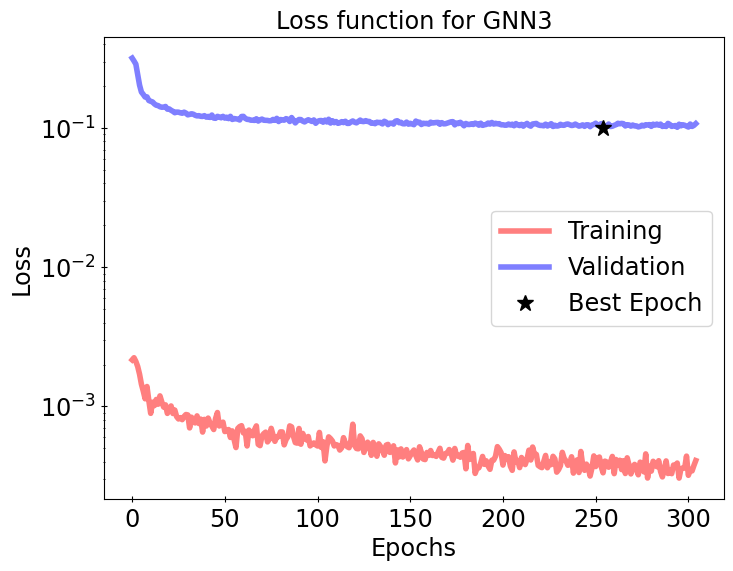

In [48]:

model_file = "model_GNN3.pt"

dict_loss = np.load(folder+"/loss_"+model_file + ".npy", allow_pickle=True).item()

fig = plt.figure(figsize=(8,6))
plt.semilogy(dict_loss["train"], linewidth=4, color="red", alpha=0.5, label="Training")
plt.semilogy(dict_loss["valid"], linewidth=4, color="blue", alpha=0.5, label="Validation")
plt.plot(np.argmin(dict_loss["valid"]), np.min(dict_loss["valid"]), 'k*', markersize=12, label="Best Epoch")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss function for GNN3")


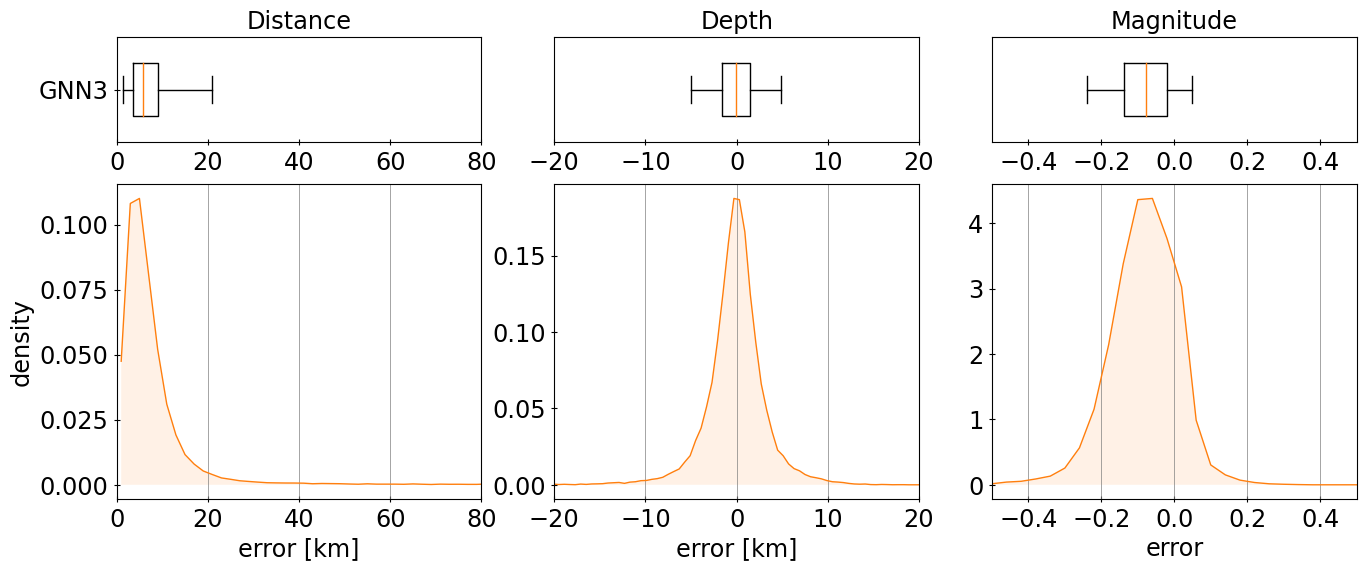

In [49]:

name = "../SCEDC/agreg-results/GNN3-DATA-select-0-0"
name_ref = "."

(results, labels, _) = pickle.load(open(name + "-all-test-results-mul.pkl", "rb"))
if name_ref != ".":
    (results_ref, labels_ref, _) = pickle.load(open(name_ref + "-all-test-results.pkl", "rb"))

fig, axs = plt.subplots(2, 3, figsize=(16, 6), gridspec_kw={'height_ratios':[1,3]})
titles = ("Distance", "Depth", "Magnitude")
err_ranges = ((0, 200), (-30, 30), (-2.0, 2.0))

def plot_density(i, results, labels, l, pos):

    ax = axs[1,i]

    if i == 0:
        lat = results[:, 0] * np.pi/180
        lat_lab = labels[:, 0] * np.pi/180
        lon = results[:, 1] * np.pi/180
        lon_lab = labels[:, 1] * np.pi/180
        test_diff = 6371 * np.arccos(np.sin(lat)*np.sin(lat_lab)+np.cos(lat)*np.cos(lat_lab)*np.cos(lon-lon_lab))
    else:
        test_diff = results[:, i+1] - labels[:, i+1]
    
    test_hist, test_bins = np.histogram(test_diff, bins=100, range=err_ranges[i], density=True)
    test_bins = 0.5 * (test_bins[1:] + test_bins[:-1])

    ax.plot(test_bins, test_hist, c="C"+str(pos), lw=1., alpha=1, label=l)
    ax.fill_between(test_bins, 0, test_hist, fc="C"+str(pos), alpha=0.1)

    ax = axs[0,i]

    ax.boxplot(test_diff, sym="", vert=False, whis=[5,95], positions=[pos], widths = 0.5, labels=[l])
    if i != 0:
        ax.set_yticks([])

axs[1,0].set_xlabel("error [km]")
axs[1,1].set_xlabel("error [km]")
axs[1,2].set_xlabel("error")
axs[1,0].set_ylabel("density")

for j in range(2):
    axs[j,0].set_xlim(0.0, 80.0)
    axs[j,1].set_xlim(-20.0, 20.0)
    axs[j,2].set_xlim(-0.5, 0.5)

absvlines = [[0, 20, 40, 60, 80], [-20, -10, 0, 10, 20], [-0.4, -0.2, 0.0, 0.2, 0.4]]


for i in range(3):
    
    for a in absvlines[i]:
        axs[1,i].axvline(a, c="grey", lw = 0.5)

    if name_ref != ".":
        plot_density(i, results_ref, labels_ref, name_ref, 0)
    plot_density(i, results, labels, "GNN3", 1)
#    axs[1,i].legend()

    axs[0,i].invert_yaxis()
    axs[0,i].set_title(titles[i])


plt.savefig(name + "-density.jpeg")





### Assesing the oversmoothing effect using the Dirichlet Energy as a metric

* **What is the Oversmoothing Effect?**

    In graph neural networks (GNNs), oversmoothing refers to the phenomenon where, as you add more layers, the node representations (features) become increasingly similar to each other. Eventually, the features across all nodes converge to nearly the same vector, losing their ability to distinguish between different nodes.


* **Why is this a problem?**

    When nodes become indistinguishable, the model loses expressive power and can't effectively perform tasks like classification or regression that depend on capturing node-specific information.


* **How Does Dirichlet Energy Help?**

    The Dirichlet energy measures the variation or smoothness of node features across the graph. Mathematically, it sums squared differences of features between connected nodes, weighted by edge strength.

    - High Dirichlet energy means node features vary a lot between neighbors (less smooth).

    - Low Dirichlet energy means node features are very similar across neighbors (more smooth).


* **As a GNN gets deeper:**

    - The Dirichlet energy typically decreases, showing features become smoother.

    - If the energy approaches zero, it indicates the node features have nearly converged.

* **What is the Dirichlet Energy?**
 
In graph signal processing, the Dirichlet energy of a graph signal (e.g., node embeddings or physical measurements) is a measure of how rapidly the signal varies over the graph structure. It is formally defined (for a signal x) as:

$E(x) = X^T L X = \sum_{i~j} w_{ij}(X_i - X_j)^2$

Where $L$ is the graph Laplacian and $w_{ij}$ are edge weights.

* **How to interpret the dirichlet energy in a seismic context**
  
When a seismic event occurs, sensors (nodes) closer to the epicenter experience stronger and faster-changing signals (e.g., sudden spikes in vibration or waveform features). If we treat these sensor measurements as a graph signal:
 - The signal varies more rapidly in the vicinity of the event.
 -  Thus, the local Dirichlet energy is higher near the seismic source, since $(Xi−Xj)^2$ is larger on edges around the event.

* **How does Dirichlet Energy and oversmoothing connect?**

Based on the article "Characterizing and Avoiding Over-smoothing in Graph Neural Networks" (arXiv:2303.10993), Dirichlet energy provides a powerful, model-agnostic way to quantify oversmoothing in Graph Neural Networks (GNNs). It measures how much node features vary across connected nodes, with lower values indicating that features have become too similar — a hallmark of oversmoothing. Specifically, it is defined as $E(X)=X^TLX$, where $L$ is the graph Laplacian and $X$ the node features. By computing the Dirichlet energy at each GNN layer, one can observe how feature diversity changes with depth: a sharp drop in energy typically signals increasing oversmoothing. This makes Dirichlet energy a useful diagnostic tool to assess and mitigate the degradation of expressive power in deeper GNNs.

Here are a few visual example of the effect of oversmoothing for multiple GNN3 with differents layers on multiple events of the French Dataset:

#### Event 0



<img src="./oversmoothing/Global_LDG_Ev0.gif" alt="" width="500" />

<img src="./oversmoothing/PerNodes_LDG_L1_Ev0.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L2_Ev0.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L4_Ev0.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L6_Ev0.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L8_Ev0.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L12_Ev0.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L16_Ev0.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L20_Ev0.gif" alt="" width="1000" />


#### Event 10



<img src="./oversmoothing/Global_LDG_Ev10.gif" alt="" width="500" />

<img src="./oversmoothing/PerNodes_LDG_L1_Ev10.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L2_Ev10.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L4_Ev10.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L6_Ev10.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L8_Ev10.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L12_Ev10.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L16_Ev10.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L20_Ev10.gif" alt="" width="1000" />


#### Event 20



<img src="./oversmoothing/Global_LDG_Ev20.gif" alt="" width="500" />

<img src="./oversmoothing/PerNodes_LDG_L1_Ev20.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L2_Ev20.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L4_Ev20.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L6_Ev20.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L8_Ev20.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L12_Ev20.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L16_Ev20.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L20_Ev20.gif" alt="" width="1000" />


#### Event 30



<img src="./oversmoothing/Global_LDG_Ev30.gif" alt="" width="500" />

<img src="./oversmoothing/PerNodes_LDG_L1_Ev30.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L2_Ev30.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L4_Ev30.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L6_Ev30.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L8_Ev30.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L12_Ev30.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L16_Ev30.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L20_Ev30.gif" alt="" width="1000" />


#### Event 40



<img src="./oversmoothing/Global_LDG_Ev40.gif" alt="" width="500" />

<img src="./oversmoothing/PerNodes_LDG_L1_Ev40.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L2_Ev40.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L4_Ev40.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L6_Ev40.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L8_Ev40.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L12_Ev40.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L16_Ev40.gif" alt="" width="1000" />
<img src="./oversmoothing/PerNodes_LDG_L20_Ev40.gif" alt="" width="1000" />


### Boxplots
To better understand how information propagates across layers in our model, we analyze the distance between stations and seismic events for each GNN layer using boxplots. Each boxplot summarizes the distribution of these distances across events, showing how they tend to decrease with layer depth. This trend reflects the model's increasing focus on stations that are geographically closer to the seismic source as layers deepen, effectively narrowing the receptive field. Overlaid on this plot, we include the Dirichlet energy computed at each layer, which shows a similar decreasing trend. This correlation indicates that as distances shrink, node representations across the graph become more homogeneous—an effect quantified by the drop in Dirichlet energy. Together, the boxplot and Dirichlet energy curve illustrate how the model progressively smooths the features, revealing both spatial and spectral signatures of oversmoothing in the network.

<div style="text-align: center;">
  <img src="images/boxplot_oversmoothing_L1.png" alt="" width="500"> 
</div>


<div style="text-align: center;">
  <img src="images/boxplot_oversmoothing_L2.png" alt="" width="500"> 
</div>


<div style="text-align: center;">
  <img src="images/boxplot_oversmoothing_L4.png" alt="" width="500"> 
</div>


<div style="text-align: center;">
  <img src="images/boxplot_oversmoothing_L6.png" alt="" width="500"> 
</div>


<div style="text-align: center;">
  <img src="images/boxplot_oversmoothing_L8.png" alt="" width="500">
</div>


<div style="text-align: center;">
  <img src="images/boxplot_oversmoothing_L12.png" alt="" width="500"> 
</div>


<div style="text-align: center;">
  <img src="images/boxplot_oversmoothing_L16.png" alt="" width="500"> 
</div>


<div style="text-align: center;">
  <img src="images/boxplot_oversmoothing_L20.png" alt="" width="500"> 

</div>


## 3. Results

### 📊 Comparison of Set and Graph-based Neural Architectures

| Model Type       | ✅ Benefits                                                                                                                                         | ⚠️ Drawbacks                                                                                                                                                 | 🔍 Typical Use Cases                                                                                         |
|------------------|------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------|
| **DeepSets**     | - Permutation-invariant by design; ideal for unstructured sets<br>- Low risk of oversmoothing (no graph diffusion)<br>- Simple and efficient       | - No relational inductive bias (ignores structure)<br>- Limited expressivity when context or locality matters                                              | Unordered inputs like point clouds, bag-of-features, or sets without known structure                        |
| **Fixed-graph GCNs** | - Leverages known graph structure for feature propagation<br>- Encodes relational bias, aiding generalization<br>- Efficient once graph is fixed | - Can oversmooth as depth increases<br>- Performance limited by predefined graph quality<br>- Cannot adapt the graph dynamically                           | Citation networks, molecular structures, or any domain with a reliable static graph                         |
| **Dynamic MPNNs** | - Graph structure evolves with learned features<br>- Captures context-sensitive, dynamic interactions<br>- High expressivity                     | - Computationally expensive (e.g., k-NN or attention per layer)<br>- Risk of oversmoothing from topology collapse<br>- May be unstable without constraints | Physical simulations, particle systems, relational reasoning, or when the graph is unknown or dynamic       |


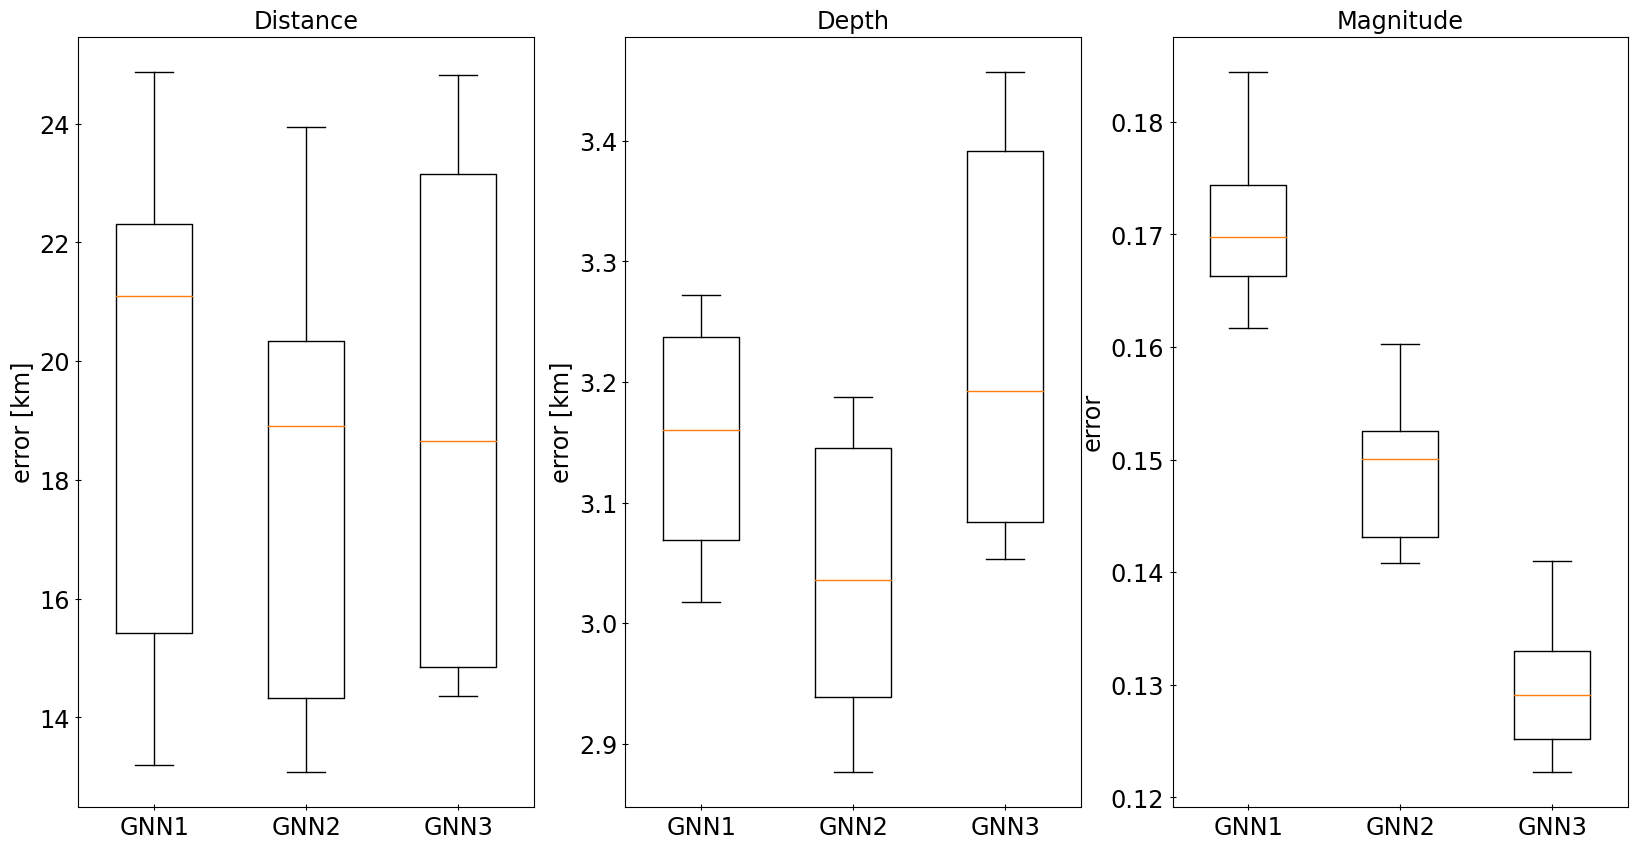

In [221]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

models = ["../SCEDC/agreg-results/GNN1-DATA-select-0-0",
          "../SCEDC/agreg-results/GNN2-DATA-select-0-0",
          "../SCEDC/agreg-results/GNN3-DATA-select-0-0"]
name = "GNN"

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
titles = ("Distance", "Depth", "Magnitude")

axs[0].set_ylabel("error [km]")
axs[1].set_ylabel("error [km]")
axs[2].set_ylabel("error")
#axs[0].set_ylim(10.0, 30.0)
#axs[1].set_ylim(3.8, 5.0)
#axs[2].set_ylim(0.15, 0.3)

for i in range(3):

    axs[i].set_xlim(-0.5, len(models)-0.5)

    for j, model in enumerate(models):

        (results, labels, index) = pickle.load(open(model + "-all-test-results-mul.pkl", "rb"))

        if i == 0:
            lat = results[:, 0] * np.pi/180
            lat_lab = labels[:, 0] * np.pi/180
            lon = results[:, 1] * np.pi/180
            lon_lab = labels[:, 1] * np.pi/180
            test_diff = 6371 * np.arccos(np.sin(lat)*np.sin(lat_lab)+np.cos(lat)*np.cos(lat_lab)*np.cos(lon-lon_lab))
        else:
            test_diff = results[:, i+1] - labels[:, i+1]

        RMSE = np.zeros((10))
        for f in range(10):
            RMSE[f] = np.sqrt(np.sum((index[:,1] == f)*np.abs(test_diff)**2)/np.sum(index[:,1] == f))
        
        axs[i].boxplot(RMSE, sym="", whis=[5,95], positions=[j], widths = 0.5, labels=[model.split("/")[-1].split("-")[0]])

    axs[i].set_title(titles[i])

plt.savefig("./images/" + name + "-boxplot.jpeg")
plt.show()



✅ Why Dynamical Graph + MPNN is Better
1. Learnable Structure (vs Fixed GCN)

   - Dynamic MPNNs build or adapt the graph structure (edges, weights) from data at each step.

   - This is crucial when true relational structure is unknown or noisy (e.g., in point clouds, particle systems, social data).

📌 Fixed GCNs assume a predefined adjacency matrix, which can be suboptimal or incorrect.

2. Relational Expressivity (vs Deep Sets)

    - MPNNs capture interactions between elements, not just aggregate them.

    - Useful in systems where pairwise (or higher-order) interactions matter (e.g., physical simulations, molecules).

📌 Deep Sets assume i.i.d. elements, and lack mechanisms for learning how elements influence each other.

3. Adaptive Topology

   - In dynamic graphs, connectivity can change with inputs or over time (e.g., based on learned attention, distances, features).

   - This supports tasks like tracking, segmentation, graph prediction, etc.

📌 Fixed graphs cannot adapt to changing relationships.

⚠️ Limitations of Dynamical MPNNs

   - Computational Overhead : Recomputing the graph and doing message passing is more expensive than Deep Sets or fixed GCNs.

   - Stability : Dynamically learning edge weights or topologies can be unstable or harder to train without regularization.

   - Interpretability : Dynamic graphs are harder to analyze or visualize, especially when edges are implicit (e.g., via attention).

   - Scalability :  For large NN, dynamic graphs can require O(N2)O(N2) memory (if fully connected or dense attention).

🧪 Summary Table

| Model Type |  Perm. Invariance | Learns Structure | Captures Interactions | Adaptive | Cost |
| ------------ | ----------------- | ---------------- | --------------------- | -------- | -----|
| Deep Sets | ✅ Yes | ❌ No | ❌ No | ❌ No | 🔋 Low |
| Fixed GCN | ❌ No (semi-local) | ❌ No | ✅ Yes (static) | ❌ No | ⚡ Medium |
| Dynamic MPNN | ✅ / ❌ (depends) |  ✅ Yes | ✅ Yes (adaptive) | ✅ Yes | 🔥 High |


##  4. Conclusion
- GNNs provide an effective way to model spatial dependencies in seismic networks.
- With pre-trained models, inference is fast and suitable for near real-time analysis.
- This approach can be extended with more station data, real-time feeds, and uncertainty quantification.



## References

[1] Andrea Baldassarre and Hossein Azizpour. Explainability techniques for graph con-
volutional networks. In Proceedings of the 2019 ICML Workshop on Learning and Rea-
soning with Graph-Structured Data, 2019.


[2] Joan Bruna, Wojciech Zaremba, Arthur Szlam, and Yann LeCun. Spectral networks
and locally connected networks on graphs. CoRR, abs/1312.6203, 2013.


[3] Micha¨el Defferrard, Xavier Bresson, and Pierre Vandergheynst. Convolutional neural
networks on graphs with fast localized spectral filtering. In NIPS, 2016.


[4] M. P. A. Ende and Jean Paul Ampuero. Automated seismic source characterization
using deep graph neural networks. Geophysical Research Letters, 47, 2020.


[5] Justin Gilmer, Samuel S. Schoenholz, Patrick F. Riley, Oriol Vinyals, and George E.
Dahl. Neural message passing for quantum chemistry. In International Conference
on Machine Learning, 2017.


[6] Marco Gori, Gabriele Monfardini, and Franco Scarselli. A new model for learning in
graph domains. Proceedings. 2005 IEEE International Joint Conference on Neural Net-
works, 2005., 2:729–734 vol. 2, 2005.


[7] Kate Hutton, Jochen Woessner, and Egill Hauksson. Earthquake monitoring in south-
ern california for seventy-seven years (1932-2008). Bulletin of the Seismological Society
of America, 100:423–446, 2010.


[8] International Federation of Digital Seismograph Networks. https://www.fdsn.org/.


[9] Diederik P. Kingma and Jimmy Ba. Adam: A method for stochastic optimization. arXiv
preprint arXiv:1412.6980, 2017.


[10] Thomas Kipf and Max Welling. Semi-supervised classification with graph convolu-
tional networks. ArXiv, abs/1609.02907, 2016.


[11] Thomas N Kipf and Max Welling. Semi-supervised classification with graph convolu-
tional networks. In International Conference on Learning Representations (ICLR), 2017.


[12] Marius Kriegerowski, Gesa Maria Petersen, Hannes Vasyura-Bathke, and Matthias
Ohrnberger. A deep convolutional neural network for localization of clustered earth-
quakes based on multistation full waveforms. Seismological Research Letters, 2018.


[13] Anthony Lomax, Alberto Michelini, and Dario Jozinovi´c. An investigation of rapid
earthquake characterization using single-station waveforms and a convolutional
neural network. Seismological Research Letters, 2019.


[14] Ra´ul Madariaga. Dynamics of an expanding circular fault. Bulletin of the Seismological
Society of America, 66(3):639–666, 1976.


[15] Kenta Oono and Taiji Suzuki. Graph neural networks exponentially lose expressive
power for node classification. In International Conference on Learning Representations
(ICLR), 2020.


[16] C. P´equegnat, J. Schaeffer, C. Satriano, H. Pedersen, J. Touvier, J.-M. Saurel, M. Calvet,
L. Stehly, P. Arnoul, and et al. Bollard P. Resif-si: A distributed information system
for french seismological data. Seismol. Res. Lett., 92:1832–1853, 2021.


[17] Thibaut Perol, Micha¨el Gharbi, and Marine A. Denolle. Convolutional neural network
for earthquake detection and location. Science Advances, 4, 2017.


[18] Franco Scarselli, Marco Gori, Ah Chung Tsoi, Markus Hagenbuchner, and Gabriele
Monfardini. The graph neural network model. IEEE Transactions on Neural Networks,
20:61–80, 2009.


[19] SCEDC (2013): Southern California Earthquake Center. Caltech. Dataset.
doi:10.7909/C3WD3xH1.


[20] Yue Wang, Yongbin Sun, Ziwei Liu, Sanjay E. Sarma, Michael M. Bronstein, and
Justin M. Solomon. Dynamic graph cnn for learning on point clouds. ACM Trans-
actions on Graphics (TOG), 38(5):146:1–146:12, 2019. Proc. SIGGRAPH 2019.


[21] Changkeun Yoon, Oliver O’Reilly, Karianne Bergen, and Gregory C. Beroza. Earth-
quake detection through computationally efficient similarity search. Science Ad-
vances, 1(11):e1501057, 2015.


[22] Manzil Zaheer, Satwik Kottur, Siamak Ravanbakhsh, Barnabas Poczos, Ruslan
Salakhutdinov, and Alexander J. Smola. Deep sets. In Advances in Neural Informa-
tion Processing Systems (NeurIPS), volume 30, pages 3391–3401, 2017.[14] Ra´ul Madariaga. Dynamics of an expanding circular fault. Bulletin of the Seismological
Society of America, 66(3):639–666, 1976.


[15] Kenta Oono and Taiji Suzuki. Graph neural networks exponentially lose expressive
power for node classification. In International Conference on Learning Representations
(ICLR), 2020.


[16] C. P´equegnat, J. Schaeffer, C. Satriano, H. Pedersen, J. Touvier, J.-M. Saurel, M. Calvet,
L. Stehly, P. Arnoul, and et al. Bollard P. Resif-si: A distributed information system
for french seismological data. Seismol. Res. Lett., 92:1832–1853, 2021.


[17] Thibaut Perol, Micha¨el Gharbi, and Marine A. Denolle. Convolutional neural network
for earthquake detection and location. Science Advances, 4, 2017.


[18] Franco Scarselli, Marco Gori, Ah Chung Tsoi, Markus Hagenbuchner, and Gabriele
Monfardini. The graph neural network model. IEEE Transactions on Neural Networks,
20:61–80, 2009.


[19] SCEDC (2013): Southern California Earthquake Center. Caltech. Dataset.
doi:10.7909/C3WD3xH1.


[20] Yue Wang, Yongbin Sun, Ziwei Liu, Sanjay E. Sarma, Michael M. Bronstein, and
Justin M. Solomon. Dynamic graph cnn for learning on point clouds. ACM Trans-
actions on Graphics (TOG), 38(5):146:1–146:12, 2019. Proc. SIGGRAPH 2019.


[21] Changkeun Yoon, Oliver O’Reilly, Karianne Bergen, and Gregory C. Beroza. Earth-
quake detection through computationally efficient similarity search. Science Ad-
vances, 1(11):e1501057, 2015.


[22] Manzil Zaheer, Satwik Kottur, Siamak Ravanbakhsh, Barnabas Poczos, Ruslan
Salakhutdinov, and Alexander J. Smola. Deep sets. In Advances in Neural Informa-
tion Processing Systems (NeurIPS), volume 30, pages 3391–3401, 2017.

[14] Ra´ul Madariaga. Dynamics of an expanding circular fault. Bulletin of the Seismological
Society of America, 66(3):639–666, 1976.


[15] Kenta Oono and Taiji Suzuki. Graph neural networks exponentially lose expressive
power for node classification. In International Conference on Learning Representations
(ICLR), 2020.


[16] C. P´equegnat, J. Schaeffer, C. Satriano, H. Pedersen, J. Touvier, J.-M. Saurel, M. Calvet,
L. Stehly, P. Arnoul, and et al. Bollard P. Resif-si: A distributed information system
for french seismological data. Seismol. Res. Lett., 92:1832–1853, 2021.


[17] Thibaut Perol, Micha¨el Gharbi, and Marine A. Denolle. Convolutional neural network
for earthquake detection and location. Science Advances, 4, 2017.


[18] Franco Scarselli, Marco Gori, Ah Chung Tsoi, Markus Hagenbuchner, and Gabriele
Monfardini. The graph neural network model. IEEE Transactions on Neural Networks,
20:61–80, 2009.


[19] SCEDC (2013): Southern California Earthquake Center. Caltech. Dataset.
doi:10.7909/C3WD3xH1.


[20] Yue Wang, Yongbin Sun, Ziwei Liu, Sanjay E. Sarma, Michael M. Bronstein, and
Justin M. Solomon. Dynamic graph cnn for learning on point clouds. ACM Trans-
actions on Graphics (TOG), 38(5):146:1–146:12, 2019. Proc. SIGGRAPH 2019.


[21] Changkeun Yoon, Oliver O’Reilly, Karianne Bergen, and Gregory C. Beroza. Earth-
quake detection through computationally efficient similarity search. Science Ad-
vances, 1(11):e1501057, 2015.


[22] Manzil Zaheer, Satwik Kottur, Siamak Ravanbakhsh, Barnabas Poczos, Ruslan
Salakhutdinov, and Alexander J. Smola. Deep sets. In Advances in Neural Informa-
tion Processing Systems (NeurIPS), volume 30, pages 3391–3401, 2017.


[23] Xiong Zhang, Jie Zhang, Congcong Yuan, Sen Liu, Zhibo Chen, and Weiping Li. Locat-
ing induced earthquakes with a network of seismic stations in oklahoma via a deep
learning method. Scientific Reports, 10, 2018.


[24] Xitong Zhang, Will Reichard-Flynn, Miao Zhang, Matthew Hirn, and Youzuo Lin.
Spatio-temporal graph convolutional networks for earthquake source characteriza-
tion. Journal of Geophysical Research: Solid Earth, 127, 11 2022.


[25] Weiqiang Zhu and Gregory C. Beroza. Phasenet: A deep-neural-network-based seis-
mic arrival time picking method. Geophysical Journal International, 2018.


[26] Weiqiang Zhu and Gregory C. Beroza. Deep learning for seismic phase picking: Com-
parison with traditional algorithms. Geophysical Journal International, 216(1):261–
273, 2019.